# 1. Installing the dependencies

In [1]:
#Pytorch Imports
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.optim import lr_scheduler
import torchvision.models as models
from torch.utils.data import ConcatDataset
import torch
import torchvision.transforms as transforms

#Sklearn imports
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

#Plotting Imports
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

#Other Imports
import os
import random
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

#Storing cuda or cpu in device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
%%capture
#Dependencies for the diffusion model
!pip install diffusers[training]==0.11.1

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 1. Drive mounting

In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/project522/project_data')

Mounted at /content/drive


#2. Exploratory Data Analysis

 1. Image paths and label paths(train and test data) 
>The images are divided into training and testing sets, with their file paths and corresponding labels being stored in two lists each (train_paths, train_labels, test_paths, test_labels)
  



In [ ]:
##Training paths and labels

train_dir = '/content/drive//Shareddrives/project522/project_data/Training/'
train_paths = []
train_labels = []
#For each image file in each subdirectory, appending file path to the train_paths list and its corresponding label to the train_labels list
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        train_paths.append(image_path)
        train_labels.append(label)
#Shuffling order of image paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)


##Testing paths and labels

test_dir = '/content/drive//Shareddrives/project522/project_data/Testing/'
test_paths = []
test_labels = []
#For each image file in each subdirectory, appending file path to the test_paths list and its corresponding label to the test_labels list
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

#Shuffling order of image paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)

2. Data Label Distribution and Data split Distribution
>This code creates two visualizations to show the label distribution of the training set and the distribution of images between the train and test sets.





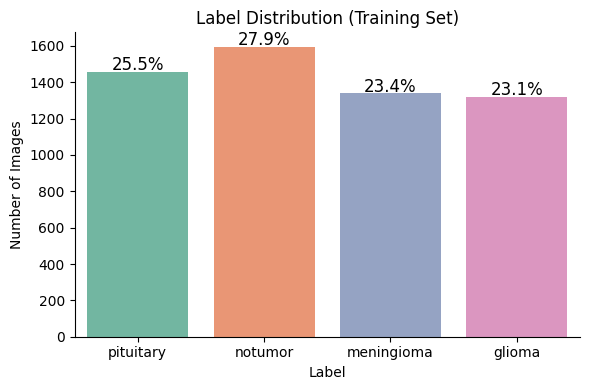

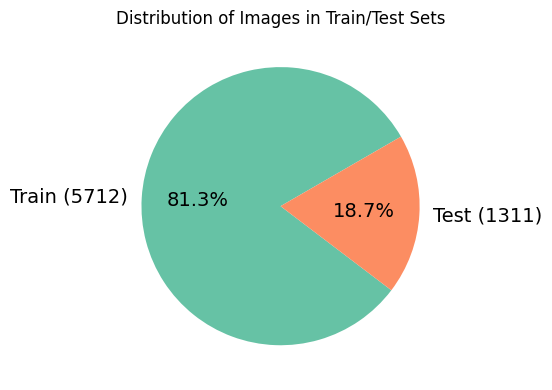

In [ ]:
## Data Label Distribution
# Define the labels for the dataset.
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Calculate the number of images for each label in the training set and calculate the percentage of images for each label.
label_counts = [train_labels.count(label) for label in labels]
total = sum(label_counts)
label_percentages = [count/total*100 for count in label_counts]

# Create a bar plot to show the distribution of images for each label in the training set.
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=label_counts, palette="Set2")
plt.title('Label Distribution (Training Set)')
plt.xlabel('Label')
plt.ylabel('Number of Images')
for i, count in enumerate(label_counts):
    plt.text(i, count+10, f"{label_percentages[i]:.1f}%", ha='center', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

## Data Split Distribution
# Calculate the number of images in the training and testing sets and create a pie chart to show the distribution.
labels = ['Train', 'Test']
colors = sns.color_palette("Set2", n_colors=2)
train_count = len(train_labels)
test_count = len(test_labels)
plt.figure(figsize=(6, 4))

# Create a pie plot to show the distribution of trianing and testing set images.
plt.pie([train_count, test_count], labels=[f'{l} ({c})' for l, c in zip(labels, [train_count, test_count])],
        colors=colors, autopct='%.1f%%',
        startangle=30, textprops={'fontsize': 14})
plt.title('Distribution of Images in Train/Test Sets')
sns.despine() 
plt.tight_layout()  
plt.show()



#3. **Preprocessing Data**

1. ImageDatset class
>This code defines a PyTorch Dataset class called ImageDataset that takes in image and label paths, loads the images and their corresponding labels using PIL, and applies specified image transformations. The labels are mapped to integer values for use in a classification model.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        Initializes an instance of the ImageDataset class.
        
        Args:
            image_paths (list): A list of file paths to the images.
            label_paths (list): A list of file paths to the corresponding labels.
            transform (callable): A callable object that applies a transformation to the images.
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Returns a tuple of an image and its corresponding label given an index.
        
        Args:
            index (int): The index of the image and label in their respective lists.
        
        Returns:
            tuple: A tuple of the image and label.
        """
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        image = Image.open(image_path)
        label = label_path

        if self.transform:
            image = self.transform(image)

        # Converting labels into integers
        if label == 'pituitary':
            label = 0
        elif label == 'notumor':
            label = 1
        elif label == 'meningioma':
            label = 2
        elif label == 'glioma':
            label = 3

        return image, label

 2. Dataset and Datloader Preparation
 >This code defines a transform and loads the image and label paths for the training and testing sets. It then creates ImageDataset and DataLoader objects for the training and testing sets with a specified transform and batch size.

In [ ]:
# Define the image transformations to be applied to the dataset.
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load the file paths for the training and testing sets.
image_paths_train = train_paths
label_paths_train = train_labels
image_paths_test = test_paths
label_paths_test = test_labels

# Create lists of tuples of image and label paths for the training and testing sets.
train_data = list(zip(image_paths_train, label_paths_train))
test_data = list(zip(image_paths_test, label_paths_test))

# Create ImageDataset objects for the training and testing sets using the lists of image and label paths and the transform.
train_dataset = ImageDataset([d[0] for d in train_data], [d[1] for d in train_data], transform=transform)
test_dataset = ImageDataset([d[0] for d in test_data], [d[1] for d in test_data], transform=transform)

augmented_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

def split_dataset(data, augment_ratio):
    num_augmented = int(len(data) * augment_ratio)
    augmented_data = data[:num_augmented]
    non_augmented_data = data[:]
    return augmented_data, non_augmented_data

# Split and create datasets for 20% augmentation ratio
train_data_augmented_20, train_data_non_augmented_20 = split_dataset(train_data, 0.2)
train_dataset_augmented_20 = ImageDataset([d[0] for d in train_data_augmented_20], [d[1] for d in train_data_augmented_20], transform=augmented_transform)
train_dataset_non_augmented_20 = ImageDataset([d[0] for d in train_data_non_augmented_20], [d[1] for d in train_data_non_augmented_20], transform=transform)

# Split and create datasets for 50% augmentation ratio
train_data_augmented_50, train_data_non_augmented_50 = split_dataset(train_data, 0.5)
train_dataset_augmented_50 = ImageDataset([d[0] for d in train_data_augmented_50], [d[1] for d in train_data_augmented_50], transform=augmented_transform)
train_dataset_non_augmented_50 = ImageDataset([d[0] for d in train_data_non_augmented_50], [d[1] for d in train_data_non_augmented_50], transform=transform)

batch_size = 16
# Create Original dataset and  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Combine datasets and create loaders for 20% augmentation ratio
train_dataset_combined_20 = ConcatDataset([train_dataset_augmented_20, train_dataset_non_augmented_20])
train_loader_combined_20 = DataLoader(train_dataset_combined_20, batch_size=batch_size, shuffle=True)

# Combine datasets and create loaders for 50% augmentation ratio
train_dataset_combined_50 = ConcatDataset([train_dataset_augmented_50, train_dataset_non_augmented_50])
train_loader_combined_50 = DataLoader(train_dataset_combined_50, batch_size=batch_size, shuffle=True)


3. Plotting Raw data and Pre-processed Data
>This code displays a 4x4 grid of sample images and their corresponding labels from the training set, as well as a 4x4 grid of preprocessed images and labels from the first batch of the training DataLoader. It uses matplotlib and PIL for image processing and visualization



Raw Data



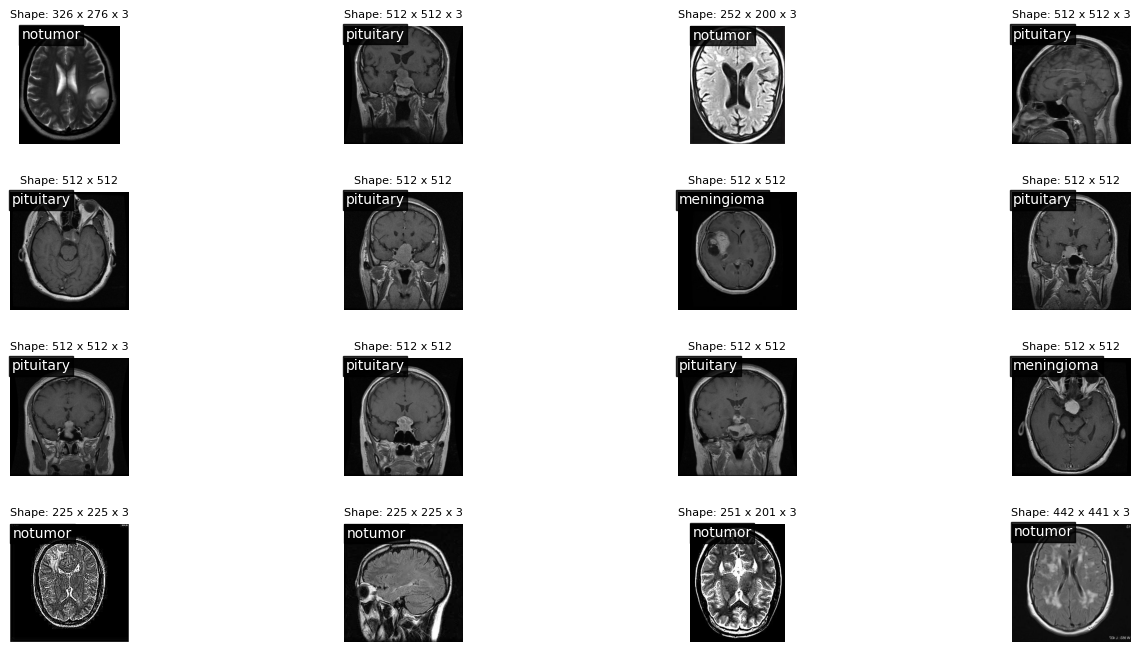





Preprocessed Data



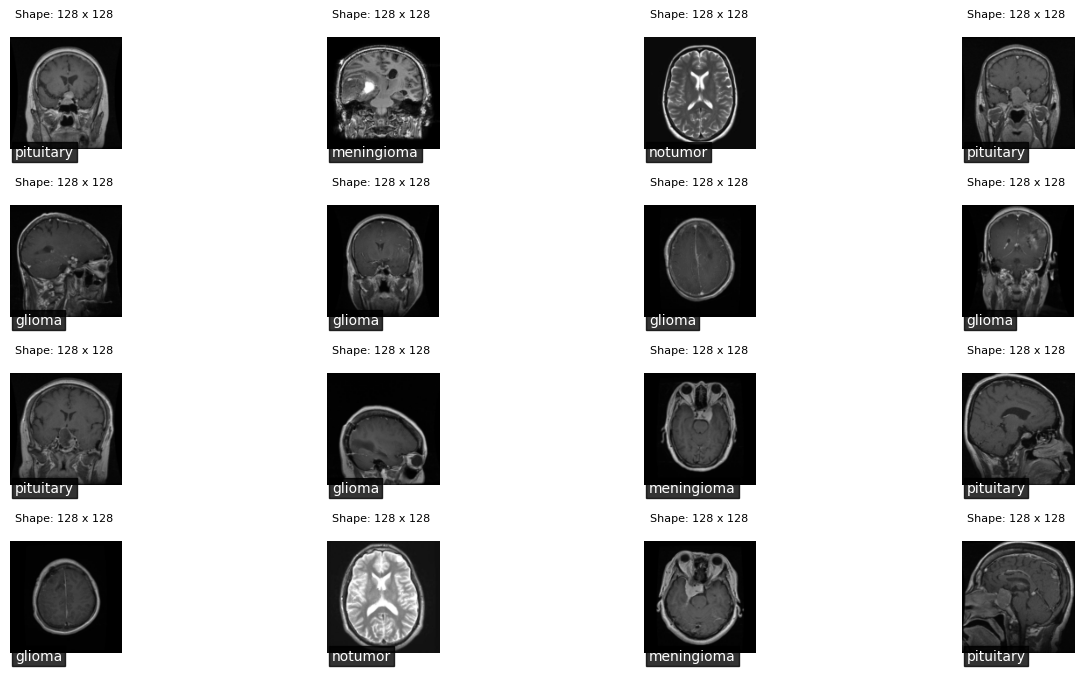

In [ ]:
# Raw Data
print('\n\nRaw Data\n')
image_paths = train_paths[:16]
label_paths = train_labels[:16]
data = list(zip(image_paths, label_paths))
random.shuffle(data)
num_rows = 4
num_cols = 4

#Subplots of 4x4 size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
for i, (image_path, label_path) in enumerate(data):

    with Image.open(image_path) as img:
        image = np.array(img)
    label = label_path
    row = i // num_cols
    col = i % num_cols
    if len(image.shape) == 3:
        height, width, channels = image.shape
        subtitle = f'Shape: {height} x {width} x {channels}'
    else:
        height, width = image.shape
        subtitle = f'Shape: {height} x {width}'
    axes[row, col].set_title(subtitle, fontsize=8)
    label_x, label_y = 5, 5
    axes[row, col].text(label_x, label_y, label, color='white', ha='left', va='top', fontsize=10,
                         bbox=dict(facecolor='black', alpha=0.8, pad=2))
    axes[row, col].imshow(image,cmap='gray')
    axes[row, col].axis('off')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


# Preprocessed data
print('\n\n\n\nPreprocessed Data\n')
images, labels = next(iter(train_loader))
label_dict = {0: 'pituitary', 1: 'notumor', 2: 'meningioma', 3: 'glioma'}
grid = np.transpose(images, (0, 2, 3, 1))

#Subplots of 4x4 size
fig, axs = plt.subplots(4, 4, figsize=(16, 8))
axs = axs.ravel()
for i in range(16):
    height, width, channels = grid[i].shape
    subtitle = f'Shape: {height} x {width} '
    axs[i].set_title(subtitle, fontsize=8, y=1.1)
    label = label_dict[labels[i].item()]
    label_x, label_y = 5, height - 5
    axs[i].text(label_x, label_y, label, color='white', ha='left', va='top', fontsize=10,
                 bbox=dict(facecolor='black', alpha=0.8, pad=2))

    axs[i].imshow(grid[i], vmin=0.0, vmax=1.0,cmap='gray')
    axs[i].axis('off')
plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()


#4. **Classification model(Resnet18) for different augmented datasets**

 Classification
>This code trains a ResNet-18 model on three different datasets: the original dataset, a dataset with a 20% augmentation, and a dataset with a 50% augmentation. The models are then trained, and the training/validation losses and accuracies are plotted to visualize the performance of each model on the different datasets.

In [ ]:
# Function to freeze model parameters for feature extraction
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Train loop
def train_model(model, train_loader, val_loader, num_epochs=10):
    # Move the model to the device
    model = model.to(device)
    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Set learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    # Initialize history variables
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    #Training Loop 
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            # Set model mode
            if phase == 'train':
                dataloader = train_loader
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                # Forward and backward passes
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Update running loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # Update history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

# Function to plot the training and validation history
def plot_history(train_loss, train_acc, val_loss, val_acc, title):
    epochs = range(1, len(train_loss) + 1)
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # Plot training and validation loss
    ax1.plot(epochs, train_loss, label='Training Loss')
    ax1.plot(epochs, val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Training and Validation Loss')
    ax1.legend()
    # Convert accuracy to NumPy arrays
    train_accuracy_np = [acc.cpu().numpy() for acc in train_acc]
    val_accuracy_np = [acc.cpu().numpy() for acc in val_acc]
    # Plot training and validation accuracy
    ax2.plot(epochs, train_accuracy_np, label='Training Accuracy')
    ax2.plot(epochs, val_accuracy_np, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Training and Validation Accuracy')
    ax2.legend()

    plt.show()

Epoch 1/10
----------


100%|██████████| 357/357 [00:38<00:00,  9.33it/s]


Train Loss: 0.7092 Acc: 0.7190


100%|██████████| 82/82 [00:05<00:00, 14.15it/s]


Val Loss: 0.6281 Acc: 0.7597
Epoch 2/10
----------


100%|██████████| 357/357 [00:38<00:00,  9.34it/s]


Train Loss: 0.4789 Acc: 0.8221


100%|██████████| 82/82 [00:06<00:00, 13.25it/s]


Val Loss: 0.5613 Acc: 0.7971
Epoch 3/10
----------


100%|██████████| 357/357 [00:38<00:00,  9.33it/s]


Train Loss: 0.4372 Acc: 0.8374


100%|██████████| 82/82 [00:05<00:00, 13.74it/s]


Val Loss: 0.4606 Acc: 0.8200
Epoch 4/10
----------


100%|██████████| 357/357 [00:38<00:00,  9.29it/s]


Train Loss: 0.3883 Acc: 0.8549


100%|██████████| 82/82 [00:06<00:00, 12.99it/s]


Val Loss: 0.4241 Acc: 0.8307
Epoch 5/10
----------


100%|██████████| 357/357 [00:37<00:00,  9.53it/s]


Train Loss: 0.3764 Acc: 0.8552


100%|██████████| 82/82 [00:06<00:00, 11.84it/s]


Val Loss: 0.3687 Acc: 0.8635
Epoch 6/10
----------


100%|██████████| 357/357 [00:36<00:00,  9.70it/s]


Train Loss: 0.3662 Acc: 0.8666


100%|██████████| 82/82 [00:07<00:00, 11.71it/s]


Val Loss: 0.4594 Acc: 0.8185
Epoch 7/10
----------


100%|██████████| 357/357 [00:37<00:00,  9.59it/s]


Train Loss: 0.3596 Acc: 0.8619


100%|██████████| 82/82 [00:07<00:00, 11.61it/s]


Val Loss: 0.3938 Acc: 0.8612
Epoch 8/10
----------


100%|██████████| 357/357 [00:36<00:00,  9.67it/s]


Train Loss: 0.3040 Acc: 0.8913


100%|██████████| 82/82 [00:06<00:00, 11.85it/s]


Val Loss: 0.3203 Acc: 0.8825
Epoch 9/10
----------


100%|██████████| 357/357 [00:37<00:00,  9.64it/s]


Train Loss: 0.2921 Acc: 0.8939


100%|██████████| 82/82 [00:07<00:00, 11.56it/s]


Val Loss: 0.3015 Acc: 0.8848
Epoch 10/10
----------


100%|██████████| 357/357 [00:37<00:00,  9.42it/s]


Train Loss: 0.2901 Acc: 0.8911


100%|██████████| 82/82 [00:06<00:00, 12.76it/s]


Val Loss: 0.3008 Acc: 0.8833


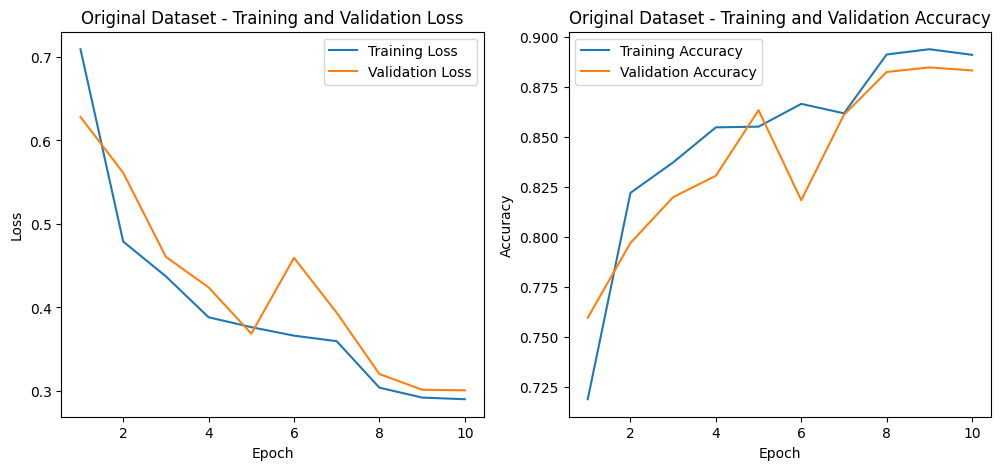

Epoch 1/10
----------


100%|██████████| 429/429 [00:46<00:00,  9.29it/s]


Train Loss: 0.6854 Acc: 0.7324


100%|██████████| 82/82 [00:07<00:00, 11.70it/s]


Val Loss: 0.5831 Acc: 0.7735
Epoch 2/10
----------


100%|██████████| 429/429 [00:45<00:00,  9.33it/s]


Train Loss: 0.5061 Acc: 0.8114


100%|██████████| 82/82 [00:05<00:00, 14.03it/s]


Val Loss: 0.4741 Acc: 0.8238
Epoch 3/10
----------


100%|██████████| 429/429 [00:47<00:00,  9.03it/s]


Train Loss: 0.4655 Acc: 0.8246


100%|██████████| 82/82 [00:05<00:00, 13.92it/s]


Val Loss: 0.3950 Acc: 0.8520
Epoch 4/10
----------


100%|██████████| 429/429 [00:45<00:00,  9.34it/s]


Train Loss: 0.4426 Acc: 0.8302


100%|██████████| 82/82 [00:07<00:00, 11.63it/s]


Val Loss: 0.4399 Acc: 0.8444
Epoch 5/10
----------


100%|██████████| 429/429 [00:46<00:00,  9.28it/s]


Train Loss: 0.4273 Acc: 0.8410


100%|██████████| 82/82 [00:06<00:00, 13.29it/s]


Val Loss: 0.4754 Acc: 0.8207
Epoch 6/10
----------


100%|██████████| 429/429 [00:47<00:00,  9.07it/s]


Train Loss: 0.4105 Acc: 0.8453


100%|██████████| 82/82 [00:05<00:00, 13.72it/s]


Val Loss: 0.4364 Acc: 0.8352
Epoch 7/10
----------


100%|██████████| 429/429 [00:45<00:00,  9.34it/s]


Train Loss: 0.3607 Acc: 0.8649


100%|██████████| 82/82 [00:07<00:00, 11.52it/s]


Val Loss: 0.3969 Acc: 0.8490
Epoch 8/10
----------


100%|██████████| 429/429 [00:45<00:00,  9.34it/s]


Train Loss: 0.3397 Acc: 0.8697


100%|██████████| 82/82 [00:06<00:00, 12.81it/s]


Val Loss: 0.3450 Acc: 0.8627
Epoch 9/10
----------


100%|██████████| 429/429 [00:47<00:00,  9.12it/s]


Train Loss: 0.3334 Acc: 0.8728


100%|██████████| 82/82 [00:05<00:00, 13.85it/s]


Val Loss: 0.3268 Acc: 0.8741
Epoch 10/10
----------


100%|██████████| 429/429 [00:45<00:00,  9.33it/s]


Train Loss: 0.3189 Acc: 0.8863


100%|██████████| 82/82 [00:07<00:00, 11.67it/s]


Val Loss: 0.3505 Acc: 0.8627


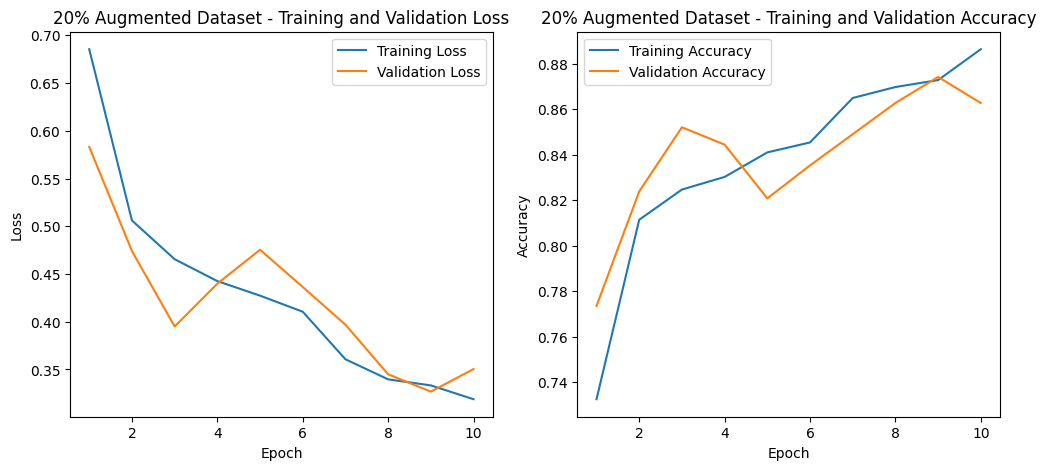

Epoch 1/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.04it/s]


Train Loss: 0.6898 Acc: 0.7233


100%|██████████| 82/82 [00:06<00:00, 12.88it/s]


Val Loss: 0.5775 Acc: 0.7941
Epoch 2/10
----------


100%|██████████| 536/536 [01:00<00:00,  8.87it/s]


Train Loss: 0.4909 Acc: 0.8135


100%|██████████| 82/82 [00:05<00:00, 13.74it/s]


Val Loss: 0.4139 Acc: 0.8429
Epoch 3/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.06it/s]


Train Loss: 0.4121 Acc: 0.8417


100%|██████████| 82/82 [00:07<00:00, 11.55it/s]


Val Loss: 0.4246 Acc: 0.8413
Epoch 4/10
----------


100%|██████████| 536/536 [00:58<00:00,  9.09it/s]


Train Loss: 0.3980 Acc: 0.8503


100%|██████████| 82/82 [00:05<00:00, 13.91it/s]


Val Loss: 0.4029 Acc: 0.8528
Epoch 5/10
----------


100%|██████████| 536/536 [00:58<00:00,  9.13it/s]


Train Loss: 0.3775 Acc: 0.8569


100%|██████████| 82/82 [00:07<00:00, 11.29it/s]


Val Loss: 0.4098 Acc: 0.8497
Epoch 6/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.06it/s]


Train Loss: 0.3786 Acc: 0.8543


100%|██████████| 82/82 [00:05<00:00, 13.80it/s]


Val Loss: 0.3973 Acc: 0.8574
Epoch 7/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.06it/s]


Train Loss: 0.3550 Acc: 0.8686


100%|██████████| 82/82 [00:06<00:00, 12.10it/s]


Val Loss: 0.4121 Acc: 0.8566
Epoch 8/10
----------


100%|██████████| 536/536 [00:58<00:00,  9.09it/s]


Train Loss: 0.3161 Acc: 0.8810


100%|██████████| 82/82 [00:06<00:00, 13.24it/s]


Val Loss: 0.2875 Acc: 0.9039
Epoch 9/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.02it/s]


Train Loss: 0.3004 Acc: 0.8860


100%|██████████| 82/82 [00:06<00:00, 13.05it/s]


Val Loss: 0.2843 Acc: 0.9062
Epoch 10/10
----------


100%|██████████| 536/536 [00:59<00:00,  9.06it/s]


Train Loss: 0.2971 Acc: 0.8899


100%|██████████| 82/82 [00:06<00:00, 12.14it/s]


Val Loss: 0.2824 Acc: 0.8970


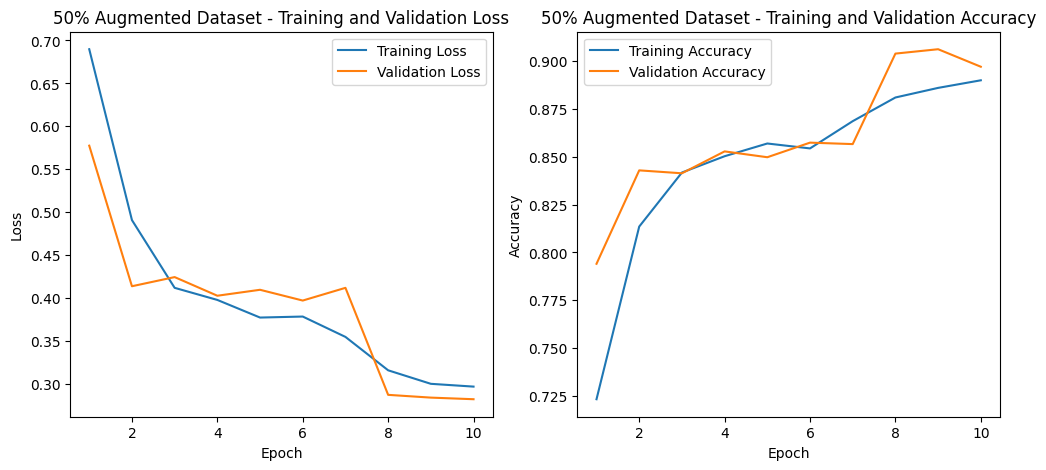

In [ ]:
# Instantiate and train the model with the original dataset
resnet18 = models.resnet18(pretrained=True)
set_parameter_requires_grad(resnet18, True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet18.fc.in_features
num_classes = 4
#Replacing the last fully connected layer with a new one
resnet18.fc = nn.Linear(num_ftrs, num_classes)

# Train the model with the original dataset and plot the history
train_loss_original, train_acc_original, val_loss_original, val_acc_original = train_model(resnet18, train_loader, test_loader)
plot_history(train_loss_original, train_acc_original, val_loss_original, val_acc_original, "Original Dataset")

# Instantiate and train the model with the 20% augmented dataset
resnet18_20 = models.resnet18(pretrained=True)
set_parameter_requires_grad(resnet18_20, True)
resnet18_20.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18_20.fc = nn.Linear(num_ftrs, num_classes)

# Train the model with the 20% augmented dataset and plot the history
train_loss_20, train_acc_20, val_loss_20, val_acc_20 = train_model(resnet18_20, train_loader_combined_20, test_loader)
plot_history(train_loss_20, train_acc_20, val_loss_20, val_acc_20, "20% Augmented Dataset")

# Instantiate and train the model with the 50% augmented dataset
resnet18_50 = models.resnet18(pretrained=True)
set_parameter_requires_grad(resnet18_50, True)
resnet18_50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18_50.fc = nn.Linear(num_ftrs, num_classes)

# Train the model with the 50% augmented dataset and plot the history
train_loss_50, train_acc_50, val_loss_50, val_acc_50 = train_model(resnet18_50, train_loader_combined_50, test_loader)
plot_history(train_loss_50, train_acc_50, val_loss_50, val_acc_50, "50% Augmented Dataset")



#5.  **Generative Models for Brain MRI Images**

##1. Variational Auto Encoder
>This code defines, trains, and evaluates a Variational Autoencoder (VAE) model. The VAE learns to encode input images into a lower-dimensional latent space and then reconstruct the images from the latent space. The training and testing losses are computed and displayed for each epoch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Define the Variational Autoencoder (VAE) class
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim):
        """
        Initializes an instance of the VAE class.
        
        Args:
            in_channels (int): The number of input channels in the input images.
            latent_dim (int): The size of the latent space.
        """
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        """
        Encodes an input image into the latent space.  
        Args:
            x (torch.Tensor): The input image.
        Returns:
            tuple: A tuple of the mean (mu) and log variance (logvar) of the latent distribution.
        """
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Samples a latent vector from the Gaussian distribution defined by mu and logvar using the reparameterization trick.
        Args:
            mu (torch.Tensor): The mean of the latent distribution.
            logvar (torch.Tensor): The log variance of the latent distribution.
        Returns:
            torch.Tensor: The sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decodes a latent vector into a reconstructed image.
        Args:
            z (torch.Tensor): The latent vector.
        Returns:
            torch.Tensor: The reconstructed image.
        """
        z = self.fc(z)
        z = z.view(-1, 256, 8, 8)
        return self.decoder(z)

    def forward(self, x):
        """
        Performs the forward pass of the VAE, encoding the input image and reconstructing it from the latent space.
        Args:
            x (torch.Tensor): The input image.
        Returns:
            tuple: A tuple of the reconstructed image, mu, and logvar.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Train, test and loss functions

In [ ]:
# Train the VAE model on the input images
def train_vae(model, dataloader, device, optimizer, criterion, mse_loss):
    model.train()
    running_loss = 0.0
    #Training Loop
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = model(inputs)
        loss = criterion(outputs, inputs, mu, logvar, mse_loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / (i + 1)


# Evaluate the VAE model on the test dataset
def test_vae(model, dataloader, device, criterion, mse_loss):
    model.eval()
    running_loss = 0.0
    #Eval loop
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader, 0)):
            inputs, _ = data
            inputs = inputs.to(device)
            outputs, mu, logvar = model(inputs)
            loss = criterion(outputs, inputs, mu, logvar, mse_loss)
            running_loss += loss.item()

    return running_loss / (i + 1)

# Compute the VAE loss, combining reconstruction and KL-divergence losses
def vae_loss(output, target, mu, logvar, mse_loss):

    #KL divergence vs reconstruction_loss
    reconstruction_loss = mse_loss(output, target)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= target.size(0) * 128 * 128
    return reconstruction_loss + kld



Trianing for 10 epochs

In [ ]:
# Prepare the device, model, and optimizer
in_channels = 1
latent_dim = 64
epochs = 10

#Initializaing the model
vae = VAE(in_channels, latent_dim).to(device)

#Optimizer and loss
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss(reduction='sum')

# Storring loss values for train and evaluation
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train_vae(vae, train_loader, device, optimizer, vae_loss, mse_loss)
    test_loss = test_vae(vae, test_loader, device, vae_loss, mse_loss)

    with torch.no_grad():
        real_images = torch.cat([x[0] for x in test_dataset], dim=0).unsqueeze(1)
        latent_samples = torch.randn(real_images.size(0), latent_dim).to(device)
        generated_images = vae.decode(latent_samples)

    train_losses.append(train_loss)
    test_losses.append(test_loss)


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#Saving the model for 10 epochs
torch.save(vae.state_dict(), "vae_brain_mri_10epochs.pt")


357it [00:36,  9.65it/s]
82it [00:06, 13.63it/s]


Epoch 1/10, Train Loss: 6020.4828, Test Loss: 4418.9844


357it [00:36,  9.91it/s]
82it [00:06, 12.04it/s]


Epoch 2/10, Train Loss: 3667.8188, Test Loss: 3795.9836


357it [00:41,  8.64it/s]
82it [00:06, 12.56it/s]


Epoch 3/10, Train Loss: 3168.2114, Test Loss: 3374.9742


357it [00:36,  9.77it/s]
82it [00:06, 12.70it/s]


Epoch 4/10, Train Loss: 2795.0892, Test Loss: 2882.8444


357it [00:36,  9.67it/s]
82it [00:07, 10.89it/s]


Epoch 5/10, Train Loss: 2568.1952, Test Loss: 2694.0035


357it [00:42,  8.37it/s]
82it [00:06, 13.05it/s]


Epoch 6/10, Train Loss: 2362.2806, Test Loss: 2465.2481


357it [00:36,  9.78it/s]
82it [00:06, 12.65it/s]


Epoch 7/10, Train Loss: 2224.9234, Test Loss: 2426.5255


357it [00:37,  9.60it/s]
82it [00:06, 13.01it/s]


Epoch 8/10, Train Loss: 2093.8660, Test Loss: 2162.9397


357it [00:36,  9.70it/s]
82it [00:06, 12.82it/s]


Epoch 9/10, Train Loss: 1959.9131, Test Loss: 2234.0744


357it [00:36,  9.70it/s]
82it [00:06, 13.09it/s]


Epoch 10/10, Train Loss: 1856.4039, Test Loss: 1949.0158


Sampling for 10 epochs

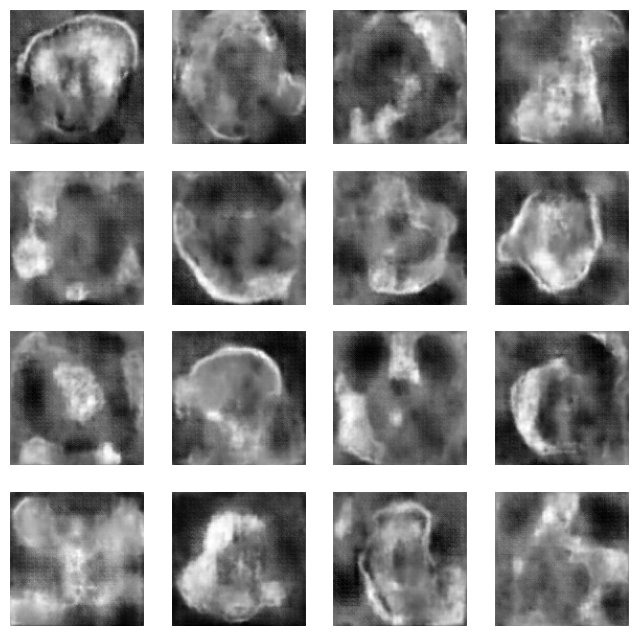

In [ ]:
#Sampling the images generated after 10 epochs
vae.eval()
with torch.no_grad():
    latent_samples = torch.randn(16, latent_dim).to(device)
    generated_images = vae.decode(latent_samples)

#Plotting the images generated after 10 epochs
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


Training for 20 additional epochs

In [ ]:
additional_epochs = 20
total_epochs = epochs + additional_epochs

for epoch in range(epochs, total_epochs):
    train_loss = train_vae(vae, train_loader, device, optimizer, vae_loss, mse_loss)
    test_loss = test_vae(vae, test_loader, device, vae_loss, mse_loss)

    with torch.no_grad():
        real_images = torch.cat([x[0] for x in test_dataset], dim=0).unsqueeze(1)
        latent_samples = torch.randn(real_images.size(0), latent_dim).to(device)
        generated_images = vae.decode(latent_samples)

    #Appending losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)


    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
#Saving the model for 20 more epochs
torch.save(vae.state_dict(), "vae_brain_mri_30epochs.pt")


357it [00:37,  9.60it/s]
82it [00:06, 13.51it/s]


Epoch 11/30, Train Loss: 1761.3387, Test Loss: 1860.1970


357it [00:37,  9.65it/s]
82it [00:06, 11.87it/s]


Epoch 12/30, Train Loss: 1687.8766, Test Loss: 1800.4875


357it [00:36,  9.71it/s]
82it [00:06, 12.84it/s]


Epoch 13/30, Train Loss: 1615.0525, Test Loss: 1736.9680


357it [00:36,  9.91it/s]
82it [00:07, 10.94it/s]


Epoch 14/30, Train Loss: 1583.6333, Test Loss: 1663.2304


357it [00:36,  9.68it/s]
82it [00:06, 11.79it/s]


Epoch 15/30, Train Loss: 1502.1579, Test Loss: 1579.1138


357it [00:36,  9.70it/s]
82it [00:06, 12.91it/s]


Epoch 16/30, Train Loss: 1440.8283, Test Loss: 1555.2705


357it [00:36,  9.72it/s]
82it [00:06, 13.00it/s]


Epoch 17/30, Train Loss: 1414.2878, Test Loss: 1509.5867


357it [00:36,  9.84it/s]
82it [00:06, 12.76it/s]


Epoch 18/30, Train Loss: 1365.4783, Test Loss: 1489.1091


357it [00:36,  9.71it/s]
82it [00:06, 13.01it/s]


Epoch 19/30, Train Loss: 1324.2261, Test Loss: 1428.3070


357it [00:36,  9.86it/s]
82it [00:06, 12.43it/s]


Epoch 20/30, Train Loss: 1302.0057, Test Loss: 1406.9300


357it [00:37,  9.64it/s]
82it [00:06, 13.59it/s]


Epoch 21/30, Train Loss: 1265.3989, Test Loss: 1358.7189


357it [00:36,  9.77it/s]
82it [00:06, 12.45it/s]


Epoch 22/30, Train Loss: 1227.6355, Test Loss: 1354.0916


357it [00:36,  9.69it/s]
82it [00:06, 13.54it/s]


Epoch 23/30, Train Loss: 1205.5443, Test Loss: 1332.1163


357it [00:36,  9.88it/s]
82it [00:06, 12.30it/s]


Epoch 24/30, Train Loss: 1192.7715, Test Loss: 1298.2838


357it [00:36,  9.72it/s]
82it [00:06, 13.63it/s]


Epoch 25/30, Train Loss: 1171.7742, Test Loss: 1278.9575


357it [00:35,  9.94it/s]
82it [00:06, 11.95it/s]


Epoch 26/30, Train Loss: 1135.4760, Test Loss: 1265.4207


357it [00:36,  9.70it/s]
82it [00:06, 13.37it/s]


Epoch 27/30, Train Loss: 1124.6812, Test Loss: 1246.9294


357it [00:41,  8.54it/s]
82it [00:10,  8.05it/s]


Epoch 28/30, Train Loss: 1110.8245, Test Loss: 1236.6010


357it [00:37,  9.63it/s]
82it [00:06, 13.15it/s]


Epoch 29/30, Train Loss: 1084.4216, Test Loss: 1227.6720


357it [00:36,  9.72it/s]
82it [00:06, 12.30it/s]


Epoch 30/30, Train Loss: 1078.8959, Test Loss: 1219.9747


Sampling for 20 additional epochs

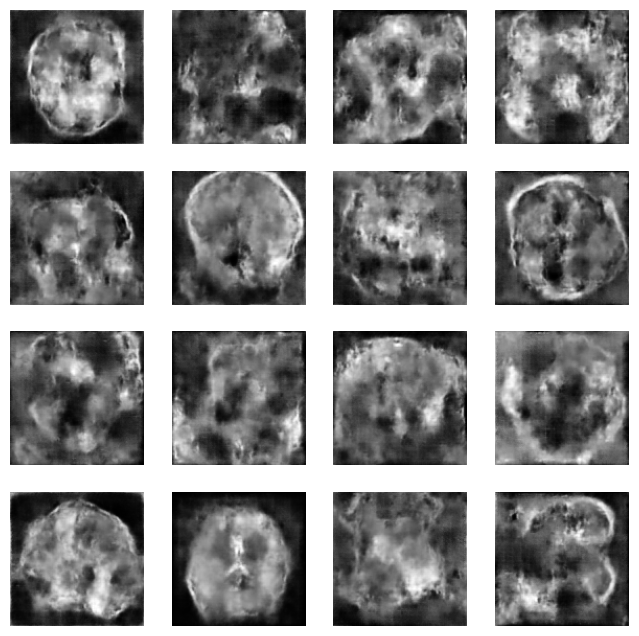

In [ ]:
# Sampling the generated images after 20 more epochs
vae.eval()
with torch.no_grad():
    latent_samples = torch.randn(16, latent_dim).to(device)
    generated_images = vae.decode(latent_samples)

# Plot the generated images after 20 more epochs
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


Plotting loss vs epochs

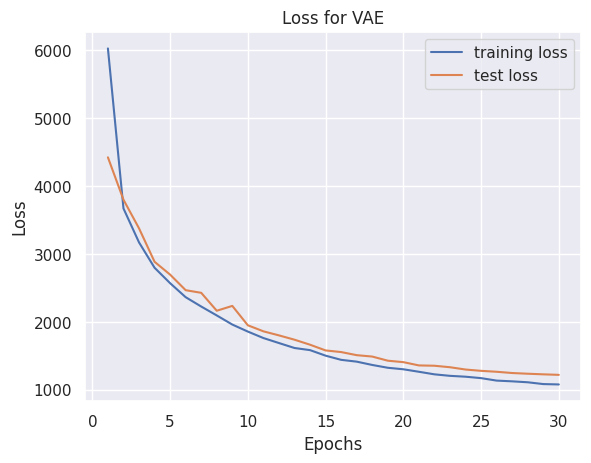

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses,label='training loss')
plt.plot(range(1,len(test_losses)+1),test_losses,label='test loss')
plt.title('Loss for VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##2. Generative Adversarial Networks

In [ ]:

# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128 * 32 * 32),
            nn.ReLU(),
            nn.BatchNorm1d(128 * 32 * 32),
            nn.Unflatten(1, (128, 32, 32)),
            # Transposed convolution layer to upsample feature maps
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1)
        )

    def forward(self, x):
        return self.model(x)

Training for 100 epochs

In [ ]:


# Initialize the networks
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Define the loss function and optimizers
criterion = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, _) in tqdm(enumerate(train_loader)):
        real_images = images.cuda()

        # Train discriminator
        optimizer_D.zero_grad()
        # Create real and fake labels for the discriminator loss
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()

        # Compute the discriminator loss for real images
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)

        # Generate fake images using the generator
        noise = torch.randn(real_images.size(0), 100).cuda()
        fake_images = generator(noise)

        # Compute the discriminator loss for fake images
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()

        g_outputs = discriminator(fake_images)
        g_loss = criterion(g_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], D_Loss: {d_loss.item()}, G_Loss: {g_loss.item()}")

    # Save generated images
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            # Generate 16 images using random noise
            noise = torch.randn(16, 100).cuda()
            generated_images = generator(noise)
            torchvision.utils.save_image(generated_images, f'generated_samples_epoch_{epoch + 1}.png', normalize=True)

# Save the trained generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


100it [14:11,  7.16s/it]

Epoch [1/100], Step [100/357], D_Loss: 2.5008342266082764, G_Loss: 0.7831534147262573


200it [28:20,  9.28s/it]

Epoch [1/100], Step [200/357], D_Loss: 2.3190016746520996, G_Loss: 1.4783439636230469


300it [42:50,  8.46s/it]

Epoch [1/100], Step [300/357], D_Loss: 3.607902765274048, G_Loss: 2.1291141510009766


357it [50:43,  8.53s/it]
100it [00:08, 11.00it/s]

Epoch [2/100], Step [100/357], D_Loss: 2.417710542678833, G_Loss: 2.4523563385009766


201it [00:18, 10.67it/s]

Epoch [2/100], Step [200/357], D_Loss: 2.517977714538574, G_Loss: 2.9839444160461426


301it [00:28, 11.09it/s]

Epoch [2/100], Step [300/357], D_Loss: 1.1157009601593018, G_Loss: 0.40869975090026855


357it [00:32, 10.84it/s]
102it [00:09, 11.64it/s]

Epoch [3/100], Step [100/357], D_Loss: 1.4163109064102173, G_Loss: 2.3309383392333984


200it [00:18, 11.30it/s]

Epoch [3/100], Step [200/357], D_Loss: 0.8993806838989258, G_Loss: 0.4917360246181488


302it [00:28, 11.64it/s]

Epoch [3/100], Step [300/357], D_Loss: 2.2373545169830322, G_Loss: 0.982616662979126


357it [00:33, 10.76it/s]
102it [00:09, 11.51it/s]

Epoch [4/100], Step [100/357], D_Loss: 7.771101474761963, G_Loss: 2.125502586364746


202it [00:19, 12.02it/s]

Epoch [4/100], Step [200/357], D_Loss: 1.671278953552246, G_Loss: 1.3143749237060547


301it [00:28,  9.10it/s]

Epoch [4/100], Step [300/357], D_Loss: 2.009143829345703, G_Loss: 1.770462155342102


357it [00:34, 10.36it/s]
101it [00:09,  7.36it/s]

Epoch [5/100], Step [100/357], D_Loss: 1.844319224357605, G_Loss: 0.642972469329834


201it [00:18, 11.72it/s]

Epoch [5/100], Step [200/357], D_Loss: 1.1338257789611816, G_Loss: 1.4336633682250977


302it [00:28, 11.08it/s]

Epoch [5/100], Step [300/357], D_Loss: 7.771827220916748, G_Loss: 0.41472288966178894


357it [00:33, 10.77it/s]
101it [00:09, 10.85it/s]

Epoch [6/100], Step [100/357], D_Loss: 1.1045477390289307, G_Loss: 1.1798040866851807


201it [00:18,  7.86it/s]

Epoch [6/100], Step [200/357], D_Loss: 4.844472885131836, G_Loss: 0.7881453037261963


302it [00:28, 11.47it/s]

Epoch [6/100], Step [300/357], D_Loss: 2.1890108585357666, G_Loss: 1.0265083312988281


357it [00:33, 10.78it/s]
102it [00:09, 11.68it/s]

Epoch [7/100], Step [100/357], D_Loss: 1.1552640199661255, G_Loss: 1.2100143432617188


202it [00:18, 12.26it/s]

Epoch [7/100], Step [200/357], D_Loss: 5.814768314361572, G_Loss: 0.3239034116268158


302it [00:27,  9.11it/s]

Epoch [7/100], Step [300/357], D_Loss: 1.2710645198822021, G_Loss: 1.9472582340240479


357it [00:33, 10.79it/s]
101it [00:08,  8.31it/s]

Epoch [8/100], Step [100/357], D_Loss: 9.308326721191406, G_Loss: 3.956974983215332


201it [00:18, 11.75it/s]

Epoch [8/100], Step [200/357], D_Loss: 4.403249740600586, G_Loss: 0.6632089614868164


302it [00:27, 12.21it/s]

Epoch [8/100], Step [300/357], D_Loss: 2.5899810791015625, G_Loss: 0.24312825500965118


357it [00:32, 11.11it/s]
101it [00:09, 11.54it/s]

Epoch [9/100], Step [100/357], D_Loss: 1.646372675895691, G_Loss: 2.381643295288086


201it [00:18,  9.25it/s]

Epoch [9/100], Step [200/357], D_Loss: 4.101480960845947, G_Loss: 2.937936305999756


302it [00:28, 11.39it/s]

Epoch [9/100], Step [300/357], D_Loss: 0.865628719329834, G_Loss: 0.5997216701507568


357it [00:33, 10.77it/s]
101it [00:09, 11.54it/s]

Epoch [10/100], Step [100/357], D_Loss: 2.8844919204711914, G_Loss: 0.1428634375333786


202it [00:19, 11.53it/s]

Epoch [10/100], Step [200/357], D_Loss: 2.2170157432556152, G_Loss: 0.4497304856777191


300it [00:27, 10.36it/s]

Epoch [10/100], Step [300/357], D_Loss: 5.778540134429932, G_Loss: 1.1537294387817383


357it [00:33, 10.63it/s]
101it [00:08,  8.62it/s]

Epoch [11/100], Step [100/357], D_Loss: 1.2710777521133423, G_Loss: 2.377509593963623


202it [00:18, 10.93it/s]

Epoch [11/100], Step [200/357], D_Loss: 13.526113510131836, G_Loss: 15.341096878051758


301it [00:28, 11.35it/s]

Epoch [11/100], Step [300/357], D_Loss: 1.2778970003128052, G_Loss: 0.9405351281166077


357it [00:32, 10.84it/s]
101it [00:09, 11.44it/s]

Epoch [12/100], Step [100/357], D_Loss: 1.5067651271820068, G_Loss: 0.4486050307750702


201it [00:18,  8.15it/s]

Epoch [12/100], Step [200/357], D_Loss: 1.1486966609954834, G_Loss: 0.0745447650551796


301it [00:28, 12.12it/s]

Epoch [12/100], Step [300/357], D_Loss: 0.9571080207824707, G_Loss: 0.30154502391815186


357it [00:33, 10.76it/s]
101it [00:09, 12.02it/s]

Epoch [13/100], Step [100/357], D_Loss: 3.944974899291992, G_Loss: 0.30747556686401367


201it [00:19, 11.19it/s]

Epoch [13/100], Step [200/357], D_Loss: 1.843679666519165, G_Loss: 3.327535629272461


301it [00:28,  8.26it/s]

Epoch [13/100], Step [300/357], D_Loss: 1.570152997970581, G_Loss: 0.6726430654525757


357it [00:33, 10.58it/s]
100it [00:09,  7.85it/s]

Epoch [14/100], Step [100/357], D_Loss: 2.535295248031616, G_Loss: 3.7515957355499268


201it [00:18, 11.53it/s]

Epoch [14/100], Step [200/357], D_Loss: 1.4628828763961792, G_Loss: 0.6540015339851379


302it [00:28, 11.52it/s]

Epoch [14/100], Step [300/357], D_Loss: 1.3586119413375854, G_Loss: 0.23757654428482056


357it [00:32, 10.85it/s]
101it [00:09, 11.67it/s]

Epoch [15/100], Step [100/357], D_Loss: 1.6276183128356934, G_Loss: 0.6237607002258301


201it [00:18,  8.46it/s]

Epoch [15/100], Step [200/357], D_Loss: 2.6897988319396973, G_Loss: 0.1723388433456421


302it [00:27, 11.60it/s]

Epoch [15/100], Step [300/357], D_Loss: 7.222442626953125, G_Loss: 10.14289379119873


357it [00:32, 10.85it/s]
101it [00:09, 11.44it/s]

Epoch [16/100], Step [100/357], D_Loss: 1.1883114576339722, G_Loss: 0.24194012582302094


201it [00:18, 11.34it/s]

Epoch [16/100], Step [200/357], D_Loss: 0.6691097021102905, G_Loss: 1.8208940029144287


301it [00:27,  8.21it/s]

Epoch [16/100], Step [300/357], D_Loss: 2.48785662651062, G_Loss: 4.864475250244141


357it [00:32, 10.93it/s]
101it [00:08,  8.66it/s]

Epoch [17/100], Step [100/357], D_Loss: 0.7567101716995239, G_Loss: 0.9507244825363159


201it [00:17, 12.39it/s]

Epoch [17/100], Step [200/357], D_Loss: 1.495922327041626, G_Loss: 0.3693445324897766


301it [00:27, 11.45it/s]

Epoch [17/100], Step [300/357], D_Loss: 6.880457878112793, G_Loss: 3.848452091217041


357it [00:31, 11.27it/s]
102it [00:09, 10.98it/s]

Epoch [18/100], Step [100/357], D_Loss: 1.1637516021728516, G_Loss: 0.33872008323669434


202it [00:17, 12.01it/s]

Epoch [18/100], Step [200/357], D_Loss: 1.7428922653198242, G_Loss: 0.08681035041809082


301it [00:27, 12.33it/s]

Epoch [18/100], Step [300/357], D_Loss: 2.622605800628662, G_Loss: 4.337273120880127


357it [00:31, 11.29it/s]
101it [00:09, 12.48it/s]

Epoch [19/100], Step [100/357], D_Loss: 1.1552585363388062, G_Loss: 1.5526480674743652


201it [00:18,  9.17it/s]

Epoch [19/100], Step [200/357], D_Loss: 3.992340087890625, G_Loss: 4.534239292144775


301it [00:27, 11.26it/s]

Epoch [19/100], Step [300/357], D_Loss: 0.9412508606910706, G_Loss: 2.8570327758789062


357it [00:32, 10.91it/s]
102it [00:08, 11.77it/s]

Epoch [20/100], Step [100/357], D_Loss: 1.0225220918655396, G_Loss: 1.458174228668213


202it [00:17, 12.14it/s]

Epoch [20/100], Step [200/357], D_Loss: 0.5696009397506714, G_Loss: 0.16770678758621216


301it [00:26,  8.15it/s]

Epoch [20/100], Step [300/357], D_Loss: 0.4979715943336487, G_Loss: 0.8495992422103882


357it [00:31, 11.26it/s]
101it [00:09,  8.84it/s]

Epoch [21/100], Step [100/357], D_Loss: 0.3575327396392822, G_Loss: 1.3432644605636597


202it [00:17, 12.30it/s]

Epoch [21/100], Step [200/357], D_Loss: 0.9207547903060913, G_Loss: 3.5552010536193848


301it [00:27, 12.17it/s]

Epoch [21/100], Step [300/357], D_Loss: 0.8462404012680054, G_Loss: 2.9367833137512207


357it [00:31, 11.26it/s]
101it [00:09, 12.42it/s]

Epoch [22/100], Step [100/357], D_Loss: 0.5810447335243225, G_Loss: 1.139237642288208


201it [00:17,  8.68it/s]

Epoch [22/100], Step [200/357], D_Loss: 116.46996307373047, G_Loss: 11.409992218017578


301it [00:27, 11.65it/s]

Epoch [22/100], Step [300/357], D_Loss: 9.573719024658203, G_Loss: 3.077303886413574


357it [00:32, 11.12it/s]
101it [00:09, 12.24it/s]

Epoch [23/100], Step [100/357], D_Loss: 4.014167785644531, G_Loss: 1.9909849166870117


201it [00:18, 11.60it/s]

Epoch [23/100], Step [200/357], D_Loss: 4.391534805297852, G_Loss: 1.2813749313354492


301it [00:27,  9.82it/s]

Epoch [23/100], Step [300/357], D_Loss: 1.4513736963272095, G_Loss: 1.645189881324768


357it [00:32, 10.82it/s]
100it [00:08, 10.62it/s]

Epoch [24/100], Step [100/357], D_Loss: 1.03398597240448, G_Loss: 0.9798353910446167


201it [00:17, 12.06it/s]

Epoch [24/100], Step [200/357], D_Loss: 2.189112663269043, G_Loss: 3.3898239135742188


301it [00:27, 10.90it/s]

Epoch [24/100], Step [300/357], D_Loss: 2.0064568519592285, G_Loss: 0.09928994625806808


357it [00:31, 11.29it/s]
101it [00:09, 11.02it/s]

Epoch [25/100], Step [100/357], D_Loss: 0.7004826068878174, G_Loss: 2.265920639038086


201it [00:17, 12.21it/s]

Epoch [25/100], Step [200/357], D_Loss: 0.9978410005569458, G_Loss: 1.3843638896942139


302it [00:27, 11.21it/s]

Epoch [25/100], Step [300/357], D_Loss: 2.0648133754730225, G_Loss: 1.9843305349349976


357it [00:31, 11.25it/s]
102it [00:09, 11.82it/s]

Epoch [26/100], Step [100/357], D_Loss: 3.3401637077331543, G_Loss: 5.173872947692871


202it [00:19,  9.93it/s]

Epoch [26/100], Step [200/357], D_Loss: 1.1800254583358765, G_Loss: 1.174196720123291


302it [00:27, 11.83it/s]

Epoch [26/100], Step [300/357], D_Loss: 0.979070246219635, G_Loss: 2.220026969909668


357it [00:33, 10.77it/s]
102it [00:08, 11.92it/s]

Epoch [27/100], Step [100/357], D_Loss: 9.271936416625977, G_Loss: 1.7611896991729736


201it [00:17, 11.34it/s]

Epoch [27/100], Step [200/357], D_Loss: 1.2250308990478516, G_Loss: 1.1076819896697998


301it [00:26,  8.13it/s]

Epoch [27/100], Step [300/357], D_Loss: 0.7831632494926453, G_Loss: 0.7001798152923584


357it [00:31, 11.34it/s]
101it [00:09,  7.38it/s]

Epoch [28/100], Step [100/357], D_Loss: 1.5011554956436157, G_Loss: 0.20494036376476288


202it [00:17, 12.20it/s]

Epoch [28/100], Step [200/357], D_Loss: 2.4366767406463623, G_Loss: 4.097380638122559


302it [00:27, 13.15it/s]

Epoch [28/100], Step [300/357], D_Loss: 4.791119575500488, G_Loss: 9.429658889770508


357it [00:31, 11.24it/s]
102it [00:09, 10.78it/s]

Epoch [29/100], Step [100/357], D_Loss: 5.62626838684082, G_Loss: 0.163377583026886


202it [00:18,  9.26it/s]

Epoch [29/100], Step [200/357], D_Loss: 1.4733037948608398, G_Loss: 0.7434296607971191


302it [00:27, 11.92it/s]

Epoch [29/100], Step [300/357], D_Loss: 0.7446832060813904, G_Loss: 1.6945664882659912


357it [00:32, 10.96it/s]
102it [00:09, 11.86it/s]

Epoch [30/100], Step [100/357], D_Loss: 0.38934803009033203, G_Loss: 0.6466008424758911


201it [00:18, 10.75it/s]

Epoch [30/100], Step [200/357], D_Loss: 0.9345767498016357, G_Loss: 0.7508391737937927


301it [00:26, 11.57it/s]

Epoch [30/100], Step [300/357], D_Loss: 1.0055065155029297, G_Loss: 1.0791914463043213


357it [00:32, 11.00it/s]
100it [00:08, 12.07it/s]

Epoch [31/100], Step [100/357], D_Loss: 1.1135390996932983, G_Loss: 1.45198392868042


202it [00:17, 11.56it/s]

Epoch [31/100], Step [200/357], D_Loss: 1.7822173833847046, G_Loss: 0.5295493006706238


301it [00:27, 11.39it/s]

Epoch [31/100], Step [300/357], D_Loss: 0.7815994024276733, G_Loss: 0.9129486083984375


357it [00:31, 11.23it/s]
102it [00:09, 11.61it/s]

Epoch [32/100], Step [100/357], D_Loss: 1.2714970111846924, G_Loss: 0.3494042456150055


202it [00:17, 11.96it/s]

Epoch [32/100], Step [200/357], D_Loss: 6.644083499908447, G_Loss: 5.429783821105957


302it [00:27, 12.07it/s]

Epoch [32/100], Step [300/357], D_Loss: 23.294883728027344, G_Loss: 7.126492023468018


357it [00:31, 11.27it/s]
101it [00:09, 11.65it/s]

Epoch [33/100], Step [100/357], D_Loss: 1.1703197956085205, G_Loss: 0.8601619601249695


202it [00:19, 10.56it/s]

Epoch [33/100], Step [200/357], D_Loss: 3.331367254257202, G_Loss: 4.699391841888428


302it [00:27, 11.74it/s]

Epoch [33/100], Step [300/357], D_Loss: 3.578572988510132, G_Loss: 0.23443764448165894


357it [00:33, 10.56it/s]
102it [00:08, 11.59it/s]

Epoch [34/100], Step [100/357], D_Loss: 0.9447784423828125, G_Loss: 3.785536766052246


201it [00:17, 11.82it/s]

Epoch [34/100], Step [200/357], D_Loss: 1.259704351425171, G_Loss: 0.3898880183696747


301it [00:27,  7.39it/s]

Epoch [34/100], Step [300/357], D_Loss: 1.9568846225738525, G_Loss: 1.61686110496521


357it [00:32, 11.06it/s]
101it [00:09,  7.63it/s]

Epoch [35/100], Step [100/357], D_Loss: 3.4321560859680176, G_Loss: 0.1673603504896164


202it [00:18, 11.76it/s]

Epoch [35/100], Step [200/357], D_Loss: 1.024450659751892, G_Loss: 0.29290539026260376


301it [00:28, 11.85it/s]

Epoch [35/100], Step [300/357], D_Loss: 1.2073521614074707, G_Loss: 1.469212532043457


357it [00:32, 10.87it/s]
101it [00:09, 12.32it/s]

Epoch [36/100], Step [100/357], D_Loss: 10.184046745300293, G_Loss: 2.228985548019409


201it [00:19,  8.19it/s]

Epoch [36/100], Step [200/357], D_Loss: 1.879324197769165, G_Loss: 1.986243724822998


302it [00:27, 11.89it/s]

Epoch [36/100], Step [300/357], D_Loss: 8.096513748168945, G_Loss: 0.23782780766487122


357it [00:33, 10.72it/s]
102it [00:08, 12.93it/s]

Epoch [37/100], Step [100/357], D_Loss: 0.4936321973800659, G_Loss: 1.0566515922546387


201it [00:17, 11.81it/s]

Epoch [37/100], Step [200/357], D_Loss: 0.9009731411933899, G_Loss: 1.316410779953003


301it [00:26,  7.85it/s]

Epoch [37/100], Step [300/357], D_Loss: 0.7500935196876526, G_Loss: 0.32824283838272095


357it [00:31, 11.23it/s]
101it [00:08,  8.49it/s]

Epoch [38/100], Step [100/357], D_Loss: 0.5265910625457764, G_Loss: 0.4549461305141449


202it [00:17, 12.07it/s]

Epoch [38/100], Step [200/357], D_Loss: 0.4131213426589966, G_Loss: 1.2541980743408203


302it [00:26, 11.39it/s]

Epoch [38/100], Step [300/357], D_Loss: 0.34150657057762146, G_Loss: 0.6237508058547974


357it [00:31, 11.39it/s]
102it [00:09, 11.71it/s]

Epoch [39/100], Step [100/357], D_Loss: 1.5043010711669922, G_Loss: 2.469451665878296


200it [00:17, 12.46it/s]

Epoch [39/100], Step [200/357], D_Loss: 0.3424757122993469, G_Loss: 1.2189953327178955


301it [00:27, 11.35it/s]

Epoch [39/100], Step [300/357], D_Loss: 0.5482277870178223, G_Loss: 1.454778790473938


357it [00:31, 11.18it/s]
101it [00:09, 11.34it/s]

Epoch [40/100], Step [100/357], D_Loss: 3.0295767784118652, G_Loss: 4.5457444190979


201it [00:18, 10.84it/s]

Epoch [40/100], Step [200/357], D_Loss: 2.256373882293701, G_Loss: 0.06796810030937195


301it [00:27, 11.34it/s]

Epoch [40/100], Step [300/357], D_Loss: 0.7790973782539368, G_Loss: 0.8738667964935303


357it [00:32, 10.82it/s]
102it [00:08, 11.47it/s]

Epoch [41/100], Step [100/357], D_Loss: 0.7992454171180725, G_Loss: 0.44267627596855164


202it [00:18, 10.98it/s]

Epoch [41/100], Step [200/357], D_Loss: 1.1272153854370117, G_Loss: 1.4747897386550903


302it [00:27, 12.10it/s]

Epoch [41/100], Step [300/357], D_Loss: 3.6843321323394775, G_Loss: 3.365445375442505


357it [00:32, 11.03it/s]
101it [00:09, 11.30it/s]

Epoch [42/100], Step [100/357], D_Loss: 1.125542402267456, G_Loss: 0.35360801219940186


201it [00:17, 12.24it/s]

Epoch [42/100], Step [200/357], D_Loss: 0.6426233053207397, G_Loss: 0.5387209057807922


301it [00:27, 11.00it/s]

Epoch [42/100], Step [300/357], D_Loss: 0.9648268222808838, G_Loss: 0.26657378673553467


357it [00:31, 11.19it/s]
102it [00:09, 12.24it/s]

Epoch [43/100], Step [100/357], D_Loss: 3.0988316535949707, G_Loss: 0.27130046486854553


202it [00:18,  8.83it/s]

Epoch [43/100], Step [200/357], D_Loss: 0.4881663918495178, G_Loss: 1.758291482925415


301it [00:26, 11.78it/s]

Epoch [43/100], Step [300/357], D_Loss: 1.2778966426849365, G_Loss: 0.4569130837917328


357it [00:32, 10.98it/s]
102it [00:08, 12.47it/s]

Epoch [44/100], Step [100/357], D_Loss: 1.4048738479614258, G_Loss: 4.109358787536621


202it [00:17, 12.56it/s]

Epoch [44/100], Step [200/357], D_Loss: 1.443152904510498, G_Loss: 0.19743132591247559


301it [00:26,  7.76it/s]

Epoch [44/100], Step [300/357], D_Loss: 1.3350176811218262, G_Loss: 2.1092889308929443


357it [00:31, 11.34it/s]
101it [00:08,  8.70it/s]

Epoch [45/100], Step [100/357], D_Loss: 0.9145627617835999, G_Loss: 0.047241125255823135


202it [00:17, 11.36it/s]

Epoch [45/100], Step [200/357], D_Loss: 0.8602222204208374, G_Loss: 0.43825823068618774


301it [00:27, 11.34it/s]

Epoch [45/100], Step [300/357], D_Loss: 1.3113157749176025, G_Loss: 0.14574187994003296


357it [00:31, 11.26it/s]
101it [00:09, 12.06it/s]

Epoch [46/100], Step [100/357], D_Loss: 4.546270370483398, G_Loss: 0.2558714747428894


201it [00:17,  9.61it/s]

Epoch [46/100], Step [200/357], D_Loss: 4.199066162109375, G_Loss: 5.4642014503479


301it [00:27, 12.05it/s]

Epoch [46/100], Step [300/357], D_Loss: 2.2666971683502197, G_Loss: 2.3109183311462402


357it [00:31, 11.24it/s]
101it [00:09, 11.75it/s]

Epoch [47/100], Step [100/357], D_Loss: 0.45311570167541504, G_Loss: 1.304246187210083


202it [00:18, 12.27it/s]

Epoch [47/100], Step [200/357], D_Loss: 0.5716167688369751, G_Loss: 1.8325023651123047


302it [00:26, 12.35it/s]

Epoch [47/100], Step [300/357], D_Loss: 0.9868354797363281, G_Loss: 1.0319477319717407


357it [00:32, 10.97it/s]
102it [00:08, 11.62it/s]

Epoch [48/100], Step [100/357], D_Loss: 0.9357932806015015, G_Loss: 4.3748555183410645


202it [00:17, 12.08it/s]

Epoch [48/100], Step [200/357], D_Loss: 0.9799767136573792, G_Loss: 2.903646945953369


301it [00:27,  7.58it/s]

Epoch [48/100], Step [300/357], D_Loss: 0.5148862600326538, G_Loss: 1.9508682489395142


357it [00:31, 11.24it/s]
101it [00:09,  7.27it/s]

Epoch [49/100], Step [100/357], D_Loss: 1.200448989868164, G_Loss: 0.06923657655715942


202it [00:18, 11.54it/s]

Epoch [49/100], Step [200/357], D_Loss: 4.757200717926025, G_Loss: 2.9327828884124756


301it [00:27, 12.11it/s]

Epoch [49/100], Step [300/357], D_Loss: 0.3891265392303467, G_Loss: 1.134242057800293


357it [00:32, 10.95it/s]
101it [00:09, 11.42it/s]

Epoch [50/100], Step [100/357], D_Loss: 0.6909534931182861, G_Loss: 2.4297971725463867


201it [00:18,  7.93it/s]

Epoch [50/100], Step [200/357], D_Loss: 0.46823108196258545, G_Loss: 1.0652093887329102


302it [00:27, 11.61it/s]

Epoch [50/100], Step [300/357], D_Loss: 0.730984091758728, G_Loss: 0.3857448101043701


357it [00:32, 10.84it/s]
101it [00:08, 11.45it/s]

Epoch [51/100], Step [100/357], D_Loss: 0.7838699817657471, G_Loss: 0.23266838490962982


201it [00:17, 12.30it/s]

Epoch [51/100], Step [200/357], D_Loss: 1.3076791763305664, G_Loss: 1.973118543624878


301it [00:26,  7.44it/s]

Epoch [51/100], Step [300/357], D_Loss: 5.412020683288574, G_Loss: 2.6129586696624756


357it [00:32, 11.15it/s]
100it [00:08,  7.83it/s]

Epoch [52/100], Step [100/357], D_Loss: 0.5374988317489624, G_Loss: 1.7430347204208374


202it [00:17, 12.12it/s]

Epoch [52/100], Step [200/357], D_Loss: 1.6692824363708496, G_Loss: 2.960930347442627


301it [00:27, 11.60it/s]

Epoch [52/100], Step [300/357], D_Loss: 25.016834259033203, G_Loss: 11.398780822753906


357it [00:31, 11.17it/s]
101it [00:09, 11.66it/s]

Epoch [53/100], Step [100/357], D_Loss: 0.9634696245193481, G_Loss: 1.1566983461380005


201it [00:17,  9.50it/s]

Epoch [53/100], Step [200/357], D_Loss: 0.7413507699966431, G_Loss: 1.0034265518188477


302it [00:27, 12.43it/s]

Epoch [53/100], Step [300/357], D_Loss: 0.4986369013786316, G_Loss: 0.5243625044822693


357it [00:31, 11.25it/s]
102it [00:09, 11.78it/s]

Epoch [54/100], Step [100/357], D_Loss: 0.5084885358810425, G_Loss: 1.5190123319625854


201it [00:18, 11.62it/s]

Epoch [54/100], Step [200/357], D_Loss: 1.1315861940383911, G_Loss: 1.4247534275054932


301it [00:27, 11.85it/s]

Epoch [54/100], Step [300/357], D_Loss: 0.9227758049964905, G_Loss: 0.7743989825248718


357it [00:32, 10.93it/s]
101it [00:08, 11.49it/s]

Epoch [55/100], Step [100/357], D_Loss: 1.7741434574127197, G_Loss: 2.936776638031006


202it [00:17, 12.21it/s]

Epoch [55/100], Step [200/357], D_Loss: 0.4276580810546875, G_Loss: 0.26569879055023193


301it [00:27,  7.17it/s]

Epoch [55/100], Step [300/357], D_Loss: 0.6499936580657959, G_Loss: 0.15163126587867737


357it [00:31, 11.19it/s]
101it [00:09,  8.00it/s]

Epoch [56/100], Step [100/357], D_Loss: 0.6703058481216431, G_Loss: 0.5880590677261353


201it [00:17, 11.35it/s]

Epoch [56/100], Step [200/357], D_Loss: 1.1394851207733154, G_Loss: 1.524637222290039


301it [00:27, 11.65it/s]

Epoch [56/100], Step [300/357], D_Loss: 0.9881457090377808, G_Loss: 1.6621358394622803


357it [00:32, 10.94it/s]
102it [00:09, 11.00it/s]

Epoch [57/100], Step [100/357], D_Loss: 1.0003767013549805, G_Loss: 1.0836576223373413


201it [00:19,  7.90it/s]

Epoch [57/100], Step [200/357], D_Loss: 0.283960223197937, G_Loss: 0.26632159948349


302it [00:27, 11.73it/s]

Epoch [57/100], Step [300/357], D_Loss: 1.8982701301574707, G_Loss: 1.4975130558013916


357it [00:34, 10.48it/s]
102it [00:08, 11.85it/s]

Epoch [58/100], Step [100/357], D_Loss: 0.7980005741119385, G_Loss: 0.7091306447982788


202it [00:18, 11.64it/s]

Epoch [58/100], Step [200/357], D_Loss: 0.6472986936569214, G_Loss: 0.6094417572021484


302it [00:28,  8.71it/s]

Epoch [58/100], Step [300/357], D_Loss: 0.5644298791885376, G_Loss: 0.3561142086982727


357it [00:32, 10.83it/s]
102it [00:10, 10.74it/s]

Epoch [59/100], Step [100/357], D_Loss: 0.2715224027633667, G_Loss: 1.1091030836105347


202it [00:18, 11.66it/s]

Epoch [59/100], Step [200/357], D_Loss: 1.7821540832519531, G_Loss: 2.829753875732422


301it [00:27, 11.65it/s]

Epoch [59/100], Step [300/357], D_Loss: 1.3362069129943848, G_Loss: 0.49251997470855713


357it [00:32, 10.94it/s]
101it [00:09, 11.24it/s]

Epoch [60/100], Step [100/357], D_Loss: 0.8796323537826538, G_Loss: 2.196475028991699


202it [00:19,  9.29it/s]

Epoch [60/100], Step [200/357], D_Loss: 1.4312654733657837, G_Loss: 0.6184873580932617


302it [00:27, 11.54it/s]

Epoch [60/100], Step [300/357], D_Loss: 1.0219098329544067, G_Loss: 1.7496716976165771


357it [00:33, 10.61it/s]
102it [00:08, 12.09it/s]

Epoch [61/100], Step [100/357], D_Loss: 1.3070932626724243, G_Loss: 0.07129833102226257


201it [00:18, 11.50it/s]

Epoch [61/100], Step [200/357], D_Loss: 0.5227711200714111, G_Loss: 0.5403653383255005


302it [00:28,  8.94it/s]

Epoch [61/100], Step [300/357], D_Loss: 0.7280585765838623, G_Loss: 0.7622938752174377


357it [00:32, 10.93it/s]
102it [00:10, 10.66it/s]

Epoch [62/100], Step [100/357], D_Loss: 0.5466172099113464, G_Loss: 0.3813657760620117


202it [00:18, 11.83it/s]

Epoch [62/100], Step [200/357], D_Loss: 0.5225000381469727, G_Loss: 0.4832476079463959


301it [00:28, 11.51it/s]

Epoch [62/100], Step [300/357], D_Loss: 0.8663187026977539, G_Loss: 0.23969149589538574


357it [00:32, 10.93it/s]
101it [00:09, 11.62it/s]

Epoch [63/100], Step [100/357], D_Loss: 0.39851778745651245, G_Loss: 1.1795105934143066


202it [00:19,  9.91it/s]

Epoch [63/100], Step [200/357], D_Loss: 1.4032223224639893, G_Loss: 0.2686551809310913


302it [00:27, 11.55it/s]

Epoch [63/100], Step [300/357], D_Loss: 0.934714138507843, G_Loss: 0.1415683478116989


357it [00:33, 10.64it/s]
102it [00:08, 11.85it/s]

Epoch [64/100], Step [100/357], D_Loss: 0.2806302309036255, G_Loss: 0.9069154262542725


201it [00:17, 11.61it/s]

Epoch [64/100], Step [200/357], D_Loss: 2.3167078495025635, G_Loss: 8.716756820678711


301it [00:27,  8.48it/s]

Epoch [64/100], Step [300/357], D_Loss: 0.8633843660354614, G_Loss: 1.1194500923156738


357it [00:32, 11.06it/s]
101it [00:09,  8.49it/s]

Epoch [65/100], Step [100/357], D_Loss: 1.2742947340011597, G_Loss: 2.181304931640625


202it [00:18, 11.25it/s]

Epoch [65/100], Step [200/357], D_Loss: 0.572412371635437, G_Loss: 0.3213217854499817


302it [00:27, 11.48it/s]

Epoch [65/100], Step [300/357], D_Loss: 0.28412064909935, G_Loss: 1.0942025184631348


357it [00:32, 11.02it/s]
102it [00:09, 11.87it/s]

Epoch [66/100], Step [100/357], D_Loss: 14.42558765411377, G_Loss: 1.9909160137176514


201it [00:19,  7.51it/s]

Epoch [66/100], Step [200/357], D_Loss: 2.1701927185058594, G_Loss: 0.2011387199163437


301it [00:27, 11.62it/s]

Epoch [66/100], Step [300/357], D_Loss: 0.5779699683189392, G_Loss: 0.93134605884552


357it [00:33, 10.68it/s]
101it [00:08, 11.33it/s]

Epoch [67/100], Step [100/357], D_Loss: 0.28505969047546387, G_Loss: 0.7461981773376465


201it [00:18, 11.80it/s]

Epoch [67/100], Step [200/357], D_Loss: 0.3583720922470093, G_Loss: 0.7719616293907166


301it [00:27,  7.44it/s]

Epoch [67/100], Step [300/357], D_Loss: 0.34249046444892883, G_Loss: 0.7618802785873413


357it [00:32, 10.87it/s]
101it [00:09,  8.00it/s]

Epoch [68/100], Step [100/357], D_Loss: 0.5716042518615723, G_Loss: 0.25386181473731995


202it [00:18, 11.25it/s]

Epoch [68/100], Step [200/357], D_Loss: 0.34991365671157837, G_Loss: 0.963404655456543


301it [00:28, 11.97it/s]

Epoch [68/100], Step [300/357], D_Loss: 0.4725189208984375, G_Loss: 0.2638024687767029


357it [00:32, 10.94it/s]
100it [00:09, 11.79it/s]

Epoch [69/100], Step [100/357], D_Loss: 0.3545326590538025, G_Loss: 0.7491026520729065


201it [00:19,  7.50it/s]

Epoch [69/100], Step [200/357], D_Loss: 0.3640524744987488, G_Loss: 1.539590835571289


301it [00:27, 11.36it/s]

Epoch [69/100], Step [300/357], D_Loss: 0.4033384621143341, G_Loss: 0.2212250530719757


357it [00:33, 10.75it/s]
101it [00:08, 12.05it/s]

Epoch [70/100], Step [100/357], D_Loss: 1.2182238101959229, G_Loss: 2.7591702938079834


202it [00:18, 12.11it/s]

Epoch [70/100], Step [200/357], D_Loss: 0.47455984354019165, G_Loss: 1.963162899017334


301it [00:27,  8.31it/s]

Epoch [70/100], Step [300/357], D_Loss: 1.3057740926742554, G_Loss: 1.9340789318084717


357it [00:32, 10.96it/s]
101it [00:09,  8.55it/s]

Epoch [71/100], Step [100/357], D_Loss: 0.3391345143318176, G_Loss: 0.7594763040542603


202it [00:18, 11.44it/s]

Epoch [71/100], Step [200/357], D_Loss: 1.1238877773284912, G_Loss: 2.303007125854492


301it [00:28, 11.29it/s]

Epoch [71/100], Step [300/357], D_Loss: 0.47234272956848145, G_Loss: 1.2128822803497314


357it [00:32, 10.88it/s]
102it [00:09, 11.47it/s]

Epoch [72/100], Step [100/357], D_Loss: 0.3182111978530884, G_Loss: 0.493457555770874


201it [00:18,  7.70it/s]

Epoch [72/100], Step [200/357], D_Loss: 0.7272399663925171, G_Loss: 1.2601492404937744


302it [00:27, 12.08it/s]

Epoch [72/100], Step [300/357], D_Loss: 0.48783808946609497, G_Loss: 0.5982600450515747


357it [00:33, 10.74it/s]
102it [00:09, 11.70it/s]

Epoch [73/100], Step [100/357], D_Loss: 0.48259201645851135, G_Loss: 0.4979065954685211


201it [00:18, 12.27it/s]

Epoch [73/100], Step [200/357], D_Loss: 0.2640659809112549, G_Loss: 1.9722963571548462


301it [00:27,  8.54it/s]

Epoch [73/100], Step [300/357], D_Loss: 1.4031057357788086, G_Loss: 0.09435375034809113


357it [00:32, 10.93it/s]
101it [00:08,  8.50it/s]

Epoch [74/100], Step [100/357], D_Loss: 0.2879699468612671, G_Loss: 0.292028546333313


202it [00:17, 11.40it/s]

Epoch [74/100], Step [200/357], D_Loss: 2.527830123901367, G_Loss: 3.3648486137390137


301it [00:27, 11.50it/s]

Epoch [74/100], Step [300/357], D_Loss: 1.0337146520614624, G_Loss: 0.40131300687789917


357it [00:31, 11.19it/s]
101it [00:09, 11.01it/s]

Epoch [75/100], Step [100/357], D_Loss: 0.1957545280456543, G_Loss: 1.0920920372009277


201it [00:17, 11.94it/s]

Epoch [75/100], Step [200/357], D_Loss: 0.8223890662193298, G_Loss: 0.20604991912841797


302it [00:27, 12.37it/s]

Epoch [75/100], Step [300/357], D_Loss: 1.088548183441162, G_Loss: 1.59065580368042


357it [00:31, 11.23it/s]
101it [00:09, 11.88it/s]

Epoch [76/100], Step [100/357], D_Loss: 0.897169828414917, G_Loss: 2.0423152446746826


202it [00:19,  9.96it/s]

Epoch [76/100], Step [200/357], D_Loss: 1.1008291244506836, G_Loss: 0.39213722944259644


302it [00:27, 11.94it/s]

Epoch [76/100], Step [300/357], D_Loss: 0.34077924489974976, G_Loss: 1.0962680578231812


357it [00:33, 10.79it/s]
102it [00:08, 12.66it/s]

Epoch [77/100], Step [100/357], D_Loss: 2.2232494354248047, G_Loss: 3.2134644985198975


202it [00:17, 12.22it/s]

Epoch [77/100], Step [200/357], D_Loss: 0.6940327286720276, G_Loss: 2.4679436683654785


301it [00:26,  7.98it/s]

Epoch [77/100], Step [300/357], D_Loss: 1.721623182296753, G_Loss: 2.800457000732422


357it [00:31, 11.29it/s]
101it [00:09,  8.02it/s]

Epoch [78/100], Step [100/357], D_Loss: 0.4655191898345947, G_Loss: 0.8533608317375183


201it [00:17, 12.24it/s]

Epoch [78/100], Step [200/357], D_Loss: 0.5853165984153748, G_Loss: 0.9672176241874695


302it [00:27, 12.29it/s]

Epoch [78/100], Step [300/357], D_Loss: 1.3585940599441528, G_Loss: 0.04232879728078842


357it [00:31, 11.20it/s]
101it [00:09, 11.13it/s]

Epoch [79/100], Step [100/357], D_Loss: 0.6202970743179321, G_Loss: 0.3417302966117859


201it [00:18,  7.94it/s]

Epoch [79/100], Step [200/357], D_Loss: 0.39290839433670044, G_Loss: 0.558601975440979


301it [00:27, 12.28it/s]

Epoch [79/100], Step [300/357], D_Loss: 0.2305610477924347, G_Loss: 0.6850705146789551


357it [00:32, 11.09it/s]
101it [00:09, 11.90it/s]

Epoch [80/100], Step [100/357], D_Loss: 0.5607975721359253, G_Loss: 0.22472448647022247


202it [00:19, 12.41it/s]

Epoch [80/100], Step [200/357], D_Loss: 0.2270336151123047, G_Loss: 1.133730173110962


300it [00:27, 10.43it/s]

Epoch [80/100], Step [300/357], D_Loss: 1.0615001916885376, G_Loss: 2.5895586013793945


357it [00:33, 10.77it/s]
101it [00:09,  8.21it/s]

Epoch [81/100], Step [100/357], D_Loss: 1.252958059310913, G_Loss: 2.6717000007629395


201it [00:18, 11.84it/s]

Epoch [81/100], Step [200/357], D_Loss: 1.0738176107406616, G_Loss: 0.06070224568247795


301it [00:27, 11.29it/s]

Epoch [81/100], Step [300/357], D_Loss: 0.3753902316093445, G_Loss: 0.752027153968811


357it [00:32, 10.93it/s]
101it [00:09, 12.15it/s]

Epoch [82/100], Step [100/357], D_Loss: 0.2775176167488098, G_Loss: 0.51237952709198


201it [00:17, 10.06it/s]

Epoch [82/100], Step [200/357], D_Loss: 1.9272297620773315, G_Loss: 0.15989218652248383


302it [00:27, 11.71it/s]

Epoch [82/100], Step [300/357], D_Loss: 1.3214067220687866, G_Loss: 0.13034425675868988


357it [00:31, 11.18it/s]
101it [00:09, 11.38it/s]

Epoch [83/100], Step [100/357], D_Loss: 0.591133177280426, G_Loss: 0.5065560340881348


202it [00:18, 12.03it/s]

Epoch [83/100], Step [200/357], D_Loss: 1.2278015613555908, G_Loss: 0.03823380172252655


302it [00:26, 12.26it/s]

Epoch [83/100], Step [300/357], D_Loss: 0.3489466607570648, G_Loss: 0.3688908815383911


357it [00:32, 10.96it/s]
102it [00:08, 12.42it/s]

Epoch [84/100], Step [100/357], D_Loss: 0.3242799639701843, G_Loss: 0.5681447386741638


202it [00:17, 12.40it/s]

Epoch [84/100], Step [200/357], D_Loss: 0.2297205626964569, G_Loss: 0.44193100929260254


301it [00:26,  7.24it/s]

Epoch [84/100], Step [300/357], D_Loss: 0.4387272894382477, G_Loss: 0.6466832160949707


357it [00:31, 11.41it/s]
101it [00:09,  8.04it/s]

Epoch [85/100], Step [100/357], D_Loss: 0.668344259262085, G_Loss: 0.16947701573371887


201it [00:17, 11.82it/s]

Epoch [85/100], Step [200/357], D_Loss: 1.2073497772216797, G_Loss: 0.11526064574718475


302it [00:26, 12.32it/s]

Epoch [85/100], Step [300/357], D_Loss: 0.46975699067115784, G_Loss: 0.7058957815170288


357it [00:31, 11.35it/s]
101it [00:09, 11.72it/s]

Epoch [86/100], Step [100/357], D_Loss: 0.2387702316045761, G_Loss: 0.8018278479576111


201it [00:17,  9.19it/s]

Epoch [86/100], Step [200/357], D_Loss: 1.498788833618164, G_Loss: 3.8283867835998535


302it [00:26, 11.40it/s]

Epoch [86/100], Step [300/357], D_Loss: 0.21908867359161377, G_Loss: 0.7147570848464966


357it [00:31, 11.25it/s]
101it [00:09, 12.87it/s]

Epoch [87/100], Step [100/357], D_Loss: 0.19100525975227356, G_Loss: 1.2818983793258667


201it [00:18, 11.68it/s]

Epoch [87/100], Step [200/357], D_Loss: 1.4107781648635864, G_Loss: 3.2193262577056885


301it [00:26, 11.64it/s]

Epoch [87/100], Step [300/357], D_Loss: 0.48651227355003357, G_Loss: 1.2590394020080566


357it [00:32, 10.86it/s]
101it [00:08, 12.19it/s]

Epoch [88/100], Step [100/357], D_Loss: 8.027745246887207, G_Loss: 10.557299613952637


201it [00:17, 11.94it/s]

Epoch [88/100], Step [200/357], D_Loss: 0.32561200857162476, G_Loss: 0.5463546514511108


302it [00:27, 10.31it/s]

Epoch [88/100], Step [300/357], D_Loss: 0.4365893006324768, G_Loss: 0.6942775845527649


357it [00:31, 11.31it/s]
101it [00:09, 10.44it/s]

Epoch [89/100], Step [100/357], D_Loss: 0.6248774528503418, G_Loss: 0.1515629142522812


201it [00:17, 10.80it/s]

Epoch [89/100], Step [200/357], D_Loss: 0.48343658447265625, G_Loss: 1.2445383071899414


301it [00:27, 12.20it/s]

Epoch [89/100], Step [300/357], D_Loss: 0.19801241159439087, G_Loss: 1.2033624649047852


357it [00:31, 11.19it/s]
102it [00:09, 12.02it/s]

Epoch [90/100], Step [100/357], D_Loss: 0.28726938366889954, G_Loss: 1.244276523590088


201it [00:18,  8.03it/s]

Epoch [90/100], Step [200/357], D_Loss: 1.019237756729126, G_Loss: 2.448862075805664


301it [00:27, 11.50it/s]

Epoch [90/100], Step [300/357], D_Loss: 0.4283508360385895, G_Loss: 1.497155785560608


357it [00:33, 10.65it/s]
102it [00:08, 11.77it/s]

Epoch [91/100], Step [100/357], D_Loss: 1.0266902446746826, G_Loss: 2.052464485168457


201it [00:17, 12.10it/s]

Epoch [91/100], Step [200/357], D_Loss: 0.33643823862075806, G_Loss: 0.8172087669372559


301it [00:26,  8.17it/s]

Epoch [91/100], Step [300/357], D_Loss: 0.43445634841918945, G_Loss: 1.2486567497253418


357it [00:31, 11.21it/s]
101it [00:08,  8.45it/s]

Epoch [92/100], Step [100/357], D_Loss: 0.3184848725795746, G_Loss: 0.34209495782852173


202it [00:17, 12.24it/s]

Epoch [92/100], Step [200/357], D_Loss: 0.36432895064353943, G_Loss: 1.0544509887695312


302it [00:27, 12.49it/s]

Epoch [92/100], Step [300/357], D_Loss: 0.810919463634491, G_Loss: 0.09503141045570374


357it [00:31, 11.32it/s]
102it [00:09, 12.34it/s]

Epoch [93/100], Step [100/357], D_Loss: 2.1124730110168457, G_Loss: 0.09192392230033875


200it [00:17, 10.50it/s]

Epoch [93/100], Step [200/357], D_Loss: 1.410362720489502, G_Loss: 1.8638712167739868


301it [00:27, 11.42it/s]

Epoch [93/100], Step [300/357], D_Loss: 0.330580472946167, G_Loss: 1.8726441860198975


357it [00:32, 10.93it/s]
102it [00:09, 12.23it/s]

Epoch [94/100], Step [100/357], D_Loss: 1.0584242343902588, G_Loss: 3.4289464950561523


201it [00:18, 11.88it/s]

Epoch [94/100], Step [200/357], D_Loss: 0.22306492924690247, G_Loss: 1.0154824256896973


301it [00:26, 11.90it/s]

Epoch [94/100], Step [300/357], D_Loss: 0.3828592300415039, G_Loss: 0.3018837571144104


357it [00:33, 10.72it/s]
100it [00:08, 11.10it/s]

Epoch [95/100], Step [100/357], D_Loss: 1.5224599838256836, G_Loss: 0.05183866620063782


201it [00:18, 12.51it/s]

Epoch [95/100], Step [200/357], D_Loss: 0.6609874367713928, G_Loss: 0.03826206922531128


301it [00:27, 11.55it/s]

Epoch [95/100], Step [300/357], D_Loss: 0.7433903813362122, G_Loss: 0.0681399405002594


357it [00:32, 11.02it/s]
101it [00:09, 11.78it/s]

Epoch [96/100], Step [100/357], D_Loss: 0.24987676739692688, G_Loss: 0.8649793267250061


201it [00:17, 12.75it/s]

Epoch [96/100], Step [200/357], D_Loss: 6.93425178527832, G_Loss: 3.3518800735473633


301it [00:27, 11.54it/s]

Epoch [96/100], Step [300/357], D_Loss: 0.687812864780426, G_Loss: 1.6901559829711914


357it [00:31, 11.23it/s]
102it [00:09, 11.66it/s]

Epoch [97/100], Step [100/357], D_Loss: 0.5608102083206177, G_Loss: 1.518506407737732


202it [00:22, 12.12it/s]

Epoch [97/100], Step [200/357], D_Loss: 0.6071399450302124, G_Loss: 0.599970281124115


300it [00:31,  7.82it/s]

Epoch [97/100], Step [300/357], D_Loss: 0.29552727937698364, G_Loss: 1.104702353477478


357it [00:36,  9.81it/s]
101it [00:08,  8.09it/s]

Epoch [98/100], Step [100/357], D_Loss: 0.630358099937439, G_Loss: 2.1436753273010254


201it [00:17, 11.84it/s]

Epoch [98/100], Step [200/357], D_Loss: 0.25649088621139526, G_Loss: 0.9819107055664062


302it [00:27, 12.07it/s]

Epoch [98/100], Step [300/357], D_Loss: 0.4106285870075226, G_Loss: 1.7546685934066772


357it [00:31, 11.22it/s]
102it [00:10, 11.05it/s]

Epoch [99/100], Step [100/357], D_Loss: 0.35128211975097656, G_Loss: 0.472511351108551


201it [00:21,  8.42it/s]

Epoch [99/100], Step [200/357], D_Loss: 0.24377647042274475, G_Loss: 1.5089706182479858


301it [00:29, 12.17it/s]

Epoch [99/100], Step [300/357], D_Loss: 0.25840243697166443, G_Loss: 1.140472173690796


357it [00:34, 10.21it/s]
101it [00:08, 11.73it/s]

Epoch [100/100], Step [100/357], D_Loss: 0.5883394479751587, G_Loss: 1.6102051734924316


201it [00:18, 11.87it/s]

Epoch [100/100], Step [200/357], D_Loss: 0.4443259835243225, G_Loss: 1.3748518228530884


301it [00:31, 11.17it/s]

Epoch [100/100], Step [300/357], D_Loss: 0.22257068753242493, G_Loss: 1.2981433868408203


357it [00:35,  9.97it/s]


Training for 200 epochs

In [ ]:
# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    for i, (images, _) in tqdm(enumerate(train_loader)):
        real_images = images.cuda()

        # Train discriminator
        optimizer_D.zero_grad()
        # Create real and fake labels for the discriminator loss
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()

        # Compute the discriminator loss for real images
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)

        # Generate fake images using the generator
        noise = torch.randn(real_images.size(0), 100).cuda()
        fake_images = generator(noise)

        # Compute the discriminator loss for fake images
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()

        g_outputs = discriminator(fake_images)
        g_loss = criterion(g_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], D_Loss: {d_loss.item()}, G_Loss: {g_loss.item()}")

    # Save generated images
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(16, 100).cuda()
            generated_images = generator(noise)
            torchvision.utils.save_image(generated_images, f'generated_samples_epoch_{epoch + 1+9}.png', normalize=True)

    # Save the trained generator and discriminator models
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), f'generator_{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_{epoch + 1}.pth')


101it [00:09,  7.95it/s]

Epoch [1/200], Step [100/357], D_Loss: 0.4107009172439575, G_Loss: 1.3615154027938843


201it [00:18, 12.25it/s]

Epoch [1/200], Step [200/357], D_Loss: 0.29936134815216064, G_Loss: 0.8746159076690674


302it [00:27, 12.27it/s]

Epoch [1/200], Step [300/357], D_Loss: 0.3171861171722412, G_Loss: 0.2467060536146164


357it [00:32, 11.08it/s]
102it [00:09, 11.89it/s]

Epoch [2/200], Step [100/357], D_Loss: 0.3398280441761017, G_Loss: 0.5971789360046387


201it [00:18,  7.89it/s]

Epoch [2/200], Step [200/357], D_Loss: 2.7182626724243164, G_Loss: 4.795166969299316


301it [00:27, 11.98it/s]

Epoch [2/200], Step [300/357], D_Loss: 0.3245394229888916, G_Loss: 1.1954644918441772


357it [00:32, 10.90it/s]
102it [00:09, 12.69it/s]

Epoch [3/200], Step [100/357], D_Loss: 0.944023847579956, G_Loss: 0.23568055033683777


201it [00:18, 11.56it/s]

Epoch [3/200], Step [200/357], D_Loss: 0.23662835359573364, G_Loss: 0.8886217474937439


301it [00:26, 10.49it/s]

Epoch [3/200], Step [300/357], D_Loss: 0.5216326713562012, G_Loss: 0.24870213866233826


357it [00:32, 10.88it/s]
100it [00:08, 10.63it/s]

Epoch [4/200], Step [100/357], D_Loss: 0.8626449108123779, G_Loss: 1.7500313520431519


202it [00:17, 11.90it/s]

Epoch [4/200], Step [200/357], D_Loss: 1.360180377960205, G_Loss: 3.1825952529907227


302it [00:27, 11.28it/s]

Epoch [4/200], Step [300/357], D_Loss: 0.2195858657360077, G_Loss: 0.6764253377914429


357it [00:31, 11.19it/s]
101it [00:09, 11.15it/s]

Epoch [5/200], Step [100/357], D_Loss: 2.296901226043701, G_Loss: 0.08011315017938614


201it [00:17, 11.35it/s]

Epoch [5/200], Step [200/357], D_Loss: 0.39926621317863464, G_Loss: 0.8405564427375793


301it [00:27, 11.63it/s]

Epoch [5/200], Step [300/357], D_Loss: 0.36662453413009644, G_Loss: 1.412222981452942


357it [00:32, 11.00it/s]
101it [00:09, 11.27it/s]

Epoch [6/200], Step [100/357], D_Loss: 1.316239595413208, G_Loss: 0.8383358716964722


202it [00:19, 11.24it/s]

Epoch [6/200], Step [200/357], D_Loss: 0.33148640394210815, G_Loss: 0.3655391335487366


301it [00:28, 11.44it/s]

Epoch [6/200], Step [300/357], D_Loss: 1.0981075763702393, G_Loss: 0.12295341491699219


357it [00:34, 10.42it/s]
100it [00:08, 11.53it/s]

Epoch [7/200], Step [100/357], D_Loss: 1.2971309423446655, G_Loss: 0.049736104905605316


202it [00:18, 11.61it/s]

Epoch [7/200], Step [200/357], D_Loss: 0.57979816198349, G_Loss: 1.9944921731948853


302it [00:27, 12.21it/s]

Epoch [7/200], Step [300/357], D_Loss: 0.26479572057724, G_Loss: 0.8456791639328003


357it [00:32, 11.14it/s]
102it [00:09, 11.50it/s]

Epoch [8/200], Step [100/357], D_Loss: 0.19305872917175293, G_Loss: 0.8834740519523621


202it [00:18, 11.83it/s]

Epoch [8/200], Step [200/357], D_Loss: 0.4919760525226593, G_Loss: 2.0298714637756348


302it [00:27, 11.98it/s]

Epoch [8/200], Step [300/357], D_Loss: 0.3423255383968353, G_Loss: 0.4623246192932129


357it [00:31, 11.18it/s]
101it [00:09, 11.59it/s]

Epoch [9/200], Step [100/357], D_Loss: 0.9967150688171387, G_Loss: 0.10142205655574799


202it [00:19, 10.96it/s]

Epoch [9/200], Step [200/357], D_Loss: 0.8218750357627869, G_Loss: 2.4717886447906494


302it [00:27, 11.42it/s]

Epoch [9/200], Step [300/357], D_Loss: 0.6493680477142334, G_Loss: 1.4439043998718262


357it [00:33, 10.78it/s]
102it [00:08, 11.51it/s]

Epoch [10/200], Step [100/357], D_Loss: 0.2127395123243332, G_Loss: 0.9132744073867798


202it [00:17, 12.56it/s]

Epoch [10/200], Step [200/357], D_Loss: 0.2671034634113312, G_Loss: 1.1912755966186523


301it [00:26,  8.56it/s]

Epoch [10/200], Step [300/357], D_Loss: 0.23574654757976532, G_Loss: 1.2451834678649902


357it [00:31, 11.18it/s]
101it [00:09,  7.31it/s]

Epoch [11/200], Step [100/357], D_Loss: 0.3018748164176941, G_Loss: 0.9113487601280212


202it [00:18, 11.65it/s]

Epoch [11/200], Step [200/357], D_Loss: 0.34349533915519714, G_Loss: 0.7659515738487244


301it [00:27, 11.75it/s]

Epoch [11/200], Step [300/357], D_Loss: 0.23601838946342468, G_Loss: 1.605381965637207


357it [00:32, 11.15it/s]
102it [00:09, 11.24it/s]

Epoch [12/200], Step [100/357], D_Loss: 0.33544862270355225, G_Loss: 0.9801275730133057


201it [00:18,  7.85it/s]

Epoch [12/200], Step [200/357], D_Loss: 1.7278110980987549, G_Loss: 3.751797676086426


301it [00:27, 11.51it/s]

Epoch [12/200], Step [300/357], D_Loss: 0.29755890369415283, G_Loss: 0.3947713375091553


357it [00:32, 10.96it/s]
101it [00:09, 12.12it/s]

Epoch [13/200], Step [100/357], D_Loss: 0.17817974090576172, G_Loss: 0.538695216178894


201it [00:18, 11.76it/s]

Epoch [13/200], Step [200/357], D_Loss: 0.6548984050750732, G_Loss: 0.39514338970184326


301it [00:27,  8.83it/s]

Epoch [13/200], Step [300/357], D_Loss: 0.2981139123439789, G_Loss: 0.35035866498947144


357it [00:32, 10.86it/s]
101it [00:08,  8.97it/s]

Epoch [14/200], Step [100/357], D_Loss: 0.990141749382019, G_Loss: 2.8904244899749756


201it [00:18, 11.82it/s]

Epoch [14/200], Step [200/357], D_Loss: 1.6230896711349487, G_Loss: 0.047787826508283615


300it [00:28, 10.09it/s]

Epoch [14/200], Step [300/357], D_Loss: 0.17513543367385864, G_Loss: 0.9351174831390381


357it [00:33, 10.67it/s]
102it [00:09, 11.43it/s]

Epoch [15/200], Step [100/357], D_Loss: 0.24379169940948486, G_Loss: 0.7945036888122559


201it [00:19,  7.65it/s]

Epoch [15/200], Step [200/357], D_Loss: 0.5351928472518921, G_Loss: 1.2463569641113281


302it [00:28, 11.56it/s]

Epoch [15/200], Step [300/357], D_Loss: 0.24917876720428467, G_Loss: 1.114957332611084


357it [00:33, 10.69it/s]
102it [00:08, 11.88it/s]

Epoch [16/200], Step [100/357], D_Loss: 0.23907871544361115, G_Loss: 0.36641550064086914


202it [00:17, 11.91it/s]

Epoch [16/200], Step [200/357], D_Loss: 0.4635583460330963, G_Loss: 1.6476919651031494


300it [00:26,  9.78it/s]

Epoch [16/200], Step [300/357], D_Loss: 0.17443591356277466, G_Loss: 0.7883865237236023


357it [00:32, 11.13it/s]
100it [00:08,  9.97it/s]

Epoch [17/200], Step [100/357], D_Loss: 0.3709511160850525, G_Loss: 0.9370265007019043


201it [00:17, 11.18it/s]

Epoch [17/200], Step [200/357], D_Loss: 0.11215893924236298, G_Loss: 0.9326193332672119


302it [00:27, 12.05it/s]

Epoch [17/200], Step [300/357], D_Loss: 0.1518007069826126, G_Loss: 0.524933397769928


357it [00:31, 11.22it/s]
101it [00:09, 11.53it/s]

Epoch [18/200], Step [100/357], D_Loss: 0.6772607564926147, G_Loss: 0.3003300428390503


201it [00:17, 11.08it/s]

Epoch [18/200], Step [200/357], D_Loss: 0.7067927122116089, G_Loss: 2.566885471343994


302it [00:27, 12.19it/s]

Epoch [18/200], Step [300/357], D_Loss: 1.2558460235595703, G_Loss: 3.4058616161346436


357it [00:31, 11.23it/s]
102it [00:09, 12.36it/s]

Epoch [19/200], Step [100/357], D_Loss: 0.2813838720321655, G_Loss: 1.9532850980758667


202it [00:19,  9.69it/s]

Epoch [19/200], Step [200/357], D_Loss: 0.30503708124160767, G_Loss: 1.387277364730835


302it [00:27, 12.68it/s]

Epoch [19/200], Step [300/357], D_Loss: 0.5218695998191833, G_Loss: 1.4758943319320679


357it [00:32, 10.88it/s]
102it [00:08, 12.13it/s]

Epoch [20/200], Step [100/357], D_Loss: 1.9596192836761475, G_Loss: 4.674308776855469


201it [00:17, 11.38it/s]

Epoch [20/200], Step [200/357], D_Loss: 0.5233235359191895, G_Loss: 0.41486722230911255


301it [00:26,  8.87it/s]

Epoch [20/200], Step [300/357], D_Loss: 0.07491083443164825, G_Loss: 0.9358645677566528


357it [00:31, 11.34it/s]
101it [00:08,  7.98it/s]

Epoch [21/200], Step [100/357], D_Loss: 0.46796631813049316, G_Loss: 0.4663034677505493


201it [00:17, 11.65it/s]

Epoch [21/200], Step [200/357], D_Loss: 0.9655584692955017, G_Loss: 1.5104390382766724


302it [00:26, 12.28it/s]

Epoch [21/200], Step [300/357], D_Loss: 0.48903822898864746, G_Loss: 1.1577545404434204


357it [00:31, 11.36it/s]
101it [00:09, 11.62it/s]

Epoch [22/200], Step [100/357], D_Loss: 0.1731531322002411, G_Loss: 0.7245429158210754


201it [00:18,  9.47it/s]

Epoch [22/200], Step [200/357], D_Loss: 0.3240646719932556, G_Loss: 0.25002434849739075


301it [00:27, 12.39it/s]

Epoch [22/200], Step [300/357], D_Loss: 0.3979690372943878, G_Loss: 0.40471285581588745


357it [00:31, 11.25it/s]
102it [00:09, 12.08it/s]

Epoch [23/200], Step [100/357], D_Loss: 0.18870320916175842, G_Loss: 0.7894464731216431


201it [00:18, 10.50it/s]

Epoch [23/200], Step [200/357], D_Loss: 0.1811966896057129, G_Loss: 1.260533332824707


301it [00:26, 11.66it/s]

Epoch [23/200], Step [300/357], D_Loss: 0.2525058388710022, G_Loss: 0.9425033330917358


357it [00:32, 11.00it/s]
102it [00:08, 12.25it/s]

Epoch [24/200], Step [100/357], D_Loss: 0.1471308469772339, G_Loss: 0.7993614673614502


201it [00:17, 12.19it/s]

Epoch [24/200], Step [200/357], D_Loss: 0.5206487774848938, G_Loss: 2.008556365966797


301it [00:26,  8.03it/s]

Epoch [24/200], Step [300/357], D_Loss: 0.23014140129089355, G_Loss: 1.8732948303222656


357it [00:31, 11.28it/s]
101it [00:09,  8.37it/s]

Epoch [25/200], Step [100/357], D_Loss: 0.6685619950294495, G_Loss: 0.06142583116889


201it [00:17, 12.13it/s]

Epoch [25/200], Step [200/357], D_Loss: 0.279857337474823, G_Loss: 0.5923250913619995


301it [00:27, 11.42it/s]

Epoch [25/200], Step [300/357], D_Loss: 0.39441704750061035, G_Loss: 1.2952936887741089


357it [00:31, 11.23it/s]
102it [00:09, 12.11it/s]

Epoch [26/200], Step [100/357], D_Loss: 1.9589745998382568, G_Loss: 3.0607924461364746


201it [00:18,  8.31it/s]

Epoch [26/200], Step [200/357], D_Loss: 0.17460393905639648, G_Loss: 1.0806766748428345


301it [00:27, 11.39it/s]

Epoch [26/200], Step [300/357], D_Loss: 0.45218467712402344, G_Loss: 0.6172930002212524


357it [00:32, 11.10it/s]
101it [00:08, 11.84it/s]

Epoch [27/200], Step [100/357], D_Loss: 1.5438807010650635, G_Loss: 0.031509727239608765


201it [00:18, 11.60it/s]

Epoch [27/200], Step [200/357], D_Loss: 0.23576489090919495, G_Loss: 0.7302383780479431


301it [00:26, 12.54it/s]

Epoch [27/200], Step [300/357], D_Loss: 0.5280409455299377, G_Loss: 0.20557111501693726


357it [00:31, 11.17it/s]
102it [00:08, 11.45it/s]

Epoch [28/200], Step [100/357], D_Loss: 1.0833396911621094, G_Loss: 0.09393556416034698


202it [00:17, 12.14it/s]

Epoch [28/200], Step [200/357], D_Loss: 1.0099883079528809, G_Loss: 0.05525703355669975


302it [00:27, 11.00it/s]

Epoch [28/200], Step [300/357], D_Loss: 0.3449755609035492, G_Loss: 0.580302357673645


357it [00:31, 11.28it/s]
102it [00:09, 10.94it/s]

Epoch [29/200], Step [100/357], D_Loss: 0.9212942123413086, G_Loss: 1.6701865196228027


202it [00:17, 12.60it/s]

Epoch [29/200], Step [200/357], D_Loss: 0.8326762914657593, G_Loss: 1.3456792831420898


302it [00:26, 12.33it/s]

Epoch [29/200], Step [300/357], D_Loss: 0.279430627822876, G_Loss: 0.878861665725708


357it [00:31, 11.44it/s]
102it [00:09, 12.73it/s]

Epoch [30/200], Step [100/357], D_Loss: 0.10320977866649628, G_Loss: 0.782581627368927


201it [00:18,  8.10it/s]

Epoch [30/200], Step [200/357], D_Loss: 0.5987238883972168, G_Loss: 1.969496250152588


302it [00:26, 12.48it/s]

Epoch [30/200], Step [300/357], D_Loss: 0.16427674889564514, G_Loss: 0.5891327261924744


357it [00:31, 11.25it/s]
101it [00:08, 11.96it/s]

Epoch [31/200], Step [100/357], D_Loss: 0.19768260419368744, G_Loss: 0.36437714099884033


202it [00:17, 12.48it/s]

Epoch [31/200], Step [200/357], D_Loss: 0.21350005269050598, G_Loss: 1.1353683471679688


302it [00:25, 12.14it/s]

Epoch [31/200], Step [300/357], D_Loss: 0.18062728643417358, G_Loss: 0.8453330993652344


357it [00:31, 11.33it/s]
101it [00:08, 11.45it/s]

Epoch [32/200], Step [100/357], D_Loss: 1.919105887413025, G_Loss: 2.8444983959198


202it [00:17, 12.36it/s]

Epoch [32/200], Step [200/357], D_Loss: 0.2924681603908539, G_Loss: 0.5419780015945435


302it [00:26, 10.13it/s]

Epoch [32/200], Step [300/357], D_Loss: 0.2163759022951126, G_Loss: 0.8637759685516357


357it [00:31, 11.48it/s]
102it [00:09,  9.71it/s]

Epoch [33/200], Step [100/357], D_Loss: 0.15449589490890503, G_Loss: 0.7157425284385681


202it [00:17, 12.86it/s]

Epoch [33/200], Step [200/357], D_Loss: 0.3567377030849457, G_Loss: 1.2352343797683716


301it [00:26, 11.87it/s]

Epoch [33/200], Step [300/357], D_Loss: 0.48176097869873047, G_Loss: 0.30131271481513977


357it [00:31, 11.44it/s]
101it [00:09, 12.34it/s]

Epoch [34/200], Step [100/357], D_Loss: 0.6026147603988647, G_Loss: 0.35206857323646545


201it [00:17,  8.96it/s]

Epoch [34/200], Step [200/357], D_Loss: 0.27704721689224243, G_Loss: 0.5809361934661865


301it [00:26, 12.03it/s]

Epoch [34/200], Step [300/357], D_Loss: 1.0530190467834473, G_Loss: 0.03457915782928467


357it [00:31, 11.23it/s]
101it [00:08, 11.20it/s]

Epoch [35/200], Step [100/357], D_Loss: 0.6871481537818909, G_Loss: 1.3219163417816162


201it [00:18, 12.03it/s]

Epoch [35/200], Step [200/357], D_Loss: 0.606281578540802, G_Loss: 0.48618632555007935


301it [00:26, 11.52it/s]

Epoch [35/200], Step [300/357], D_Loss: 0.3153706192970276, G_Loss: 1.7967867851257324


357it [00:31, 11.18it/s]
102it [00:08, 12.55it/s]

Epoch [36/200], Step [100/357], D_Loss: 2.4311532974243164, G_Loss: 0.31137362122535706


202it [00:17, 12.10it/s]

Epoch [36/200], Step [200/357], D_Loss: 0.39830899238586426, G_Loss: 0.8773323893547058


302it [00:26,  9.26it/s]

Epoch [36/200], Step [300/357], D_Loss: 1.3779135942459106, G_Loss: 2.854905843734741


357it [00:30, 11.55it/s]
101it [00:09,  9.08it/s]

Epoch [37/200], Step [100/357], D_Loss: 0.26598697900772095, G_Loss: 0.7236394882202148


201it [00:17, 11.96it/s]

Epoch [37/200], Step [200/357], D_Loss: 0.2373141050338745, G_Loss: 0.9429622292518616


302it [00:26, 12.35it/s]

Epoch [37/200], Step [300/357], D_Loss: 0.30868467688560486, G_Loss: 1.445349931716919


357it [00:30, 11.52it/s]
101it [00:09, 12.00it/s]

Epoch [38/200], Step [100/357], D_Loss: 0.3784692883491516, G_Loss: 0.29506242275238037


201it [00:17,  8.81it/s]

Epoch [38/200], Step [200/357], D_Loss: 0.15262576937675476, G_Loss: 0.4686771035194397


302it [00:26, 11.61it/s]

Epoch [38/200], Step [300/357], D_Loss: 0.1733979433774948, G_Loss: 0.4842216968536377


357it [00:31, 11.37it/s]
102it [00:09, 12.30it/s]

Epoch [39/200], Step [100/357], D_Loss: 1.0853276252746582, G_Loss: 0.4679032266139984


202it [00:18, 13.30it/s]

Epoch [39/200], Step [200/357], D_Loss: 0.27341392636299133, G_Loss: 0.5731405019760132


302it [00:26, 12.73it/s]

Epoch [39/200], Step [300/357], D_Loss: 0.2469402253627777, G_Loss: 0.5915831327438354


357it [00:31, 11.17it/s]
102it [00:08, 12.95it/s]

Epoch [40/200], Step [100/357], D_Loss: 0.2443389743566513, G_Loss: 0.5881659984588623


202it [00:17, 12.56it/s]

Epoch [40/200], Step [200/357], D_Loss: 0.6054142713546753, G_Loss: 1.3689395189285278


301it [00:26,  8.51it/s]

Epoch [40/200], Step [300/357], D_Loss: 0.15770937502384186, G_Loss: 0.7260985374450684


357it [00:31, 11.47it/s]
100it [00:09,  7.83it/s]

Epoch [41/200], Step [100/357], D_Loss: 0.20666754245758057, G_Loss: 0.678290843963623


201it [00:17, 12.23it/s]

Epoch [41/200], Step [200/357], D_Loss: 0.3011701703071594, G_Loss: 0.13299885392189026


301it [00:26, 12.79it/s]

Epoch [41/200], Step [300/357], D_Loss: 0.5627087354660034, G_Loss: 0.11610104143619537


357it [00:31, 11.47it/s]
101it [00:09, 11.89it/s]

Epoch [42/200], Step [100/357], D_Loss: 0.3094141483306885, G_Loss: 0.4326373338699341


201it [00:17,  8.56it/s]

Epoch [42/200], Step [200/357], D_Loss: 0.14972268044948578, G_Loss: 1.235791563987732


302it [00:26, 12.01it/s]

Epoch [42/200], Step [300/357], D_Loss: 0.2003623992204666, G_Loss: 0.736337423324585


357it [00:31, 11.47it/s]
101it [00:08, 12.24it/s]

Epoch [43/200], Step [100/357], D_Loss: 0.25846800208091736, G_Loss: 0.7648128271102905


201it [00:18, 10.77it/s]

Epoch [43/200], Step [200/357], D_Loss: 0.28495967388153076, G_Loss: 0.37499380111694336


301it [00:26, 12.18it/s]

Epoch [43/200], Step [300/357], D_Loss: 0.44927912950515747, G_Loss: 0.37592753767967224


357it [00:32, 11.07it/s]
102it [00:08, 12.31it/s]

Epoch [44/200], Step [100/357], D_Loss: 0.7095725536346436, G_Loss: 1.3629792928695679


201it [00:17, 12.18it/s]

Epoch [44/200], Step [200/357], D_Loss: 1.0216227769851685, G_Loss: 2.1178395748138428


301it [00:26,  8.23it/s]

Epoch [44/200], Step [300/357], D_Loss: 0.761928379535675, G_Loss: 2.1837570667266846


357it [00:31, 11.44it/s]
101it [00:09,  7.78it/s]

Epoch [45/200], Step [100/357], D_Loss: 1.6433966159820557, G_Loss: 0.08653926104307175


202it [00:17, 11.98it/s]

Epoch [45/200], Step [200/357], D_Loss: 0.6041110754013062, G_Loss: 0.4375518560409546


302it [00:26, 12.16it/s]

Epoch [45/200], Step [300/357], D_Loss: 0.4333067536354065, G_Loss: 1.3540220260620117


357it [00:31, 11.41it/s]
102it [00:09, 12.92it/s]

Epoch [46/200], Step [100/357], D_Loss: 1.5841236114501953, G_Loss: 0.03819615766406059


201it [00:17,  9.10it/s]

Epoch [46/200], Step [200/357], D_Loss: 0.267561137676239, G_Loss: 0.6011126637458801


301it [00:26, 12.05it/s]

Epoch [46/200], Step [300/357], D_Loss: 0.23199564218521118, G_Loss: 0.8449859619140625


357it [00:31, 11.48it/s]
101it [00:09, 11.94it/s]

Epoch [47/200], Step [100/357], D_Loss: 0.2566004991531372, G_Loss: 0.42502179741859436


201it [00:18, 11.26it/s]

Epoch [47/200], Step [200/357], D_Loss: 0.3373962640762329, G_Loss: 0.49645841121673584


301it [00:26, 12.03it/s]

Epoch [47/200], Step [300/357], D_Loss: 0.3430069088935852, G_Loss: 0.657652735710144


357it [00:32, 11.06it/s]
102it [00:08, 12.48it/s]

Epoch [48/200], Step [100/357], D_Loss: 0.23531095683574677, G_Loss: 0.28914374113082886


201it [00:17, 12.36it/s]

Epoch [48/200], Step [200/357], D_Loss: 0.37934958934783936, G_Loss: 1.1208547353744507


301it [00:25,  7.89it/s]

Epoch [48/200], Step [300/357], D_Loss: 0.3501155376434326, G_Loss: 0.1412944495677948


357it [00:30, 11.55it/s]
101it [00:08,  8.43it/s]

Epoch [49/200], Step [100/357], D_Loss: 0.2919449210166931, G_Loss: 0.7127834558486938


201it [00:17, 11.39it/s]

Epoch [49/200], Step [200/357], D_Loss: 0.6099998950958252, G_Loss: 2.0072104930877686


301it [00:26, 12.43it/s]

Epoch [49/200], Step [300/357], D_Loss: 0.4045249819755554, G_Loss: 1.5880248546600342


357it [00:31, 11.50it/s]
101it [00:09, 11.12it/s]

Epoch [50/200], Step [100/357], D_Loss: 0.6307281255722046, G_Loss: 1.4691715240478516


201it [00:17, 10.26it/s]

Epoch [50/200], Step [200/357], D_Loss: 0.18003356456756592, G_Loss: 1.0653307437896729


302it [00:26, 11.48it/s]

Epoch [50/200], Step [300/357], D_Loss: 0.260226309299469, G_Loss: 0.6228988170623779


357it [00:31, 11.27it/s]
101it [00:09, 11.42it/s]

Epoch [51/200], Step [100/357], D_Loss: 0.7397957444190979, G_Loss: 0.04243812710046768


202it [00:18, 11.95it/s]

Epoch [51/200], Step [200/357], D_Loss: 0.1602325290441513, G_Loss: 0.8417147397994995


302it [00:27, 11.92it/s]

Epoch [51/200], Step [300/357], D_Loss: 1.0654761791229248, G_Loss: 2.6723108291625977


357it [00:32, 10.95it/s]
102it [00:08, 12.64it/s]

Epoch [52/200], Step [100/357], D_Loss: 0.18240290880203247, G_Loss: 1.0375845432281494


202it [00:17, 12.51it/s]

Epoch [52/200], Step [200/357], D_Loss: 0.5139449834823608, G_Loss: 0.14625316858291626


302it [00:26, 10.06it/s]

Epoch [52/200], Step [300/357], D_Loss: 0.42654475569725037, G_Loss: 0.9999371767044067


357it [00:31, 11.43it/s]
101it [00:09,  7.78it/s]

Epoch [53/200], Step [100/357], D_Loss: 0.13305748999118805, G_Loss: 1.314540147781372


202it [00:17, 11.70it/s]

Epoch [53/200], Step [200/357], D_Loss: 0.7868249416351318, G_Loss: 0.4425954818725586


302it [00:26, 11.69it/s]

Epoch [53/200], Step [300/357], D_Loss: 1.0627501010894775, G_Loss: 2.723640203475952


357it [00:31, 11.49it/s]
101it [00:09, 12.08it/s]

Epoch [54/200], Step [100/357], D_Loss: 0.11616591364145279, G_Loss: 1.2588069438934326


201it [00:17,  7.68it/s]

Epoch [54/200], Step [200/357], D_Loss: 0.18597307801246643, G_Loss: 0.7785664796829224


301it [00:26, 12.19it/s]

Epoch [54/200], Step [300/357], D_Loss: 1.4697813987731934, G_Loss: 1.9482238292694092


357it [00:31, 11.20it/s]
101it [00:08, 11.45it/s]

Epoch [55/200], Step [100/357], D_Loss: 0.7216344475746155, G_Loss: 0.055359430611133575


202it [00:18, 12.24it/s]

Epoch [55/200], Step [200/357], D_Loss: 2.007275104522705, G_Loss: 0.08627906441688538


302it [00:26, 12.44it/s]

Epoch [55/200], Step [300/357], D_Loss: 0.476723849773407, G_Loss: 1.844917893409729


357it [00:31, 11.30it/s]
102it [00:08, 12.14it/s]

Epoch [56/200], Step [100/357], D_Loss: 0.48443037271499634, G_Loss: 0.22631725668907166


201it [00:17, 11.71it/s]

Epoch [56/200], Step [200/357], D_Loss: 0.9534300565719604, G_Loss: 0.06432449817657471


302it [00:26, 10.26it/s]

Epoch [56/200], Step [300/357], D_Loss: 0.2161298394203186, G_Loss: 0.31908857822418213


357it [00:31, 11.48it/s]
102it [00:09,  8.91it/s]

Epoch [57/200], Step [100/357], D_Loss: 0.09017185866832733, G_Loss: 1.276428461074829


202it [00:17, 12.08it/s]

Epoch [57/200], Step [200/357], D_Loss: 0.42721420526504517, G_Loss: 1.6479735374450684


301it [00:26, 12.10it/s]

Epoch [57/200], Step [300/357], D_Loss: 0.4670189619064331, G_Loss: 1.5084834098815918


357it [00:31, 11.50it/s]
101it [00:09, 11.77it/s]

Epoch [58/200], Step [100/357], D_Loss: 1.6963270902633667, G_Loss: 3.699547529220581


201it [00:17,  8.98it/s]

Epoch [58/200], Step [200/357], D_Loss: 0.7413816452026367, G_Loss: 0.23547501862049103


302it [00:26, 12.66it/s]

Epoch [58/200], Step [300/357], D_Loss: 0.2847874164581299, G_Loss: 0.40206634998321533


357it [00:31, 11.34it/s]
102it [00:09, 12.00it/s]

Epoch [59/200], Step [100/357], D_Loss: 0.32267895340919495, G_Loss: 0.6096844673156738


202it [00:18, 12.21it/s]

Epoch [59/200], Step [200/357], D_Loss: 0.1541368067264557, G_Loss: 0.5824706554412842


302it [00:26, 12.46it/s]

Epoch [59/200], Step [300/357], D_Loss: 0.2873539626598358, G_Loss: 0.8730028867721558


357it [00:31, 11.19it/s]
102it [00:08, 12.21it/s]

Epoch [60/200], Step [100/357], D_Loss: 0.21683363616466522, G_Loss: 0.6122555136680603


201it [00:17, 11.90it/s]

Epoch [60/200], Step [200/357], D_Loss: 0.2723681628704071, G_Loss: 1.3412456512451172


301it [00:26,  7.90it/s]

Epoch [60/200], Step [300/357], D_Loss: 1.4636313915252686, G_Loss: 0.08801691979169846


357it [00:31, 11.47it/s]
101it [00:09,  8.10it/s]

Epoch [61/200], Step [100/357], D_Loss: 0.31001749634742737, G_Loss: 1.0072743892669678


202it [00:17, 12.26it/s]

Epoch [61/200], Step [200/357], D_Loss: 0.2383798062801361, G_Loss: 1.1264231204986572


302it [00:26, 11.87it/s]

Epoch [61/200], Step [300/357], D_Loss: 0.0893426388502121, G_Loss: 1.2466731071472168


357it [00:31, 11.42it/s]
101it [00:09, 11.34it/s]

Epoch [62/200], Step [100/357], D_Loss: 0.16867467761039734, G_Loss: 1.3455135822296143


201it [00:17,  8.79it/s]

Epoch [62/200], Step [200/357], D_Loss: 0.10514827072620392, G_Loss: 0.7294779419898987


301it [00:26, 12.05it/s]

Epoch [62/200], Step [300/357], D_Loss: 0.20772522687911987, G_Loss: 0.6209721565246582


357it [00:31, 11.38it/s]
102it [00:09, 11.73it/s]

Epoch [63/200], Step [100/357], D_Loss: 0.9255505204200745, G_Loss: 0.7805610299110413


202it [00:18, 11.89it/s]

Epoch [63/200], Step [200/357], D_Loss: 0.26681214570999146, G_Loss: 1.3233857154846191


302it [00:26, 12.15it/s]

Epoch [63/200], Step [300/357], D_Loss: 0.10099681466817856, G_Loss: 1.5301320552825928


357it [00:32, 11.14it/s]
102it [00:08, 12.13it/s]

Epoch [64/200], Step [100/357], D_Loss: 0.3050030469894409, G_Loss: 0.9320669174194336


202it [00:17, 11.90it/s]

Epoch [64/200], Step [200/357], D_Loss: 0.275500625371933, G_Loss: 0.6571195125579834


301it [00:26,  7.53it/s]

Epoch [64/200], Step [300/357], D_Loss: 0.20564676821231842, G_Loss: 0.660203754901886


357it [00:31, 11.32it/s]
101it [00:09,  8.35it/s]

Epoch [65/200], Step [100/357], D_Loss: 0.15217846632003784, G_Loss: 0.8467473387718201


201it [00:17, 12.12it/s]

Epoch [65/200], Step [200/357], D_Loss: 0.27473562955856323, G_Loss: 0.34630900621414185


302it [00:26, 13.20it/s]

Epoch [65/200], Step [300/357], D_Loss: 0.23937484622001648, G_Loss: 1.424242615699768


357it [00:31, 11.49it/s]
102it [00:09, 12.20it/s]

Epoch [66/200], Step [100/357], D_Loss: 0.5001944303512573, G_Loss: 1.5887211561203003


201it [00:17,  8.23it/s]

Epoch [66/200], Step [200/357], D_Loss: 0.24769502878189087, G_Loss: 1.1403042078018188


301it [00:26, 12.58it/s]

Epoch [66/200], Step [300/357], D_Loss: 0.4237974286079407, G_Loss: 1.0562188625335693


357it [00:31, 11.31it/s]
102it [00:09, 11.56it/s]

Epoch [67/200], Step [100/357], D_Loss: 0.45844072103500366, G_Loss: 0.27817535400390625


202it [00:18, 11.49it/s]

Epoch [67/200], Step [200/357], D_Loss: 1.1706085205078125, G_Loss: 2.2044906616210938


302it [00:26, 12.23it/s]

Epoch [67/200], Step [300/357], D_Loss: 0.13519304990768433, G_Loss: 0.5504635572433472


357it [00:31, 11.19it/s]
102it [00:08, 12.38it/s]

Epoch [68/200], Step [100/357], D_Loss: 0.40414750576019287, G_Loss: 0.028722384944558144


201it [00:17, 12.17it/s]

Epoch [68/200], Step [200/357], D_Loss: 0.2382778525352478, G_Loss: 0.892455518245697


301it [00:26,  7.93it/s]

Epoch [68/200], Step [300/357], D_Loss: 0.25106632709503174, G_Loss: 0.8584944605827332


357it [00:31, 11.47it/s]
101it [00:09,  7.68it/s]

Epoch [69/200], Step [100/357], D_Loss: 0.7542715072631836, G_Loss: 0.12540824711322784


202it [00:17, 12.85it/s]

Epoch [69/200], Step [200/357], D_Loss: 0.3187748193740845, G_Loss: 1.3822379112243652


301it [00:26, 12.00it/s]

Epoch [69/200], Step [300/357], D_Loss: 0.3663035035133362, G_Loss: 0.500554621219635


357it [00:31, 11.46it/s]
101it [00:09, 13.00it/s]

Epoch [70/200], Step [100/357], D_Loss: 0.27862757444381714, G_Loss: 0.7804687023162842


201it [00:17,  9.73it/s]

Epoch [70/200], Step [200/357], D_Loss: 0.18439379334449768, G_Loss: 0.9378188848495483


302it [00:26, 11.73it/s]

Epoch [70/200], Step [300/357], D_Loss: 0.22300730645656586, G_Loss: 0.5172552466392517


357it [00:31, 11.47it/s]
102it [00:09, 12.27it/s]

Epoch [71/200], Step [100/357], D_Loss: 0.12100464850664139, G_Loss: 1.0419387817382812


201it [00:18, 11.63it/s]

Epoch [71/200], Step [200/357], D_Loss: 0.7484169006347656, G_Loss: 0.068973109126091


301it [00:26, 12.29it/s]

Epoch [71/200], Step [300/357], D_Loss: 0.2797893285751343, G_Loss: 1.0419931411743164


357it [00:32, 11.07it/s]
102it [00:08, 12.06it/s]

Epoch [72/200], Step [100/357], D_Loss: 0.36731982231140137, G_Loss: 0.5243602991104126


202it [00:17, 12.24it/s]

Epoch [72/200], Step [200/357], D_Loss: 0.2852087616920471, G_Loss: 0.9410445690155029


301it [00:26,  8.18it/s]

Epoch [72/200], Step [300/357], D_Loss: 0.3905372619628906, G_Loss: 0.34243640303611755


357it [00:31, 11.50it/s]
100it [00:08,  8.14it/s]

Epoch [73/200], Step [100/357], D_Loss: 0.2690439224243164, G_Loss: 0.8485375642776489


200it [00:17, 12.48it/s]

Epoch [73/200], Step [200/357], D_Loss: 0.5614801645278931, G_Loss: 0.37263911962509155


302it [00:26, 12.35it/s]

Epoch [73/200], Step [300/357], D_Loss: 0.30484914779663086, G_Loss: 2.1824774742126465


357it [00:31, 11.41it/s]
101it [00:09, 11.40it/s]

Epoch [74/200], Step [100/357], D_Loss: 0.678385853767395, G_Loss: 1.3772398233413696


201it [00:18,  8.77it/s]

Epoch [74/200], Step [200/357], D_Loss: 0.1755787879228592, G_Loss: 1.6159379482269287


302it [00:27, 11.86it/s]

Epoch [74/200], Step [300/357], D_Loss: 0.1542350798845291, G_Loss: 0.7527958750724792


357it [00:31, 11.25it/s]
101it [00:09, 12.06it/s]

Epoch [75/200], Step [100/357], D_Loss: 0.26122549176216125, G_Loss: 0.28591036796569824


201it [00:18, 12.10it/s]

Epoch [75/200], Step [200/357], D_Loss: 0.4447520077228546, G_Loss: 0.13031667470932007


301it [00:26, 12.09it/s]

Epoch [75/200], Step [300/357], D_Loss: 1.2733874320983887, G_Loss: 0.024752436205744743


357it [00:31, 11.22it/s]
102it [00:08, 11.95it/s]

Epoch [76/200], Step [100/357], D_Loss: 0.2969631552696228, G_Loss: 0.4475562870502472


202it [00:17, 12.56it/s]

Epoch [76/200], Step [200/357], D_Loss: 0.18187974393367767, G_Loss: 0.5261892676353455


301it [00:26,  8.65it/s]

Epoch [76/200], Step [300/357], D_Loss: 0.2731616795063019, G_Loss: 0.7374035716056824


357it [00:31, 11.51it/s]
101it [00:08,  7.58it/s]

Epoch [77/200], Step [100/357], D_Loss: 0.4456866383552551, G_Loss: 1.7833352088928223


201it [00:17, 11.34it/s]

Epoch [77/200], Step [200/357], D_Loss: 0.14166408777236938, G_Loss: 0.983336329460144


301it [00:26, 11.90it/s]

Epoch [77/200], Step [300/357], D_Loss: 0.2874900996685028, G_Loss: 1.6233631372451782


357it [00:30, 11.61it/s]
101it [00:09, 11.68it/s]

Epoch [78/200], Step [100/357], D_Loss: 0.18832279741764069, G_Loss: 1.2778970003128052


201it [00:17, 11.92it/s]

Epoch [78/200], Step [200/357], D_Loss: 0.33286410570144653, G_Loss: 0.5179280042648315


301it [00:26, 12.38it/s]

Epoch [78/200], Step [300/357], D_Loss: 0.42651689052581787, G_Loss: 0.9748955368995667


357it [00:30, 11.56it/s]
101it [00:09, 12.28it/s]

Epoch [79/200], Step [100/357], D_Loss: 0.900429904460907, G_Loss: 0.04913013055920601


201it [00:18,  8.47it/s]

Epoch [79/200], Step [200/357], D_Loss: 0.24514257907867432, G_Loss: 0.6682859063148499


302it [00:26, 12.49it/s]

Epoch [79/200], Step [300/357], D_Loss: 0.7095174789428711, G_Loss: 2.2972683906555176


357it [00:31, 11.26it/s]
101it [00:08, 11.92it/s]

Epoch [80/200], Step [100/357], D_Loss: 1.1609734296798706, G_Loss: 0.06461379677057266


201it [00:17, 11.97it/s]

Epoch [80/200], Step [200/357], D_Loss: 1.4670960903167725, G_Loss: 0.06693804264068604


301it [00:25,  9.31it/s]

Epoch [80/200], Step [300/357], D_Loss: 0.3582976460456848, G_Loss: 0.5150716304779053


357it [00:31, 11.44it/s]
100it [00:08,  9.64it/s]

Epoch [81/200], Step [100/357], D_Loss: 0.21341954171657562, G_Loss: 0.865616500377655


201it [00:17, 12.51it/s]

Epoch [81/200], Step [200/357], D_Loss: 0.1092253178358078, G_Loss: 1.5646449327468872


302it [00:26, 12.34it/s]

Epoch [81/200], Step [300/357], D_Loss: 0.357027143239975, G_Loss: 0.6140897274017334


357it [00:31, 11.50it/s]
101it [00:09, 11.35it/s]

Epoch [82/200], Step [100/357], D_Loss: 0.4385037124156952, G_Loss: 1.5863816738128662


201it [00:17, 11.19it/s]

Epoch [82/200], Step [200/357], D_Loss: 0.7260446548461914, G_Loss: 0.05406544730067253


301it [00:27, 11.91it/s]

Epoch [82/200], Step [300/357], D_Loss: 0.5278043746948242, G_Loss: 0.3732612431049347


357it [00:32, 11.13it/s]
102it [00:09, 12.49it/s]

Epoch [83/200], Step [100/357], D_Loss: 1.0744913816452026, G_Loss: 0.01836417242884636


202it [00:19, 10.35it/s]

Epoch [83/200], Step [200/357], D_Loss: 0.44382575154304504, G_Loss: 2.4554829597473145


302it [00:27, 13.05it/s]

Epoch [83/200], Step [300/357], D_Loss: 0.13192763924598694, G_Loss: 0.525474488735199


357it [00:33, 10.78it/s]
102it [00:08, 11.26it/s]

Epoch [84/200], Step [100/357], D_Loss: 0.3960683345794678, G_Loss: 1.5437142848968506


201it [00:18, 11.93it/s]

Epoch [84/200], Step [200/357], D_Loss: 0.39033544063568115, G_Loss: 0.5047193765640259


300it [00:26,  8.88it/s]

Epoch [84/200], Step [300/357], D_Loss: 0.24543175101280212, G_Loss: 1.1103805303573608


357it [00:31, 11.22it/s]
101it [00:08,  8.34it/s]

Epoch [85/200], Step [100/357], D_Loss: 0.5743932127952576, G_Loss: 1.010048270225525


201it [00:17, 12.29it/s]

Epoch [85/200], Step [200/357], D_Loss: 0.20104935765266418, G_Loss: 0.6819388270378113


302it [00:26, 12.15it/s]

Epoch [85/200], Step [300/357], D_Loss: 0.8943138718605042, G_Loss: 0.04878213256597519


357it [00:31, 11.40it/s]
102it [00:09, 11.34it/s]

Epoch [86/200], Step [100/357], D_Loss: 0.2778574228286743, G_Loss: 0.49605101346969604


200it [00:17, 10.12it/s]

Epoch [86/200], Step [200/357], D_Loss: 0.31254875659942627, G_Loss: 0.4368290603160858


302it [00:27, 12.88it/s]

Epoch [86/200], Step [300/357], D_Loss: 0.26627716422080994, G_Loss: 1.3134924173355103


357it [00:31, 11.31it/s]
102it [00:09, 11.85it/s]

Epoch [87/200], Step [100/357], D_Loss: 0.3675415515899658, G_Loss: 0.9173839092254639


201it [00:18, 11.72it/s]

Epoch [87/200], Step [200/357], D_Loss: 0.7519245743751526, G_Loss: 2.1014561653137207


301it [00:26, 12.43it/s]

Epoch [87/200], Step [300/357], D_Loss: 0.22800858318805695, G_Loss: 0.914871335029602


357it [00:32, 10.89it/s]
102it [00:08, 12.30it/s]

Epoch [88/200], Step [100/357], D_Loss: 0.4089893102645874, G_Loss: 0.10790980607271194


201it [00:17, 11.88it/s]

Epoch [88/200], Step [200/357], D_Loss: 0.47432488203048706, G_Loss: 0.15228517353534698


301it [00:26,  7.99it/s]

Epoch [88/200], Step [300/357], D_Loss: 0.18102960288524628, G_Loss: 0.999194860458374


357it [00:31, 11.35it/s]
101it [00:09,  8.29it/s]

Epoch [89/200], Step [100/357], D_Loss: 1.171237587928772, G_Loss: 2.4005088806152344


201it [00:17, 11.68it/s]

Epoch [89/200], Step [200/357], D_Loss: 1.9252934455871582, G_Loss: 0.05060680955648422


301it [00:27, 11.99it/s]

Epoch [89/200], Step [300/357], D_Loss: 0.779059112071991, G_Loss: 0.1498803347349167


357it [00:31, 11.27it/s]
101it [00:09, 11.98it/s]

Epoch [90/200], Step [100/357], D_Loss: 0.3184445798397064, G_Loss: 0.21004989743232727


201it [00:18,  7.80it/s]

Epoch [90/200], Step [200/357], D_Loss: 0.18971934914588928, G_Loss: 0.5783696174621582


302it [00:27, 11.79it/s]

Epoch [90/200], Step [300/357], D_Loss: 0.7335672974586487, G_Loss: 1.7739360332489014


357it [00:31, 11.16it/s]
101it [00:09, 11.60it/s]

Epoch [91/200], Step [100/357], D_Loss: 0.8197126388549805, G_Loss: 0.044773343950510025


201it [00:18, 11.11it/s]

Epoch [91/200], Step [200/357], D_Loss: 0.20548728108406067, G_Loss: 0.836358904838562


301it [00:27,  9.74it/s]

Epoch [91/200], Step [300/357], D_Loss: 0.16507451236248016, G_Loss: 1.1015876531600952


357it [00:32, 10.85it/s]
101it [00:08, 10.43it/s]

Epoch [92/200], Step [100/357], D_Loss: 1.8186891078948975, G_Loss: 2.543015956878662


201it [00:17, 11.66it/s]

Epoch [92/200], Step [200/357], D_Loss: 0.5409610867500305, G_Loss: 0.2828684449195862


302it [00:26, 11.55it/s]

Epoch [92/200], Step [300/357], D_Loss: 0.5416011810302734, G_Loss: 0.09222915023565292


357it [00:31, 11.39it/s]
102it [00:09, 11.65it/s]

Epoch [93/200], Step [100/357], D_Loss: 0.24626128375530243, G_Loss: 1.5245366096496582


202it [00:17, 12.50it/s]

Epoch [93/200], Step [200/357], D_Loss: 0.2725888192653656, G_Loss: 1.0941405296325684


301it [00:27, 11.62it/s]

Epoch [93/200], Step [300/357], D_Loss: 0.33037078380584717, G_Loss: 0.21686045825481415


357it [00:31, 11.21it/s]
102it [00:09, 12.72it/s]

Epoch [94/200], Step [100/357], D_Loss: 0.05940958857536316, G_Loss: 0.7071212530136108


201it [00:18,  8.01it/s]

Epoch [94/200], Step [200/357], D_Loss: 0.10408355295658112, G_Loss: 0.6018459796905518


301it [00:26, 11.42it/s]

Epoch [94/200], Step [300/357], D_Loss: 0.30841511487960815, G_Loss: 0.48749586939811707


357it [00:32, 10.97it/s]
102it [00:08, 12.49it/s]

Epoch [95/200], Step [100/357], D_Loss: 0.14607900381088257, G_Loss: 1.2182523012161255


201it [00:17, 11.57it/s]

Epoch [95/200], Step [200/357], D_Loss: 0.0794716402888298, G_Loss: 1.3217456340789795


301it [00:26,  8.67it/s]

Epoch [95/200], Step [300/357], D_Loss: 0.25111067295074463, G_Loss: 1.3612946271896362


357it [00:31, 11.33it/s]
101it [00:08,  9.25it/s]

Epoch [96/200], Step [100/357], D_Loss: 0.2708818316459656, G_Loss: 0.9647002220153809


202it [00:17, 12.29it/s]

Epoch [96/200], Step [200/357], D_Loss: 0.41392087936401367, G_Loss: 0.4524388313293457


301it [00:26, 11.70it/s]

Epoch [96/200], Step [300/357], D_Loss: 1.2373661994934082, G_Loss: 1.9969550371170044


357it [00:31, 11.37it/s]
102it [00:09, 11.58it/s]

Epoch [97/200], Step [100/357], D_Loss: 0.5884191989898682, G_Loss: 0.23577624559402466


202it [00:17, 12.29it/s]

Epoch [97/200], Step [200/357], D_Loss: 0.5621740818023682, G_Loss: 1.7140016555786133


302it [00:27, 11.72it/s]

Epoch [97/200], Step [300/357], D_Loss: 0.27008184790611267, G_Loss: 0.2910996675491333


357it [00:31, 11.31it/s]
101it [00:09, 12.08it/s]

Epoch [98/200], Step [100/357], D_Loss: 0.18928229808807373, G_Loss: 0.8807138800621033


202it [00:18,  9.00it/s]

Epoch [98/200], Step [200/357], D_Loss: 0.22689728438854218, G_Loss: 2.4146580696105957


302it [00:26, 11.89it/s]

Epoch [98/200], Step [300/357], D_Loss: 0.16631150245666504, G_Loss: 0.4097583293914795


357it [00:32, 10.97it/s]
101it [00:08, 12.10it/s]

Epoch [99/200], Step [100/357], D_Loss: 0.503607451915741, G_Loss: 0.2705448269844055


201it [00:17, 12.55it/s]

Epoch [99/200], Step [200/357], D_Loss: 0.3538055121898651, G_Loss: 0.6084704399108887


301it [00:26,  8.35it/s]

Epoch [99/200], Step [300/357], D_Loss: 0.30712783336639404, G_Loss: 2.05471134185791


357it [00:31, 11.36it/s]
101it [00:08,  8.50it/s]

Epoch [100/200], Step [100/357], D_Loss: 0.20909181237220764, G_Loss: 0.5512686371803284


201it [00:17, 12.11it/s]

Epoch [100/200], Step [200/357], D_Loss: 0.19550111889839172, G_Loss: 0.579176664352417


301it [00:26, 11.92it/s]

Epoch [100/200], Step [300/357], D_Loss: 0.11792196333408356, G_Loss: 1.1108874082565308


357it [00:31, 11.40it/s]
101it [00:09, 11.83it/s]

Epoch [101/200], Step [100/357], D_Loss: 0.19795839488506317, G_Loss: 0.8586502075195312


201it [00:18,  9.84it/s]

Epoch [101/200], Step [200/357], D_Loss: 0.24875888228416443, G_Loss: 0.6400715112686157


302it [00:27, 11.61it/s]

Epoch [101/200], Step [300/357], D_Loss: 1.5429916381835938, G_Loss: 0.02159947156906128


357it [00:31, 11.29it/s]
102it [00:09, 12.00it/s]

Epoch [102/200], Step [100/357], D_Loss: 0.23248884081840515, G_Loss: 0.8835371732711792


202it [00:18, 11.06it/s]

Epoch [102/200], Step [200/357], D_Loss: 0.2182116061449051, G_Loss: 0.525726318359375


302it [00:27, 11.98it/s]

Epoch [102/200], Step [300/357], D_Loss: 0.3670126795768738, G_Loss: 2.532578945159912


357it [00:32, 10.87it/s]
102it [00:08, 11.60it/s]

Epoch [103/200], Step [100/357], D_Loss: 0.2963685989379883, G_Loss: 0.6324316263198853


202it [00:18, 11.42it/s]

Epoch [103/200], Step [200/357], D_Loss: 0.16306555271148682, G_Loss: 0.554610013961792


301it [00:28, 10.44it/s]

Epoch [103/200], Step [300/357], D_Loss: 0.41089457273483276, G_Loss: 1.8751076459884644


357it [00:33, 10.62it/s]
102it [00:09, 11.91it/s]

Epoch [104/200], Step [100/357], D_Loss: 0.2082470953464508, G_Loss: 0.4789787232875824


202it [00:17, 11.88it/s]

Epoch [104/200], Step [200/357], D_Loss: 0.48915135860443115, G_Loss: 1.6497750282287598


301it [00:27, 12.29it/s]

Epoch [104/200], Step [300/357], D_Loss: 0.17417839169502258, G_Loss: 0.4864911437034607


357it [00:31, 11.26it/s]
102it [00:09, 12.15it/s]

Epoch [105/200], Step [100/357], D_Loss: 0.8358681797981262, G_Loss: 0.16864997148513794


201it [00:18,  8.33it/s]

Epoch [105/200], Step [200/357], D_Loss: 0.23066332936286926, G_Loss: 0.5450158715248108


301it [00:26, 11.51it/s]

Epoch [105/200], Step [300/357], D_Loss: 0.07269836962223053, G_Loss: 1.0174202919006348


357it [00:32, 11.09it/s]
102it [00:08, 12.26it/s]

Epoch [106/200], Step [100/357], D_Loss: 0.11429616063833237, G_Loss: 1.2868858575820923


201it [00:17, 11.85it/s]

Epoch [106/200], Step [200/357], D_Loss: 0.16496582329273224, G_Loss: 0.788449764251709


301it [00:26,  8.54it/s]

Epoch [106/200], Step [300/357], D_Loss: 0.24313002824783325, G_Loss: 0.36124536395072937


357it [00:31, 11.34it/s]
100it [00:08,  8.25it/s]

Epoch [107/200], Step [100/357], D_Loss: 0.318238228559494, G_Loss: 0.2289094179868698


202it [00:17, 11.87it/s]

Epoch [107/200], Step [200/357], D_Loss: 0.1281709522008896, G_Loss: 0.866654634475708


302it [00:27, 11.96it/s]

Epoch [107/200], Step [300/357], D_Loss: 0.18757978081703186, G_Loss: 0.9478108882904053


357it [00:31, 11.32it/s]
102it [00:09, 11.85it/s]

Epoch [108/200], Step [100/357], D_Loss: 0.18942156434059143, G_Loss: 1.4299962520599365


202it [00:17, 12.50it/s]

Epoch [108/200], Step [200/357], D_Loss: 0.8467578887939453, G_Loss: 1.9560935497283936


302it [00:27, 11.64it/s]

Epoch [108/200], Step [300/357], D_Loss: 0.21772637963294983, G_Loss: 0.46355122327804565


357it [00:31, 11.27it/s]
102it [00:09, 11.49it/s]

Epoch [109/200], Step [100/357], D_Loss: 0.2403557300567627, G_Loss: 0.3066074848175049


202it [00:19, 10.56it/s]

Epoch [109/200], Step [200/357], D_Loss: 0.13206997513771057, G_Loss: 0.9585402607917786


302it [00:27, 11.66it/s]

Epoch [109/200], Step [300/357], D_Loss: 0.2703339457511902, G_Loss: 1.8057855367660522


357it [00:32, 10.88it/s]
102it [00:08, 12.57it/s]

Epoch [110/200], Step [100/357], D_Loss: 0.34608328342437744, G_Loss: 1.1554975509643555


201it [00:17, 11.88it/s]

Epoch [110/200], Step [200/357], D_Loss: 0.1367911696434021, G_Loss: 0.6186236143112183


301it [00:26,  8.23it/s]

Epoch [110/200], Step [300/357], D_Loss: 1.0341639518737793, G_Loss: 0.07907330989837646


357it [00:31, 11.38it/s]
101it [00:08,  8.24it/s]

Epoch [111/200], Step [100/357], D_Loss: 0.3570448160171509, G_Loss: 0.26140832901000977


202it [00:17, 12.13it/s]

Epoch [111/200], Step [200/357], D_Loss: 0.19399476051330566, G_Loss: 0.8707048892974854


301it [00:26, 11.75it/s]

Epoch [111/200], Step [300/357], D_Loss: 0.1996888369321823, G_Loss: 1.149416208267212


357it [00:31, 11.49it/s]
102it [00:09, 12.38it/s]

Epoch [112/200], Step [100/357], D_Loss: 0.08252129703760147, G_Loss: 0.6597996950149536


200it [00:17, 10.49it/s]

Epoch [112/200], Step [200/357], D_Loss: 0.8567603826522827, G_Loss: 0.022095274180173874


302it [00:26, 12.75it/s]

Epoch [112/200], Step [300/357], D_Loss: 0.19324436783790588, G_Loss: 1.3844460248947144


357it [00:31, 11.45it/s]
102it [00:09, 11.86it/s]

Epoch [113/200], Step [100/357], D_Loss: 0.34457752108573914, G_Loss: 0.5762229561805725


201it [00:18, 11.23it/s]

Epoch [113/200], Step [200/357], D_Loss: 0.7150365114212036, G_Loss: 0.23475238680839539


301it [00:26, 12.43it/s]

Epoch [113/200], Step [300/357], D_Loss: 0.28939080238342285, G_Loss: 1.7124783992767334


357it [00:32, 10.92it/s]
102it [00:08, 12.55it/s]

Epoch [114/200], Step [100/357], D_Loss: 0.16360995173454285, G_Loss: 0.9379081130027771


201it [00:17, 12.41it/s]

Epoch [114/200], Step [200/357], D_Loss: 0.1318632960319519, G_Loss: 0.9996993541717529


301it [00:26,  7.76it/s]

Epoch [114/200], Step [300/357], D_Loss: 0.13012616336345673, G_Loss: 1.1743271350860596


357it [00:30, 11.53it/s]
101it [00:08,  8.23it/s]

Epoch [115/200], Step [100/357], D_Loss: 0.19525961577892303, G_Loss: 0.8025892972946167


202it [00:17, 13.02it/s]

Epoch [115/200], Step [200/357], D_Loss: 0.24031975865364075, G_Loss: 0.359762966632843


301it [00:26, 11.25it/s]

Epoch [115/200], Step [300/357], D_Loss: 0.2195807248353958, G_Loss: 1.466670036315918


357it [00:30, 11.55it/s]
102it [00:09, 12.86it/s]

Epoch [116/200], Step [100/357], D_Loss: 0.1887761950492859, G_Loss: 1.0870777368545532


202it [00:17, 12.29it/s]

Epoch [116/200], Step [200/357], D_Loss: 0.16439688205718994, G_Loss: 1.1593810319900513


301it [00:26, 13.11it/s]

Epoch [116/200], Step [300/357], D_Loss: 0.2601734697818756, G_Loss: 0.2260875105857849


357it [00:30, 11.52it/s]
101it [00:09, 11.81it/s]

Epoch [117/200], Step [100/357], D_Loss: 0.34160783886909485, G_Loss: 1.6207914352416992


201it [00:18,  7.96it/s]

Epoch [117/200], Step [200/357], D_Loss: 0.3725316524505615, G_Loss: 0.3951501250267029


302it [00:26, 12.18it/s]

Epoch [117/200], Step [300/357], D_Loss: 0.21516981720924377, G_Loss: 1.5680019855499268


357it [00:32, 11.15it/s]
101it [00:08, 11.96it/s]

Epoch [118/200], Step [100/357], D_Loss: 1.0441197156906128, G_Loss: 2.0906636714935303


202it [00:17, 11.87it/s]

Epoch [118/200], Step [200/357], D_Loss: 0.13748516142368317, G_Loss: 1.0002743005752563


301it [00:25,  8.54it/s]

Epoch [118/200], Step [300/357], D_Loss: 0.2573668658733368, G_Loss: 0.4914054870605469


357it [00:31, 11.47it/s]
100it [00:07, 11.60it/s]

Epoch [119/200], Step [100/357], D_Loss: 0.21738125383853912, G_Loss: 0.6474190354347229


201it [00:17, 11.22it/s]

Epoch [119/200], Step [200/357], D_Loss: 1.633659839630127, G_Loss: 0.09398755431175232


301it [00:26, 11.23it/s]

Epoch [119/200], Step [300/357], D_Loss: 0.23031429946422577, G_Loss: 0.7085624933242798


357it [00:30, 11.55it/s]
101it [00:09, 10.76it/s]

Epoch [120/200], Step [100/357], D_Loss: 0.13508212566375732, G_Loss: 1.6858227252960205


201it [00:17, 12.14it/s]

Epoch [120/200], Step [200/357], D_Loss: 0.654804527759552, G_Loss: 0.10166401416063309


301it [00:26, 12.21it/s]

Epoch [120/200], Step [300/357], D_Loss: 0.16550955176353455, G_Loss: 0.9428625702857971


357it [00:31, 11.44it/s]
101it [00:09, 11.21it/s]

Epoch [121/200], Step [100/357], D_Loss: 0.2708435654640198, G_Loss: 0.25547677278518677


201it [00:18,  8.51it/s]

Epoch [121/200], Step [200/357], D_Loss: 0.1367698609828949, G_Loss: 1.2505714893341064


301it [00:26, 12.56it/s]

Epoch [121/200], Step [300/357], D_Loss: 0.16574808955192566, G_Loss: 0.5315330624580383


357it [00:32, 11.15it/s]
101it [00:08, 11.83it/s]

Epoch [122/200], Step [100/357], D_Loss: 1.017618179321289, G_Loss: 1.8620024919509888


201it [00:17, 12.23it/s]

Epoch [122/200], Step [200/357], D_Loss: 0.3728342056274414, G_Loss: 0.46025773882865906


301it [00:26,  9.41it/s]

Epoch [122/200], Step [300/357], D_Loss: 0.5035444498062134, G_Loss: 1.9007188081741333


357it [00:31, 11.23it/s]
100it [00:08, 10.11it/s]

Epoch [123/200], Step [100/357], D_Loss: 0.14307953417301178, G_Loss: 0.9359683990478516


202it [00:17, 11.50it/s]

Epoch [123/200], Step [200/357], D_Loss: 0.06962695717811584, G_Loss: 1.0777390003204346


302it [00:27, 11.82it/s]

Epoch [123/200], Step [300/357], D_Loss: 0.5617542862892151, G_Loss: 0.397501140832901


357it [00:31, 11.40it/s]
101it [00:09, 11.35it/s]

Epoch [124/200], Step [100/357], D_Loss: 1.1853322982788086, G_Loss: 0.015450024977326393


201it [00:17, 12.66it/s]

Epoch [124/200], Step [200/357], D_Loss: 0.22607287764549255, G_Loss: 2.068788766860962


301it [00:26, 12.46it/s]

Epoch [124/200], Step [300/357], D_Loss: 0.3139229416847229, G_Loss: 0.25671449303627014


357it [00:31, 11.43it/s]
102it [00:09, 12.80it/s]

Epoch [125/200], Step [100/357], D_Loss: 0.21081316471099854, G_Loss: 1.8032774925231934


201it [00:17,  8.25it/s]

Epoch [125/200], Step [200/357], D_Loss: 0.1476958990097046, G_Loss: 0.761899471282959


302it [00:26, 12.19it/s]

Epoch [125/200], Step [300/357], D_Loss: 0.12930046021938324, G_Loss: 1.256103754043579


357it [00:31, 11.21it/s]
101it [00:08, 12.17it/s]

Epoch [126/200], Step [100/357], D_Loss: 0.3404265344142914, G_Loss: 0.6965541839599609


202it [00:18, 12.35it/s]

Epoch [126/200], Step [200/357], D_Loss: 0.0989995151758194, G_Loss: 0.728268027305603


301it [00:27,  9.42it/s]

Epoch [126/200], Step [300/357], D_Loss: 1.187304973602295, G_Loss: 2.500697612762451


357it [00:32, 10.86it/s]
101it [00:08,  8.44it/s]

Epoch [127/200], Step [100/357], D_Loss: 0.13954460620880127, G_Loss: 0.7361240983009338


202it [00:18, 11.78it/s]

Epoch [127/200], Step [200/357], D_Loss: 0.47068265080451965, G_Loss: 1.7597390413284302


302it [00:27, 12.24it/s]

Epoch [127/200], Step [300/357], D_Loss: 0.22412776947021484, G_Loss: 1.1416919231414795


357it [00:32, 11.09it/s]
102it [00:09, 12.14it/s]

Epoch [128/200], Step [100/357], D_Loss: 0.15699194371700287, G_Loss: 0.8820163607597351


200it [00:17, 11.75it/s]

Epoch [128/200], Step [200/357], D_Loss: 0.24133066833019257, G_Loss: 0.7699971199035645


302it [00:27, 11.87it/s]

Epoch [128/200], Step [300/357], D_Loss: 0.07428824156522751, G_Loss: 1.1391063928604126


357it [00:31, 11.18it/s]
101it [00:09, 11.97it/s]

Epoch [129/200], Step [100/357], D_Loss: 0.12798118591308594, G_Loss: 1.2417327165603638


202it [00:19, 11.20it/s]

Epoch [129/200], Step [200/357], D_Loss: 0.32453423738479614, G_Loss: 0.3394341468811035


302it [00:27, 11.26it/s]

Epoch [129/200], Step [300/357], D_Loss: 0.20192262530326843, G_Loss: 0.8818504810333252


357it [00:33, 10.64it/s]
102it [00:08, 11.41it/s]

Epoch [130/200], Step [100/357], D_Loss: 0.14055706560611725, G_Loss: 1.2787753343582153


201it [00:17, 12.10it/s]

Epoch [130/200], Step [200/357], D_Loss: 0.19325685501098633, G_Loss: 0.4015699326992035


302it [00:27, 10.23it/s]

Epoch [130/200], Step [300/357], D_Loss: 0.24221041798591614, G_Loss: 0.6100857257843018


357it [00:32, 11.08it/s]
102it [00:09, 10.89it/s]

Epoch [131/200], Step [100/357], D_Loss: 0.2925519645214081, G_Loss: 1.3265032768249512


202it [00:17, 11.89it/s]

Epoch [131/200], Step [200/357], D_Loss: 0.26511090993881226, G_Loss: 1.7194535732269287


301it [00:27, 11.70it/s]

Epoch [131/200], Step [300/357], D_Loss: 9.085792541503906, G_Loss: 25.77497673034668


357it [00:31, 11.18it/s]
101it [00:09, 11.46it/s]

Epoch [132/200], Step [100/357], D_Loss: 0.3532631993293762, G_Loss: 0.3603587746620178


200it [00:19,  7.22it/s]

Epoch [132/200], Step [200/357], D_Loss: 0.16207127273082733, G_Loss: 0.4993818998336792


301it [00:27, 11.99it/s]

Epoch [132/200], Step [300/357], D_Loss: 0.12720943987369537, G_Loss: 0.7434252500534058


357it [00:33, 10.52it/s]
101it [00:08, 10.87it/s]

Epoch [133/200], Step [100/357], D_Loss: 0.08981195092201233, G_Loss: 0.7313352227210999


202it [00:19, 11.00it/s]

Epoch [133/200], Step [200/357], D_Loss: 0.266433447599411, G_Loss: 0.4511285126209259


302it [00:29, 10.09it/s]

Epoch [133/200], Step [300/357], D_Loss: 0.1899762749671936, G_Loss: 1.518009066581726


357it [00:33, 10.52it/s]
102it [00:10, 11.45it/s]

Epoch [134/200], Step [100/357], D_Loss: 0.985816478729248, G_Loss: 1.6555399894714355


202it [00:18, 11.34it/s]

Epoch [134/200], Step [200/357], D_Loss: 0.09682383388280869, G_Loss: 0.9396223425865173


301it [00:27, 11.81it/s]

Epoch [134/200], Step [300/357], D_Loss: 0.24020400643348694, G_Loss: 0.38456475734710693


357it [00:32, 10.96it/s]
102it [00:09, 12.16it/s]

Epoch [135/200], Step [100/357], D_Loss: 0.1788955181837082, G_Loss: 0.5295552611351013


202it [00:19, 11.23it/s]

Epoch [135/200], Step [200/357], D_Loss: 0.17422643303871155, G_Loss: 0.37906789779663086


302it [00:27, 11.86it/s]

Epoch [135/200], Step [300/357], D_Loss: 0.6172924041748047, G_Loss: 1.655543327331543


357it [00:33, 10.76it/s]
102it [00:08, 11.84it/s]

Epoch [136/200], Step [100/357], D_Loss: 0.1333618313074112, G_Loss: 0.43543049693107605


200it [00:17, 11.94it/s]

Epoch [136/200], Step [200/357], D_Loss: 0.3136855959892273, G_Loss: 1.2114348411560059


301it [00:26,  8.23it/s]

Epoch [136/200], Step [300/357], D_Loss: 0.38444605469703674, G_Loss: 1.3680702447891235


357it [00:31, 11.28it/s]
102it [00:09,  8.99it/s]

Epoch [137/200], Step [100/357], D_Loss: 0.6913650631904602, G_Loss: 2.0798003673553467


201it [00:17, 11.22it/s]

Epoch [137/200], Step [200/357], D_Loss: 0.1588342934846878, G_Loss: 0.4545336961746216


302it [00:27, 11.42it/s]

Epoch [137/200], Step [300/357], D_Loss: 0.2440527081489563, G_Loss: 0.4042888283729553


357it [00:31, 11.18it/s]
102it [00:09, 12.27it/s]

Epoch [138/200], Step [100/357], D_Loss: 0.18155883252620697, G_Loss: 0.8507516384124756


201it [00:18,  7.96it/s]

Epoch [138/200], Step [200/357], D_Loss: 0.4010661840438843, G_Loss: 0.24740612506866455


302it [00:27, 11.51it/s]

Epoch [138/200], Step [300/357], D_Loss: 0.18427705764770508, G_Loss: 0.666008710861206


357it [00:32, 11.10it/s]
102it [00:09, 12.52it/s]

Epoch [139/200], Step [100/357], D_Loss: 0.11211565136909485, G_Loss: 1.0480283498764038


201it [00:18, 12.09it/s]

Epoch [139/200], Step [200/357], D_Loss: 0.1603679060935974, G_Loss: 0.7549295425415039


301it [00:26, 11.20it/s]

Epoch [139/200], Step [300/357], D_Loss: 0.11281375586986542, G_Loss: 0.6781004667282104


357it [00:32, 10.84it/s]
100it [00:08, 11.94it/s]

Epoch [140/200], Step [100/357], D_Loss: 0.1482236385345459, G_Loss: 0.5001607537269592


202it [00:17, 11.85it/s]

Epoch [140/200], Step [200/357], D_Loss: 0.3966156542301178, G_Loss: 0.3142966628074646


301it [00:27, 10.48it/s]

Epoch [140/200], Step [300/357], D_Loss: 1.8883016109466553, G_Loss: 3.6818110942840576


357it [00:31, 11.20it/s]
102it [00:09, 11.77it/s]

Epoch [141/200], Step [100/357], D_Loss: 0.21247102320194244, G_Loss: 0.6352559328079224


200it [00:17, 11.18it/s]

Epoch [141/200], Step [200/357], D_Loss: 0.5218266248703003, G_Loss: 1.275766372680664


301it [00:27, 11.28it/s]

Epoch [141/200], Step [300/357], D_Loss: 0.5986578464508057, G_Loss: 0.21356439590454102


357it [00:32, 11.02it/s]
101it [00:10, 11.68it/s]

Epoch [142/200], Step [100/357], D_Loss: 0.6769461631774902, G_Loss: 0.06962817907333374


202it [00:20, 10.88it/s]

Epoch [142/200], Step [200/357], D_Loss: 0.16732485592365265, G_Loss: 0.38410383462905884


302it [00:28, 11.96it/s]

Epoch [142/200], Step [300/357], D_Loss: 0.7248677015304565, G_Loss: 1.145183801651001


357it [00:35, 10.14it/s]
101it [00:09,  6.94it/s]

Epoch [143/200], Step [100/357], D_Loss: 0.3753085136413574, G_Loss: 0.19767707586288452


201it [00:19, 10.34it/s]

Epoch [143/200], Step [200/357], D_Loss: 0.26923245191574097, G_Loss: 0.17320793867111206


302it [00:30, 10.98it/s]

Epoch [143/200], Step [300/357], D_Loss: 0.27960509061813354, G_Loss: 1.1708431243896484


357it [00:35, 10.04it/s]
102it [00:10, 11.98it/s]

Epoch [144/200], Step [100/357], D_Loss: 0.5852910876274109, G_Loss: 0.04021524637937546


201it [00:20,  7.43it/s]

Epoch [144/200], Step [200/357], D_Loss: 0.24199149012565613, G_Loss: 0.9655085802078247


301it [00:29, 11.13it/s]

Epoch [144/200], Step [300/357], D_Loss: 1.2459099292755127, G_Loss: 0.031435493379831314


357it [00:34, 10.23it/s]
102it [00:08, 11.89it/s]

Epoch [145/200], Step [100/357], D_Loss: 0.8689497709274292, G_Loss: 2.8880574703216553


201it [00:18, 11.14it/s]

Epoch [145/200], Step [200/357], D_Loss: 0.20194655656814575, G_Loss: 0.3403043746948242


301it [00:27,  7.23it/s]

Epoch [145/200], Step [300/357], D_Loss: 0.1607121229171753, G_Loss: 0.9251599311828613


357it [00:32, 10.98it/s]
101it [00:09,  7.18it/s]

Epoch [146/200], Step [100/357], D_Loss: 0.07009736448526382, G_Loss: 0.9756855964660645


201it [00:18, 11.70it/s]

Epoch [146/200], Step [200/357], D_Loss: 0.14451327919960022, G_Loss: 0.6620432138442993


301it [00:27, 11.76it/s]

Epoch [146/200], Step [300/357], D_Loss: 0.4023841917514801, G_Loss: 1.1851086616516113


357it [00:32, 11.06it/s]
101it [00:09, 11.60it/s]

Epoch [147/200], Step [100/357], D_Loss: 0.14409101009368896, G_Loss: 0.426311731338501


201it [00:18,  7.50it/s]

Epoch [147/200], Step [200/357], D_Loss: 0.11965467035770416, G_Loss: 0.9630555510520935


302it [00:28, 11.16it/s]

Epoch [147/200], Step [300/357], D_Loss: 0.5328973531723022, G_Loss: 0.1593502312898636


357it [00:33, 10.55it/s]
102it [00:08, 11.55it/s]

Epoch [148/200], Step [100/357], D_Loss: 0.2582576274871826, G_Loss: 0.4365888237953186


201it [00:18, 11.41it/s]

Epoch [148/200], Step [200/357], D_Loss: 0.24103473126888275, G_Loss: 0.4414827227592468


301it [00:27,  8.40it/s]

Epoch [148/200], Step [300/357], D_Loss: 0.4401935040950775, G_Loss: 0.4853297472000122


357it [00:32, 10.99it/s]
101it [00:09,  8.49it/s]

Epoch [149/200], Step [100/357], D_Loss: 0.3409081697463989, G_Loss: 1.1776719093322754


202it [00:18, 11.77it/s]

Epoch [149/200], Step [200/357], D_Loss: 0.3587140142917633, G_Loss: 0.3451460301876068


301it [00:27, 12.09it/s]

Epoch [149/200], Step [300/357], D_Loss: 0.11622090637683868, G_Loss: 1.0800278186798096


357it [00:32, 11.10it/s]
101it [00:09, 11.38it/s]

Epoch [150/200], Step [100/357], D_Loss: 0.9407141208648682, G_Loss: 0.02424442768096924


201it [00:18,  8.45it/s]

Epoch [150/200], Step [200/357], D_Loss: 0.5201622247695923, G_Loss: 0.1886359453201294


301it [00:27, 11.74it/s]

Epoch [150/200], Step [300/357], D_Loss: 0.7021192908287048, G_Loss: 1.6754295825958252


357it [00:32, 11.02it/s]
101it [00:09, 11.39it/s]

Epoch [151/200], Step [100/357], D_Loss: 0.32156097888946533, G_Loss: 1.4635282754898071


201it [00:19, 11.58it/s]

Epoch [151/200], Step [200/357], D_Loss: 0.14626415073871613, G_Loss: 0.45803695917129517


301it [00:27,  8.83it/s]

Epoch [151/200], Step [300/357], D_Loss: 0.08957700431346893, G_Loss: 0.6916971206665039


357it [00:33, 10.64it/s]
101it [00:08,  8.66it/s]

Epoch [152/200], Step [100/357], D_Loss: 0.1625937521457672, G_Loss: 1.0265804529190063


201it [00:17, 11.20it/s]

Epoch [152/200], Step [200/357], D_Loss: 0.2520768940448761, G_Loss: 0.6181820631027222


302it [00:27, 11.48it/s]

Epoch [152/200], Step [300/357], D_Loss: 0.1909334510564804, G_Loss: 0.44510355591773987


357it [00:32, 11.09it/s]
101it [00:09, 11.79it/s]

Epoch [153/200], Step [100/357], D_Loss: 0.17674362659454346, G_Loss: 0.48787128925323486


201it [00:17, 11.14it/s]

Epoch [153/200], Step [200/357], D_Loss: 0.5613773465156555, G_Loss: 1.5882887840270996


301it [00:27, 11.99it/s]

Epoch [153/200], Step [300/357], D_Loss: 0.2223188877105713, G_Loss: 0.5462258458137512


357it [00:32, 11.07it/s]
101it [00:09, 11.26it/s]

Epoch [154/200], Step [100/357], D_Loss: 0.24732854962348938, G_Loss: 0.44143036007881165


202it [00:19, 11.29it/s]

Epoch [154/200], Step [200/357], D_Loss: 0.1463812291622162, G_Loss: 0.7690002918243408


302it [00:27, 11.41it/s]

Epoch [154/200], Step [300/357], D_Loss: 0.13637202978134155, G_Loss: 0.5895370244979858


357it [00:33, 10.73it/s]
102it [00:08, 11.91it/s]

Epoch [155/200], Step [100/357], D_Loss: 0.3924170732498169, G_Loss: 1.1469625234603882


202it [00:18, 11.16it/s]

Epoch [155/200], Step [200/357], D_Loss: 0.13732858002185822, G_Loss: 0.7647773027420044


301it [00:27,  7.86it/s]

Epoch [155/200], Step [300/357], D_Loss: 0.2653118371963501, G_Loss: 1.031187891960144


357it [00:32, 11.14it/s]
102it [00:09,  9.21it/s]

Epoch [156/200], Step [100/357], D_Loss: 0.24333792924880981, G_Loss: 0.9520453214645386


202it [00:17, 11.18it/s]

Epoch [156/200], Step [200/357], D_Loss: 0.4190455675125122, G_Loss: 0.9529625177383423


302it [00:27, 11.22it/s]

Epoch [156/200], Step [300/357], D_Loss: 0.47041213512420654, G_Loss: 1.1160470247268677


357it [00:32, 11.08it/s]
102it [00:09, 11.52it/s]

Epoch [157/200], Step [100/357], D_Loss: 0.1467507928609848, G_Loss: 0.6986526846885681


201it [00:19,  8.03it/s]

Epoch [157/200], Step [200/357], D_Loss: 0.8201220631599426, G_Loss: 1.965188980102539


301it [00:27, 12.09it/s]

Epoch [157/200], Step [300/357], D_Loss: 0.4943983554840088, G_Loss: 0.9638011455535889


357it [00:33, 10.76it/s]
101it [00:08, 11.77it/s]

Epoch [158/200], Step [100/357], D_Loss: 0.23254571855068207, G_Loss: 1.0498778820037842


201it [00:18, 11.23it/s]

Epoch [158/200], Step [200/357], D_Loss: 0.2323560118675232, G_Loss: 0.598635196685791


301it [00:26,  9.19it/s]

Epoch [158/200], Step [300/357], D_Loss: 0.29391223192214966, G_Loss: 0.29906487464904785


357it [00:32, 11.11it/s]
101it [00:09,  8.00it/s]

Epoch [159/200], Step [100/357], D_Loss: 0.10075825452804565, G_Loss: 0.5702798366546631


202it [00:18, 11.73it/s]

Epoch [159/200], Step [200/357], D_Loss: 0.067237488925457, G_Loss: 1.1344748735427856


302it [00:27, 11.92it/s]

Epoch [159/200], Step [300/357], D_Loss: 0.1222795695066452, G_Loss: 0.8345122337341309


357it [00:32, 11.06it/s]
101it [00:09, 11.75it/s]

Epoch [160/200], Step [100/357], D_Loss: 0.10630136728286743, G_Loss: 0.8106199502944946


201it [00:18,  8.83it/s]

Epoch [160/200], Step [200/357], D_Loss: 0.5337087512016296, G_Loss: 0.11079752445220947


301it [00:27, 12.15it/s]

Epoch [160/200], Step [300/357], D_Loss: 0.143899068236351, G_Loss: 1.0198075771331787


357it [00:32, 11.12it/s]
101it [00:09, 11.94it/s]

Epoch [161/200], Step [100/357], D_Loss: 0.3159652352333069, G_Loss: 0.8168326616287231


202it [00:19, 11.64it/s]

Epoch [161/200], Step [200/357], D_Loss: 0.7337101101875305, G_Loss: 1.3142220973968506


300it [00:27, 12.00it/s]

Epoch [161/200], Step [300/357], D_Loss: 0.7055456042289734, G_Loss: 0.19560086727142334


357it [00:33, 10.70it/s]
100it [00:08,  9.85it/s]

Epoch [162/200], Step [100/357], D_Loss: 0.42629802227020264, G_Loss: 0.10706045478582382


201it [00:18, 11.70it/s]

Epoch [162/200], Step [200/357], D_Loss: 0.3076760172843933, G_Loss: 0.7810924649238586


301it [00:27, 10.75it/s]

Epoch [162/200], Step [300/357], D_Loss: 0.7195262908935547, G_Loss: 0.10373006761074066


357it [00:32, 11.15it/s]
102it [00:09, 11.87it/s]

Epoch [163/200], Step [100/357], D_Loss: 0.11866948008537292, G_Loss: 1.10935378074646


202it [00:17, 12.56it/s]

Epoch [163/200], Step [200/357], D_Loss: 0.3007648289203644, G_Loss: 0.3199983537197113


301it [00:27, 11.40it/s]

Epoch [163/200], Step [300/357], D_Loss: 0.17499858140945435, G_Loss: 1.1324541568756104


357it [00:31, 11.17it/s]
102it [00:09, 11.82it/s]

Epoch [164/200], Step [100/357], D_Loss: 0.1429181694984436, G_Loss: 0.8246468305587769


201it [00:19,  8.55it/s]

Epoch [164/200], Step [200/357], D_Loss: 0.44763675332069397, G_Loss: 0.9472595453262329


302it [00:27, 10.93it/s]

Epoch [164/200], Step [300/357], D_Loss: 1.1092193126678467, G_Loss: 3.8262710571289062


357it [00:33, 10.72it/s]
101it [00:08, 11.44it/s]

Epoch [165/200], Step [100/357], D_Loss: 0.2146265059709549, G_Loss: 0.8296054601669312


201it [00:17, 11.84it/s]

Epoch [165/200], Step [200/357], D_Loss: 0.29521894454956055, G_Loss: 0.443231463432312


301it [00:26,  8.08it/s]

Epoch [165/200], Step [300/357], D_Loss: 0.7797013521194458, G_Loss: 2.118741512298584


357it [00:31, 11.19it/s]
101it [00:09,  8.23it/s]

Epoch [166/200], Step [100/357], D_Loss: 0.36132633686065674, G_Loss: 1.5105971097946167


202it [00:17, 11.49it/s]

Epoch [166/200], Step [200/357], D_Loss: 0.19424711167812347, G_Loss: 0.5174195766448975


302it [00:27, 11.87it/s]

Epoch [166/200], Step [300/357], D_Loss: 0.6921926736831665, G_Loss: 2.0215566158294678


357it [00:31, 11.17it/s]
101it [00:09, 11.66it/s]

Epoch [167/200], Step [100/357], D_Loss: 0.19872146844863892, G_Loss: 0.7582179307937622


201it [00:18,  7.94it/s]

Epoch [167/200], Step [200/357], D_Loss: 0.1611086130142212, G_Loss: 1.0370659828186035


302it [00:27, 11.42it/s]

Epoch [167/200], Step [300/357], D_Loss: 0.20038479566574097, G_Loss: 0.30989813804626465


357it [00:32, 10.90it/s]
102it [00:08, 11.89it/s]

Epoch [168/200], Step [100/357], D_Loss: 0.21229489147663116, G_Loss: 0.2557392120361328


202it [00:18, 11.87it/s]

Epoch [168/200], Step [200/357], D_Loss: 0.45796170830726624, G_Loss: 0.15555605292320251


300it [00:26, 10.25it/s]

Epoch [168/200], Step [300/357], D_Loss: 0.2848629355430603, G_Loss: 1.501965045928955


357it [00:32, 11.08it/s]
100it [00:08, 10.59it/s]

Epoch [169/200], Step [100/357], D_Loss: 0.12136271595954895, G_Loss: 1.0242831707000732


201it [00:17, 12.06it/s]

Epoch [169/200], Step [200/357], D_Loss: 0.14080122113227844, G_Loss: 0.8434538245201111


302it [00:26, 11.20it/s]

Epoch [169/200], Step [300/357], D_Loss: 0.09543932974338531, G_Loss: 1.1767158508300781


357it [00:31, 11.35it/s]
101it [00:09,  9.57it/s]

Epoch [170/200], Step [100/357], D_Loss: 1.3702880144119263, G_Loss: 1.8196728229522705


201it [00:17, 12.44it/s]

Epoch [170/200], Step [200/357], D_Loss: 0.2873042821884155, G_Loss: 0.4773995876312256


302it [00:27, 11.94it/s]

Epoch [170/200], Step [300/357], D_Loss: 0.1490338146686554, G_Loss: 0.6139068603515625


357it [00:31, 11.23it/s]
101it [00:09, 11.69it/s]

Epoch [171/200], Step [100/357], D_Loss: 0.43314051628112793, G_Loss: 1.3446402549743652


201it [00:18,  7.76it/s]

Epoch [171/200], Step [200/357], D_Loss: 0.18341943621635437, G_Loss: 0.6797821521759033


302it [00:27, 12.86it/s]

Epoch [171/200], Step [300/357], D_Loss: 0.4425486624240875, G_Loss: 0.9986960887908936


357it [00:32, 10.97it/s]
102it [00:08, 11.57it/s]

Epoch [172/200], Step [100/357], D_Loss: 0.15531644225120544, G_Loss: 1.1878187656402588


202it [00:18, 11.86it/s]

Epoch [172/200], Step [200/357], D_Loss: 0.14862599968910217, G_Loss: 0.8333339095115662


301it [00:26,  8.44it/s]

Epoch [172/200], Step [300/357], D_Loss: 0.11241745203733444, G_Loss: 0.8707953691482544


357it [00:32, 11.10it/s]
101it [00:08,  7.95it/s]

Epoch [173/200], Step [100/357], D_Loss: 0.13133634626865387, G_Loss: 1.304734468460083


202it [00:17, 11.83it/s]

Epoch [173/200], Step [200/357], D_Loss: 0.20182275772094727, G_Loss: 0.5779867768287659


302it [00:27, 12.36it/s]

Epoch [173/200], Step [300/357], D_Loss: 0.42869776487350464, G_Loss: 1.5672013759613037


357it [00:31, 11.24it/s]
101it [00:09, 11.62it/s]

Epoch [174/200], Step [100/357], D_Loss: 0.13508006930351257, G_Loss: 0.6342418193817139


201it [00:17,  9.30it/s]

Epoch [174/200], Step [200/357], D_Loss: 0.358909547328949, G_Loss: 1.420091152191162


301it [00:27, 11.69it/s]

Epoch [174/200], Step [300/357], D_Loss: 0.32374778389930725, G_Loss: 0.5820274353027344


357it [00:31, 11.22it/s]
101it [00:09, 12.03it/s]

Epoch [175/200], Step [100/357], D_Loss: 0.5586875677108765, G_Loss: 0.21507301926612854


202it [00:18, 11.82it/s]

Epoch [175/200], Step [200/357], D_Loss: 0.13085870444774628, G_Loss: 0.7411513328552246


302it [00:26, 12.16it/s]

Epoch [175/200], Step [300/357], D_Loss: 0.4816450774669647, G_Loss: 1.3485592603683472


357it [00:32, 10.94it/s]
102it [00:08, 12.32it/s]

Epoch [176/200], Step [100/357], D_Loss: 0.2160920798778534, G_Loss: 0.35541385412216187


201it [00:17, 11.50it/s]

Epoch [176/200], Step [200/357], D_Loss: 0.12489400804042816, G_Loss: 1.1372562646865845


301it [00:26,  7.34it/s]

Epoch [176/200], Step [300/357], D_Loss: 0.5613380670547485, G_Loss: 2.2472968101501465


357it [00:31, 11.32it/s]
101it [00:09,  8.13it/s]

Epoch [177/200], Step [100/357], D_Loss: 0.1858716607093811, G_Loss: 1.070206642150879


201it [00:17, 11.81it/s]

Epoch [177/200], Step [200/357], D_Loss: 0.22183629870414734, G_Loss: 0.8683701753616333


302it [00:27, 12.13it/s]

Epoch [177/200], Step [300/357], D_Loss: 0.23356221616268158, G_Loss: 1.07810640335083


357it [00:31, 11.33it/s]
102it [00:09, 12.89it/s]

Epoch [178/200], Step [100/357], D_Loss: 0.5066664218902588, G_Loss: 0.19211846590042114


201it [00:17,  8.46it/s]

Epoch [178/200], Step [200/357], D_Loss: 0.20729948580265045, G_Loss: 0.32948753237724304


302it [00:27, 12.35it/s]

Epoch [178/200], Step [300/357], D_Loss: 0.08042579144239426, G_Loss: 0.8929417133331299


357it [00:31, 11.19it/s]
101it [00:09, 11.79it/s]

Epoch [179/200], Step [100/357], D_Loss: 0.5332043766975403, G_Loss: 1.0058938264846802


201it [00:18, 11.76it/s]

Epoch [179/200], Step [200/357], D_Loss: 0.20037433505058289, G_Loss: 0.39068013429641724


301it [00:26, 12.10it/s]

Epoch [179/200], Step [300/357], D_Loss: 0.2723182141780853, G_Loss: 0.7914090156555176


357it [00:32, 11.04it/s]
102it [00:08, 11.92it/s]

Epoch [180/200], Step [100/357], D_Loss: 0.14251770079135895, G_Loss: 0.7177186608314514


202it [00:17, 11.35it/s]

Epoch [180/200], Step [200/357], D_Loss: 0.4271431565284729, G_Loss: 1.444749116897583


301it [00:27, 10.41it/s]

Epoch [180/200], Step [300/357], D_Loss: 0.35786813497543335, G_Loss: 0.2925163507461548


357it [00:31, 11.20it/s]
102it [00:09, 10.40it/s]

Epoch [181/200], Step [100/357], D_Loss: 0.20540404319763184, G_Loss: 0.38315996527671814


202it [00:17, 12.41it/s]

Epoch [181/200], Step [200/357], D_Loss: 0.7020721435546875, G_Loss: 0.10834719240665436


301it [00:26, 12.08it/s]

Epoch [181/200], Step [300/357], D_Loss: 0.17243409156799316, G_Loss: 0.5657615661621094


357it [00:31, 11.34it/s]
101it [00:09, 11.22it/s]

Epoch [182/200], Step [100/357], D_Loss: 0.9250702857971191, G_Loss: 0.03349607437849045


201it [00:18,  8.73it/s]

Epoch [182/200], Step [200/357], D_Loss: 0.4300207495689392, G_Loss: 0.5799618363380432


302it [00:27, 11.98it/s]

Epoch [182/200], Step [300/357], D_Loss: 0.7063087224960327, G_Loss: 1.6588915586471558


357it [00:32, 10.97it/s]
101it [00:08, 11.85it/s]

Epoch [183/200], Step [100/357], D_Loss: 0.326246976852417, G_Loss: 0.30535590648651123


201it [00:17, 12.05it/s]

Epoch [183/200], Step [200/357], D_Loss: 0.19960451126098633, G_Loss: 0.915544867515564


301it [00:26,  9.04it/s]

Epoch [183/200], Step [300/357], D_Loss: 0.5625580549240112, G_Loss: 0.13255450129508972


357it [00:31, 11.34it/s]
100it [00:08,  8.23it/s]

Epoch [184/200], Step [100/357], D_Loss: 0.14556893706321716, G_Loss: 0.6766173243522644


202it [00:18, 11.57it/s]

Epoch [184/200], Step [200/357], D_Loss: 0.19316336512565613, G_Loss: 0.6383880972862244


301it [00:27, 11.73it/s]

Epoch [184/200], Step [300/357], D_Loss: 0.4029475450515747, G_Loss: 1.148986577987671


357it [00:31, 11.19it/s]
101it [00:09, 11.92it/s]

Epoch [185/200], Step [100/357], D_Loss: 0.19431382417678833, G_Loss: 0.9340688586235046


201it [00:17, 12.19it/s]

Epoch [185/200], Step [200/357], D_Loss: 0.1319035291671753, G_Loss: 0.5636424422264099


302it [00:27, 12.63it/s]

Epoch [185/200], Step [300/357], D_Loss: 1.2105944156646729, G_Loss: 2.650237560272217


357it [00:31, 11.30it/s]
101it [00:09, 11.45it/s]

Epoch [186/200], Step [100/357], D_Loss: 0.1508491188287735, G_Loss: 0.9330837726593018


202it [00:19,  9.76it/s]

Epoch [186/200], Step [200/357], D_Loss: 0.2795068323612213, G_Loss: 0.6733042597770691


302it [00:27, 11.27it/s]

Epoch [186/200], Step [300/357], D_Loss: 0.14582514762878418, G_Loss: 0.6117991805076599


357it [00:33, 10.55it/s]
102it [00:08, 11.95it/s]

Epoch [187/200], Step [100/357], D_Loss: 0.3408142328262329, G_Loss: 1.2469552755355835


202it [00:18, 11.38it/s]

Epoch [187/200], Step [200/357], D_Loss: 0.11427256464958191, G_Loss: 1.3813854455947876


301it [00:27,  7.83it/s]

Epoch [187/200], Step [300/357], D_Loss: 0.1565832793712616, G_Loss: 0.887064516544342


357it [00:32, 11.06it/s]
101it [00:09,  8.60it/s]

Epoch [188/200], Step [100/357], D_Loss: 0.28415682911872864, G_Loss: 1.6882210969924927


201it [00:17, 11.97it/s]

Epoch [188/200], Step [200/357], D_Loss: 0.13265272974967957, G_Loss: 0.7879951000213623


301it [00:27, 12.14it/s]

Epoch [188/200], Step [300/357], D_Loss: 0.18844673037528992, G_Loss: 0.5849990248680115


357it [00:31, 11.25it/s]
102it [00:09, 11.87it/s]

Epoch [189/200], Step [100/357], D_Loss: 0.12911424040794373, G_Loss: 0.790037989616394


201it [00:18,  8.21it/s]

Epoch [189/200], Step [200/357], D_Loss: 0.15990149974822998, G_Loss: 0.6614412069320679


302it [00:27, 11.40it/s]

Epoch [189/200], Step [300/357], D_Loss: 0.18505911529064178, G_Loss: 0.9787958860397339


357it [00:32, 10.90it/s]
102it [00:09, 11.58it/s]

Epoch [190/200], Step [100/357], D_Loss: 0.3884296715259552, G_Loss: 0.4836253821849823


202it [00:18, 12.72it/s]

Epoch [190/200], Step [200/357], D_Loss: 0.209314227104187, G_Loss: 0.2321198284626007


301it [00:26,  8.97it/s]

Epoch [190/200], Step [300/357], D_Loss: 0.14664863049983978, G_Loss: 1.349963903427124


357it [00:32, 11.02it/s]
101it [00:08,  8.29it/s]

Epoch [191/200], Step [100/357], D_Loss: 0.3167257308959961, G_Loss: 0.5352002382278442


202it [00:17, 12.22it/s]

Epoch [191/200], Step [200/357], D_Loss: 0.7557265162467957, G_Loss: 1.9462928771972656


301it [00:27, 11.67it/s]

Epoch [191/200], Step [300/357], D_Loss: 0.3318682610988617, G_Loss: 1.7365548610687256


357it [00:31, 11.24it/s]
102it [00:09, 12.13it/s]

Epoch [192/200], Step [100/357], D_Loss: 0.3314359188079834, G_Loss: 1.0823966264724731


202it [00:17, 12.11it/s]

Epoch [192/200], Step [200/357], D_Loss: 0.11044829338788986, G_Loss: 0.7783542275428772


302it [00:26, 12.06it/s]

Epoch [192/200], Step [300/357], D_Loss: 0.3244606852531433, G_Loss: 0.7253690958023071


357it [00:31, 11.34it/s]
101it [00:09, 11.32it/s]

Epoch [193/200], Step [100/357], D_Loss: 0.3872034549713135, G_Loss: 1.3515541553497314


202it [00:19,  9.06it/s]

Epoch [193/200], Step [200/357], D_Loss: 0.24062412977218628, G_Loss: 0.7396253347396851


301it [00:27, 11.55it/s]

Epoch [193/200], Step [300/357], D_Loss: 0.2043575942516327, G_Loss: 0.5529349446296692


357it [00:33, 10.69it/s]
101it [00:08, 11.85it/s]

Epoch [194/200], Step [100/357], D_Loss: 0.29153886437416077, G_Loss: 0.8467681407928467


201it [00:18, 11.21it/s]

Epoch [194/200], Step [200/357], D_Loss: 0.10419982671737671, G_Loss: 0.9588373899459839


301it [00:27,  8.23it/s]

Epoch [194/200], Step [300/357], D_Loss: 0.16877606511116028, G_Loss: 1.0826306343078613


357it [00:32, 10.94it/s]
102it [00:09,  9.31it/s]

Epoch [195/200], Step [100/357], D_Loss: 0.29358619451522827, G_Loss: 1.2096168994903564


202it [00:18, 11.44it/s]

Epoch [195/200], Step [200/357], D_Loss: 0.16339947283267975, G_Loss: 1.1785070896148682


301it [00:27, 12.18it/s]

Epoch [195/200], Step [300/357], D_Loss: 0.23162411153316498, G_Loss: 1.0924460887908936


357it [00:32, 10.99it/s]
102it [00:09, 11.65it/s]

Epoch [196/200], Step [100/357], D_Loss: 0.13456033170223236, G_Loss: 1.2133578062057495


201it [00:19,  7.92it/s]

Epoch [196/200], Step [200/357], D_Loss: 0.7573710680007935, G_Loss: 0.15606689453125


302it [00:28, 11.66it/s]

Epoch [196/200], Step [300/357], D_Loss: 0.510382890701294, G_Loss: 0.5609005689620972


357it [00:33, 10.55it/s]
101it [00:08, 10.53it/s]

Epoch [197/200], Step [100/357], D_Loss: 0.4004916846752167, G_Loss: 0.16241538524627686


201it [00:18, 11.59it/s]

Epoch [197/200], Step [200/357], D_Loss: 0.1699102222919464, G_Loss: 1.4157427549362183


300it [00:27,  7.61it/s]

Epoch [197/200], Step [300/357], D_Loss: 0.17735086381435394, G_Loss: 0.7092061042785645


357it [00:32, 10.88it/s]
101it [00:09,  7.93it/s]

Epoch [198/200], Step [100/357], D_Loss: 0.14429888129234314, G_Loss: 0.5056251883506775


201it [00:18, 11.39it/s]

Epoch [198/200], Step [200/357], D_Loss: 0.25502368807792664, G_Loss: 0.3071945905685425


302it [00:27, 11.23it/s]

Epoch [198/200], Step [300/357], D_Loss: 0.15676718950271606, G_Loss: 0.5777274370193481


357it [00:32, 10.99it/s]
101it [00:09, 12.02it/s]

Epoch [199/200], Step [100/357], D_Loss: 0.12263117730617523, G_Loss: 0.9453251957893372


201it [00:19,  8.05it/s]

Epoch [199/200], Step [200/357], D_Loss: 0.16549178957939148, G_Loss: 0.8400461673736572


301it [00:28, 11.12it/s]

Epoch [199/200], Step [300/357], D_Loss: 0.22696557641029358, G_Loss: 0.6819972991943359


357it [00:34, 10.50it/s]
101it [00:08, 12.01it/s]

Epoch [200/200], Step [100/357], D_Loss: 0.144283264875412, G_Loss: 0.8771519660949707


201it [00:18, 11.01it/s]

Epoch [200/200], Step [200/357], D_Loss: 0.24135400354862213, G_Loss: 0.567690372467041


301it [00:27,  8.02it/s]

Epoch [200/200], Step [300/357], D_Loss: 0.16165867447853088, G_Loss: 0.6081403493881226


357it [00:32, 10.86it/s]


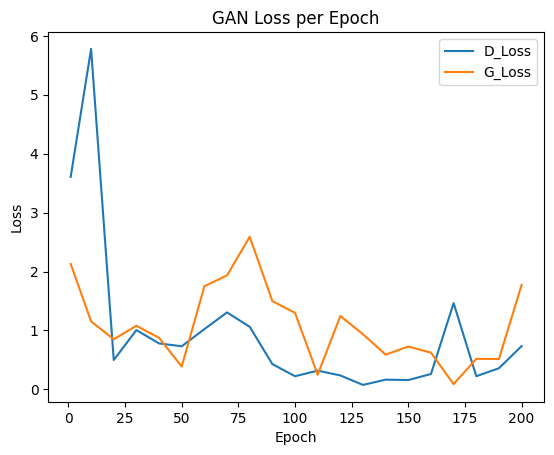

In [ ]:
import matplotlib.pyplot as plt

# List of GAN loss values per epoch
loss_values = [
    (1, 3.607902765274048, 2.1291141510009766),
    (10, 5.778540134429932, 1.1537294387817383),
    (20, 0.4979715943336487, 0.8495992422103882),
    (30, 1.0055065155029297, 1.0791914463043213),
    (40, 0.7790973782539368, 0.8738667964935303),
    (50, 0.730984091758728, 0.3857448101043701),
    (60, 1.0219098329544067, 1.7496716976165771),
    (70, 1.3057740926742554, 1.9340789318084717),
    (80, 1.0615001916885376, 2.5895586013793945),
    (90, 0.4283508360385895, 1.497155785560608),
    (100, 0.22257068753242493, 1.2981433868408203),
    (110, 0.3171861171722412, 0.2467060536146164),
    (120, 0.23574654757976532, 1.2451834678649902),
    (130, 0.07491083443164825, 0.9358645677566528),
    (140, 0.16427674889564514, 0.5891327261924744),
    (150, 0.15770937502384186, 0.7260985374450684),
    (160, 0.260226309299469, 0.6228988170623779),
    (170, 1.4636313915252686, 0.08801691979169846),
    (180, 0.22300730645656586, 0.5172552466392517),
    (190, 0.3582976460456848, 0.5150716304779053),
    (200, 0.7335672974586487, 1.7739360332489014),
]

# Separate the epoch, discriminator loss, and generator loss values
epochs, d_losses, g_losses = zip(*loss_values)

# Create a plot for the losses
plt.plot(epochs, d_losses, label="D_Loss")
plt.plot(epochs, g_losses, label="G_Loss")

# Set the title, labels, and legend
plt.title("GAN Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.show()


#3. Diffusion Models

Configuration grouping all the training hyperparameters

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 80
    gradient_accumulation_steps = 1
    learning_rate = 5e-5
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

Loading the dataset
> Note: Change the data_dir to generate images for different kinds of tumors


*   /content/drive/Shareddrives/project522/project_data/Training/notumor/
*   /content/drive/Shareddrives/project522/project_data/Training/glioma/
*   /content/drive/Shareddrives/project522/project_data/Training/meningioma/
*   /content/drive/Shareddrives/project522/project_data/Training/pituitary/



In [ ]:
from datasets import load_dataset
dataset= load_dataset("imagefolder", data_dir="/content/drive/Shareddrives/project522/project_data/Training/notumor/")
dataset=dataset['train']

Resolving data files:   0%|          | 0/1595 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-64735ce8ff3871ff/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Dataset content
dataset

Dataset({
    features: ['image'],
    num_rows: 1595
})

- Pre-processing images

Plotting random images

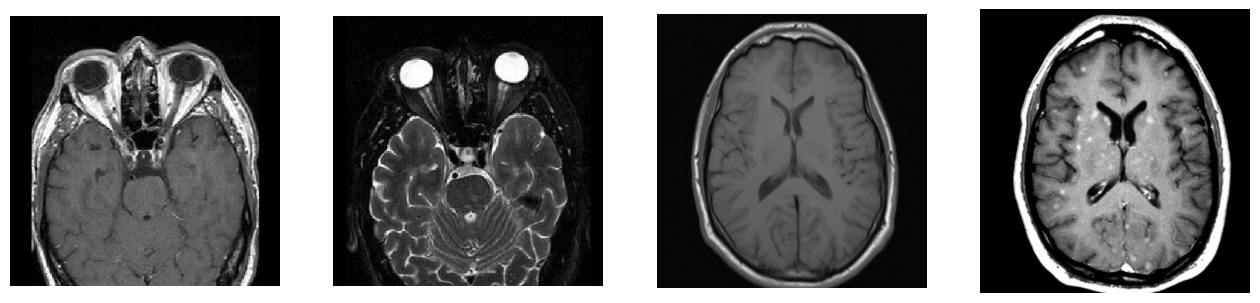

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

 Preprocessing images

In [ ]:
#Transform to convert the image into desired format
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
    
#Transform the image
dataset.set_transform(transform)

Plotting Pre-processed images and defining dataloader

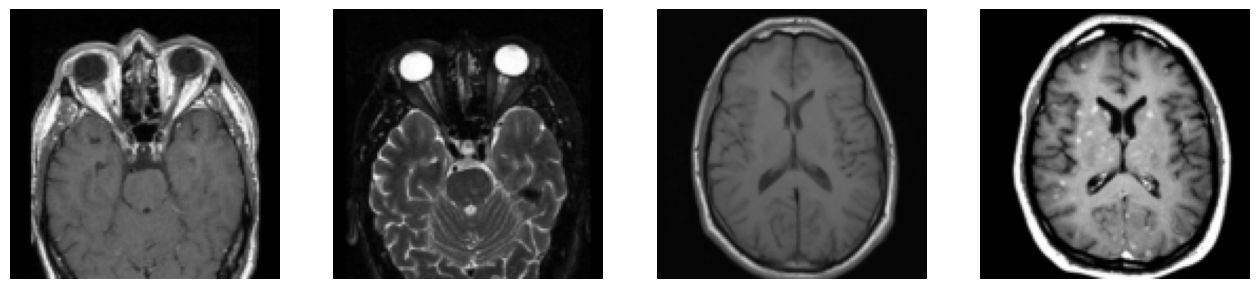

In [ ]:
#Plotting after pre-preocssing
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5,cmap='gray')
    axs[i].set_axis_off()
fig.show()

# Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

UNet2DModel
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.


In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    # the target image resolution
    sample_size=config.image_size,  
    # the number of input channels, 3 for RGB images
    in_channels=3,  
    # the number of output channels
    out_channels=3, 
    # how many ResNet layers to use per UNet block
    layers_per_block=2,  
    # the number of output channes for each UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512), 
    down_block_types=( 
        # a regular ResNet downsampling block
        "DownBlock2D",  
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",  
        "DownBlock2D",
    ), 
    up_block_types=(
        # a regular ResNet upsampling block
        "UpBlock2D",  
        # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D",  
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

Printing input and output tensor from the model

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


Defining the noise scheduler
- Using DDPMScheduler which corresponds to the training denoising and training algorithm proposed in Denoising Diffusion Probabilistic Models.

In [ ]:
#Noise scheduler
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Plotting the process of noise scheduling

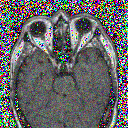

In [ ]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

Noise prediction, loss and optimizer initialization

In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

And a cosine learning rate schedule:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the DDPMPipeline 

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = 32, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=8)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

Training Function
-  wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training


In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        # if accelerator.is_main_process:
        pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            evaluate(config, epoch, pipeline)
            save_path = "/content/drive/Shareddrives/project522/notumor_4_24"+str(epoch+1)+".pth"
            torch.save(model.state_dict(), save_path)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            if config.push_to_hub:
                repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
            else:
                pipeline.save_pretrained(config.output_dir) 

Train
- Launch the training (including multi-GPU training) from the notebook using Accelerate's notebook_launcher function

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Change the path to call in different models for different kinds of tumors

>Glioma     : '/content/drive/Shareddrives/project522/models_4_2460.pth'

>meningioma : '/content/drive/Shareddrives/project522/meningioma_4_2460.pth'

>notumor    : '/content/drive/Shareddrives/project522/notumor_4_2480.pth'

>pituitary  : '/content/drive/Shareddrives/project522/pitutiary_4_2460.pth'

In [ ]:
path='/content/drive/Shareddrives/project522/models_4_2460.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model = model.to(device)

> Generating Images 

In [ ]:
# Initialize the accelerator
accelerator = Accelerator(
        mixed_precision='fp16' ,
        gradient_accumulation_steps=1, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
# accelerator = Accelerator()

# Unwrap the model if it's wrapped by the accelerator
unwrapped_model = accelerator.unwrap_model(model)

# Create the pipeline with the unwrapped model
pipeline = DDPMPipeline(unet=unwrapped_model, scheduler=noise_scheduler)

# Generate the images using the pipeline
images = pipeline(
    batch_size=50,
    generator=torch.manual_seed(40),
).images

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
!pip install pillow
from PIL import Image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


>Adding Images to the drive

In [ ]:
import os
import torchvision
output_dir = '/content/drive/Shareddrives/project522/Generated_final_images/glioma'
os.makedirs(output_dir, exist_ok=True)
for idx, image_pil in enumerate(images):

    # Define the output file path
    file_path = os.path.join(output_dir, f'image_1_{50 + idx}.png')

    # Save the denoised PIL image to the output file path
    image_pil.save(file_path)





>Adding these images with the original images to generate a new dataset and dataloader

In [ ]:
##Training paths and labels

train_dir = '/content/drive/Shareddrives/project522/Generated_final_images'
train_paths = []
train_labels = []
#For each image file in each subdirectory, appending file path to the train_paths list and its corresponding label to the train_labels list
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        train_paths.append(image_path)
        train_labels.append(label)
#Shuffling order of image paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
# Define the image transformations to be applied to the dataset.
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load the file paths for the training and testing sets.
image_paths_train = train_paths
label_paths_train = train_labels


# Create lists of tuples of image and label paths for the training and testing sets.
train_data = list(zip(image_paths_train, label_paths_train))


# Create ImageDataset objects for the training and testing sets using the lists of image and label paths and the transform.
train_dataset_generated = ImageDataset([d[0] for d in train_data], [d[1] for d in train_data], transform=transform)
# test_dataset = ImageDataset([d[0] for d in test_data], [d[1] for d in test_data], transform=transform)

In [ ]:
train_dataset_combined_generated = ConcatDataset([train_dataset, train_dataset_generated ])
train_loader_combined_generated = DataLoader(train_dataset_combined_generated , batch_size=batch_size, shuffle=True)

>Training it on modified resnet18 and finding the validation and training accuracy, loss.

>Plotting the curves

Epoch 1/10
----------


100%|██████████| 407/407 [14:26<00:00,  2.13s/it]


Train Loss: 0.7308 Acc: 0.7098


100%|██████████| 82/82 [06:56<00:00,  5.07s/it]


Val Loss: 0.6424 Acc: 0.7872
Epoch 2/10
----------


100%|██████████| 407/407 [00:42<00:00,  9.62it/s]


Train Loss: 0.5351 Acc: 0.7899


100%|██████████| 82/82 [00:06<00:00, 13.58it/s]


Val Loss: 0.7764 Acc: 0.7208
Epoch 3/10
----------


100%|██████████| 407/407 [00:41<00:00,  9.76it/s]


Train Loss: 0.4903 Acc: 0.8179


100%|██████████| 82/82 [00:06<00:00, 13.35it/s]


Val Loss: 0.4887 Acc: 0.8154
Epoch 4/10
----------


100%|██████████| 407/407 [00:41<00:00,  9.71it/s]


Train Loss: 0.4428 Acc: 0.8315


100%|██████████| 82/82 [00:07<00:00, 11.48it/s]


Val Loss: 0.4642 Acc: 0.8192
Epoch 5/10
----------


100%|██████████| 407/407 [00:42<00:00,  9.66it/s]


Train Loss: 0.4504 Acc: 0.8334


100%|██████████| 82/82 [00:06<00:00, 13.55it/s]


Val Loss: 0.5543 Acc: 0.7910
Epoch 6/10
----------


100%|██████████| 407/407 [00:42<00:00,  9.66it/s]


Train Loss: 0.4202 Acc: 0.8460


100%|██████████| 82/82 [00:06<00:00, 13.16it/s]


Val Loss: 0.4922 Acc: 0.8200
Epoch 7/10
----------


100%|██████████| 407/407 [00:41<00:00,  9.73it/s]


Train Loss: 0.4016 Acc: 0.8487


100%|██████████| 82/82 [00:07<00:00, 11.14it/s]


Val Loss: 0.5004 Acc: 0.8055
Epoch 8/10
----------


100%|██████████| 407/407 [00:42<00:00,  9.67it/s]


Train Loss: 0.3470 Acc: 0.8722


100%|██████████| 82/82 [00:06<00:00, 12.50it/s]


Val Loss: 0.4336 Acc: 0.8429
Epoch 9/10
----------


100%|██████████| 407/407 [00:41<00:00,  9.71it/s]


Train Loss: 0.3264 Acc: 0.8801


100%|██████████| 82/82 [00:06<00:00, 11.75it/s]


Val Loss: 0.4014 Acc: 0.8535
Epoch 10/10
----------


100%|██████████| 407/407 [00:41<00:00,  9.75it/s]


Train Loss: 0.3318 Acc: 0.8782


100%|██████████| 82/82 [00:07<00:00, 11.49it/s]


Val Loss: 0.4124 Acc: 0.8513


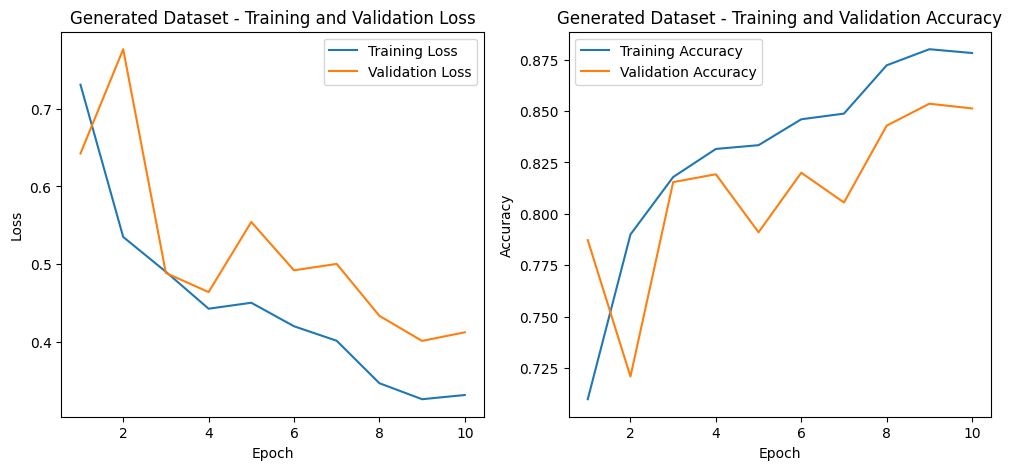

In [ ]:
# Instantiate and train the model with the original dataset
resnet18 = models.resnet18(pretrained=True)
set_parameter_requires_grad(resnet18, True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet18.fc.in_features
num_classes = 4
resnet18.fc = nn.Linear(num_ftrs, num_classes)

# Train the model with the original dataset and plot the history
train_loss_gen, train_acc_gen, val_loss_gen, val_acc_gen = train_model(resnet18, train_loader_combined_generated , test_loader)
plot_history(train_loss_gen, train_acc_gen, val_loss_gen, val_acc_gen, "Generated Dataset")